# Homework 2
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right???

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [ ]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.7.0+cu101 (or something like this)
# CUDA enabled: True

Version 1.7.0+cu101
CUDA enabled: True


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
MyDrive


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to set up the homework3 files.



In [ ]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')

--2020-11-17 04:04:46--  https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
Resolving courses.cs.washington.edu (courses.cs.washington.edu)... 128.208.1.193, 2607:4000:200:10::c1
Connecting to courses.cs.washington.edu (courses.cs.washington.edu)|128.208.1.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2324076 (2.2M) [application/x-gzip]
Saving to: ‘homework3.tar.gz’

homework3.tar.gz    100%[===================>]   2.22M  2.21MB/s    in 1.0s    

2020-11-17 04:04:48 (2.21 MB/s) - ‘homework3.tar.gz’ saved [2324076/2324076]

harry_potter.txt
pt_util.py


In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [ ]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    # replace all the whitespace characters with ' ' 
    data = re.sub('\s+', ' ', data)
    data.strip()
    
    voc2ind = {}
    tokens = []
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    seed = 0
    for char in data:
      # TODO Fill this in
      if char not in voc2ind:
        voc2ind[char] = seed
        seed += 1
      tokens.append(voc2ind[char])  

    ind2voc = {val: key for key, val in voc2ind.items()}
    
    # determine the place to separate training data and testing data
    tokens_len = len(tokens)
    pivot = int(0.8 * tokens_len)

    train_text = np.array(tokens[:pivot]) # TODO Fill this in
    test_text = np.array(tokens[pivot+1:]) # TODO Fill this in

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [ ]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)
        self.chunk_size = 0
        self.chunks = []

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        tokens = dataset['tokens'] # np array
        self.chunk_size = len(tokens) // batch_size
        
        for i in range(batch_size):
          self.chunks.append(tokens[i*self.chunk_size: (i+1)*self.chunk_size])

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
        return ((self.chunk_size-2) // self.sequence_length + 1) * self.batch_size
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        if idx >= len(self.chunks) * self.chunk_size:
          return None

        batch_idx = idx // self.batch_size
        chunk_idx = idx % self.batch_size
        data = self.chunks[chunk_idx][batch_idx*self.sequence_length : min((batch_idx+1)*self.sequence_length, self.chunk_size-1) + 1]
        data = torch.LongTensor(data)
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [ ]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru. 
        encode = self.encoder(x)
        decode,hidden_state=self.gru(encode,hidden_state)
        decode = self.decoder(decode)
        return decode, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [ ]:
TEMPERATURE = 0.5
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        idx = torch.argmax(output[0])
        outputs.append(idx)
        output, hidden = model.inference(idx, hidden)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        idx = torch.multinomial(output,1)[0]
        outputs.append(idx)
        output, hidden = model.inference(idx, hidden)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    beams = [([], output, hidden, 0)]
    # TODO
    for ii in range(sequence_length):
      new_beams = []
      for beam in beams:
        char_list = torch.multinomial(beam[1][0], beam_width, replacement=True)
        for char_idx in char_list:
          char_score = torch.log(beam[1][0][char_idx].float())
          new_outputs = beam[0]+[char_idx]
          new_output, new_hidden = model.inference(char_idx,beam[2],temperature=1)
          new_score = beam[3] + char_score
          new_beam = (new_outputs, new_output, new_hidden, new_score)
          new_beams.append(new_beam)
      beams= sorted(new_beams, key=lambda x: x[3], reverse=True)[:beam_width]
    outputs = beams[0][0]
    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [ ]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cuda
num workers: 2
Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	z/t^,5?%%DD$1P$1~{UlOO$%e%1??5,D?D2e_lt222{1~}OKpp{^/!A{^6QxKKDADii%POOK,,Klq5F22tttri%%,,pii%POD{tt


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	2??PO,D,D2G,At22e_lEr{1POD{tttODA~~~OO,GG,1lOOtt2,$2'45UU22,DAD52hOhE{k{?Et2,D^?5{51~~OO5D,D22lA%2l2


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ll%U%_$UP$Pt%~~%U%5%UUUD?DD%PPP~O2{O,DADP$t44N5%DDD,/,E,55UUD2z%6A^PlAOP2t222E2D2tt%,1lOG2nlUE5D{ttt


Input	elp,

  0%|          | 0/195 [00:00<?, ?it/s]

Input	 - but what's wrong with Albus?' She came to a halt, panting, and stared down, wide-eyed, at Dumbled
GT	- but what's wrong with Albus?' She came to a halt, panting, and stared down, wide-eyed, at Dumbledo
pred	ODD,G,50s^?l?50F22z_F%,DD5'1C?6l$RD(D2e^l2,2O{ODe1P,Oee11?U%,p{1POi,itlOOPOkUW00kPl~EL~OWO{,5,GG,1lO



Test set: Average loss: 17.6456, Accuracy: 11588/1254400 (1%)



  2%|▏         | 4/195 [00:00<00:09, 19.21it/s]

Train Epoch: 0 [0/49920 (0%)]	Loss: 17.588541


  7%|▋         | 14/195 [00:00<00:09, 18.69it/s]

Train Epoch: 0 [2560/49920 (5%)]	Loss: 12.459631


 12%|█▏        | 24/195 [00:01<00:09, 18.56it/s]

Train Epoch: 0 [5120/49920 (10%)]	Loss: 6.240824


 17%|█▋        | 34/195 [00:01<00:08, 18.69it/s]

Train Epoch: 0 [7680/49920 (15%)]	Loss: 4.068092


 23%|██▎       | 44/195 [00:02<00:08, 18.68it/s]

Train Epoch: 0 [10240/49920 (21%)]	Loss: 2.993736


 28%|██▊       | 54/195 [00:02<00:07, 18.66it/s]

Train Epoch: 0 [12800/49920 (26%)]	Loss: 2.597806


 33%|███▎      | 64/195 [00:03<00:06, 18.74it/s]

Train Epoch: 0 [15360/49920 (31%)]	Loss: 3.256653


 38%|███▊      | 74/195 [00:03<00:06, 18.54it/s]

Train Epoch: 0 [17920/49920 (36%)]	Loss: 2.750736


 43%|████▎     | 84/195 [00:04<00:06, 18.35it/s]

Train Epoch: 0 [20480/49920 (41%)]	Loss: 2.525189


 48%|████▊     | 94/195 [00:05<00:05, 18.48it/s]

Train Epoch: 0 [23040/49920 (46%)]	Loss: 2.487272


 53%|█████▎    | 104/195 [00:05<00:04, 18.52it/s]

Train Epoch: 0 [25600/49920 (51%)]	Loss: 2.218855


 58%|█████▊    | 114/195 [00:06<00:04, 18.60it/s]

Train Epoch: 0 [28160/49920 (56%)]	Loss: 2.119231


 64%|██████▎   | 124/195 [00:06<00:03, 18.46it/s]

Train Epoch: 0 [30720/49920 (62%)]	Loss: 1.991387


 69%|██████▊   | 134/195 [00:07<00:03, 18.55it/s]

Train Epoch: 0 [33280/49920 (67%)]	Loss: 1.939989


 74%|███████▍  | 144/195 [00:07<00:02, 18.70it/s]

Train Epoch: 0 [35840/49920 (72%)]	Loss: 2.125512


 79%|███████▉  | 154/195 [00:08<00:02, 18.57it/s]

Train Epoch: 0 [38400/49920 (77%)]	Loss: 2.726337


 84%|████████▍ | 164/195 [00:08<00:01, 18.58it/s]

Train Epoch: 0 [40960/49920 (82%)]	Loss: 2.794167


 89%|████████▉ | 174/195 [00:09<00:01, 17.78it/s]

Train Epoch: 0 [43520/49920 (87%)]	Loss: 2.150393


 94%|█████████▍| 184/195 [00:09<00:00, 18.51it/s]

Train Epoch: 0 [46080/49920 (92%)]	Loss: 1.910714


100%|██████████| 195/195 [00:10<00:00, 18.51it/s]

Train Epoch: 0 [48640/49920 (97%)]	Loss: 1.854893


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 iddhfudhttnd hafsdd s ain.  hhe fale   hasl  "W sn Iarri... "a said  "Sun't yauky, wint  said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	s d the fft r sane  Ind sarry sa d.d wumbledore weck tn o she cn  cacv y d shet surl   whe faucena f


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	  ng h d siigplng hn hhe findle ff whe fiyk nashtwnuucduun taww edd d "ir wn  waw isle surent warry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:10, 17.68it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry saway full face fall face fall face fall face fall face fall face fall face fall face fall face fall face fall face fall face fall face fall face fall face fall face fall face fall face fall fac

Train Epoch: 1 [0/49920 (0%)]	Loss: 2.058545


  7%|▋         | 14/195 [00:00<00:09, 18.33it/s]

Train Epoch: 1 [2560/49920 (5%)]	Loss: 2.199675


 12%|█▏        | 24/195 [00:01<00:09, 18.61it/s]

Train Epoch: 1 [5120/49920 (10%)]	Loss: 1.935547


 17%|█▋        | 34/195 [00:01<00:08, 18.60it/s]

Train Epoch: 1 [7680/49920 (15%)]	Loss: 1.812143


 23%|██▎       | 44/195 [00:02<00:08, 18.69it/s]

Train Epoch: 1 [10240/49920 (21%)]	Loss: 1.724228


 28%|██▊       | 54/195 [00:02<00:07, 18.41it/s]

Train Epoch: 1 [12800/49920 (26%)]	Loss: 1.716979


 33%|███▎      | 64/195 [00:03<00:07, 18.46it/s]

Train Epoch: 1 [15360/49920 (31%)]	Loss: 1.906196


 38%|███▊      | 74/195 [00:03<00:06, 18.40it/s]

Train Epoch: 1 [17920/49920 (36%)]	Loss: 1.793146


 43%|████▎     | 84/195 [00:04<00:06, 18.43it/s]

Train Epoch: 1 [20480/49920 (41%)]	Loss: 1.799111


 48%|████▊     | 94/195 [00:05<00:05, 18.48it/s]

Train Epoch: 1 [23040/49920 (46%)]	Loss: 1.900665


 53%|█████▎    | 104/195 [00:05<00:04, 18.43it/s]

Train Epoch: 1 [25600/49920 (51%)]	Loss: 1.797560


 58%|█████▊    | 114/195 [00:06<00:04, 18.54it/s]

Train Epoch: 1 [28160/49920 (56%)]	Loss: 1.699152


 64%|██████▎   | 124/195 [00:06<00:03, 18.51it/s]

Train Epoch: 1 [30720/49920 (62%)]	Loss: 1.663995


 69%|██████▊   | 134/195 [00:07<00:03, 18.41it/s]

Train Epoch: 1 [33280/49920 (67%)]	Loss: 1.673275


 74%|███████▍  | 144/195 [00:07<00:02, 18.48it/s]

Train Epoch: 1 [35840/49920 (72%)]	Loss: 1.672105


 79%|███████▉  | 154/195 [00:08<00:02, 18.50it/s]

Train Epoch: 1 [38400/49920 (77%)]	Loss: 1.732511


 84%|████████▍ | 164/195 [00:08<00:01, 18.48it/s]

Train Epoch: 1 [40960/49920 (82%)]	Loss: 1.905091


 89%|████████▉ | 174/195 [00:09<00:01, 18.54it/s]

Train Epoch: 1 [43520/49920 (87%)]	Loss: 1.706343


 94%|█████████▍| 184/195 [00:09<00:00, 18.47it/s]

Train Epoch: 1 [46080/49920 (92%)]	Loss: 1.616499


100%|██████████| 195/195 [00:10<00:00, 18.53it/s]

Train Epoch: 1 [48640/49920 (97%)]	Loss: 1.602732


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 iddehhdhttnd hogdtd tnain t the chre  ooasl  "W sl Iorri .  "e said  "Won't yarki  Ittt  said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed hhe snt r oone  Ind harry saad d humbledore weck on o the cnk aoer yed ihet horl d hhe shoaeol t


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	  ng hnd seegpeng hn the sigdle of the sirk oashttnuuemean tagwmeaded "ir sne oesrible terent tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:10, 18.56it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He had been exament to see the of the streed of the streed of the streed of the chose of the streed of the chose of the streed of the chose of the streed of the streed of the streed of the streed of t

Train Epoch: 2 [0/49920 (0%)]	Loss: 1.614912


  7%|▋         | 14/195 [00:00<00:09, 18.51it/s]

Train Epoch: 2 [2560/49920 (5%)]	Loss: 1.613615


 12%|█▏        | 24/195 [00:01<00:09, 18.57it/s]

Train Epoch: 2 [5120/49920 (10%)]	Loss: 1.601031


 17%|█▋        | 34/195 [00:01<00:08, 18.49it/s]

Train Epoch: 2 [7680/49920 (15%)]	Loss: 1.690320


 23%|██▎       | 44/195 [00:02<00:08, 18.54it/s]

Train Epoch: 2 [10240/49920 (21%)]	Loss: 1.885144


 28%|██▊       | 54/195 [00:02<00:07, 18.44it/s]

Train Epoch: 2 [12800/49920 (26%)]	Loss: 1.724793


 33%|███▎      | 64/195 [00:03<00:07, 18.49it/s]

Train Epoch: 2 [15360/49920 (31%)]	Loss: 1.634184


 38%|███▊      | 74/195 [00:04<00:06, 18.45it/s]

Train Epoch: 2 [17920/49920 (36%)]	Loss: 1.576671


 43%|████▎     | 84/195 [00:04<00:06, 18.45it/s]

Train Epoch: 2 [20480/49920 (41%)]	Loss: 1.545816


 48%|████▊     | 94/195 [00:05<00:05, 18.71it/s]

Train Epoch: 2 [23040/49920 (46%)]	Loss: 1.696620


 53%|█████▎    | 104/195 [00:05<00:04, 18.70it/s]

Train Epoch: 2 [25600/49920 (51%)]	Loss: 2.281876


 58%|█████▊    | 114/195 [00:06<00:04, 17.38it/s]

Train Epoch: 2 [28160/49920 (56%)]	Loss: 1.899331


 64%|██████▎   | 124/195 [00:06<00:03, 18.30it/s]

Train Epoch: 2 [30720/49920 (62%)]	Loss: 1.674095


 69%|██████▊   | 134/195 [00:07<00:03, 18.60it/s]

Train Epoch: 2 [33280/49920 (67%)]	Loss: 1.627879


 74%|███████▍  | 144/195 [00:07<00:02, 18.62it/s]

Train Epoch: 2 [35840/49920 (72%)]	Loss: 1.577720


 79%|███████▉  | 154/195 [00:08<00:02, 18.53it/s]

Train Epoch: 2 [38400/49920 (77%)]	Loss: 1.549148


 84%|████████▍ | 164/195 [00:08<00:01, 18.63it/s]

Train Epoch: 2 [40960/49920 (82%)]	Loss: 1.533946


 89%|████████▉ | 174/195 [00:09<00:01, 18.51it/s]

Train Epoch: 2 [43520/49920 (87%)]	Loss: 1.533891


 94%|█████████▍| 184/195 [00:09<00:00, 18.63it/s]

Train Epoch: 2 [46080/49920 (92%)]	Loss: 1.556989


100%|██████████| 195/195 [00:10<00:00, 18.48it/s]

Train Epoch: 2 [48640/49920 (97%)]	Loss: 1.611333


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 o t thgntttd toadtd ttain t the cone  ooasl  "I sl ea re..  "e said  "Ion't yarry  tott" said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed toe ott   oone  tnd tarry saad d tumbledore teck tn o the ctk ooet yed toet tirl d ooe fooaeoe t


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	  ng ttd teonpeng tn the sogdle of the fork oashttnuuateon tagwme de  "or sne oesroble terent oagry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:11, 17.12it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "You don't do you to the tround the table to the tround the table to the finished to the table to the table to the finished to the table to the table to the table to the table one of the controom on t

Train Epoch: 3 [0/49920 (0%)]	Loss: 1.603871


  7%|▋         | 14/195 [00:00<00:10, 18.07it/s]

Train Epoch: 3 [2560/49920 (5%)]	Loss: 1.551447


 12%|█▏        | 24/195 [00:01<00:09, 18.57it/s]

Train Epoch: 3 [5120/49920 (10%)]	Loss: 1.509663


 17%|█▋        | 34/195 [00:01<00:08, 18.43it/s]

Train Epoch: 3 [7680/49920 (15%)]	Loss: 1.522085


 23%|██▎       | 44/195 [00:02<00:08, 18.38it/s]

Train Epoch: 3 [10240/49920 (21%)]	Loss: 1.509659


 28%|██▊       | 54/195 [00:02<00:07, 18.47it/s]

Train Epoch: 3 [12800/49920 (26%)]	Loss: 1.497987


 33%|███▎      | 64/195 [00:03<00:07, 18.60it/s]

Train Epoch: 3 [15360/49920 (31%)]	Loss: 1.498838


 38%|███▊      | 74/195 [00:04<00:06, 18.44it/s]

Train Epoch: 3 [17920/49920 (36%)]	Loss: 1.495589


 43%|████▎     | 84/195 [00:04<00:05, 18.76it/s]

Train Epoch: 3 [20480/49920 (41%)]	Loss: 1.598724


 48%|████▊     | 94/195 [00:05<00:05, 18.49it/s]

Train Epoch: 3 [23040/49920 (46%)]	Loss: 1.609599


 53%|█████▎    | 104/195 [00:05<00:04, 18.35it/s]

Train Epoch: 3 [25600/49920 (51%)]	Loss: 1.521068


 58%|█████▊    | 114/195 [00:06<00:04, 18.64it/s]

Train Epoch: 3 [28160/49920 (56%)]	Loss: 1.502614


 64%|██████▎   | 124/195 [00:06<00:03, 18.66it/s]

Train Epoch: 3 [30720/49920 (62%)]	Loss: 1.495888


 69%|██████▊   | 134/195 [00:07<00:03, 18.67it/s]

Train Epoch: 3 [33280/49920 (67%)]	Loss: 1.521836


 74%|███████▍  | 144/195 [00:07<00:02, 18.66it/s]

Train Epoch: 3 [35840/49920 (72%)]	Loss: 1.541792


 79%|███████▉  | 154/195 [00:08<00:02, 18.71it/s]

Train Epoch: 3 [38400/49920 (77%)]	Loss: 1.525978


 84%|████████▍ | 164/195 [00:08<00:01, 18.72it/s]

Train Epoch: 3 [40960/49920 (82%)]	Loss: 1.483174


 89%|████████▉ | 174/195 [00:09<00:01, 18.64it/s]

Train Epoch: 3 [43520/49920 (87%)]	Loss: 1.466976


 94%|█████████▍| 184/195 [00:09<00:00, 18.49it/s]

Train Epoch: 3 [46080/49920 (92%)]	Loss: 1.484113


100%|██████████| 195/195 [00:10<00:00, 18.55it/s]

Train Epoch: 3 [48640/49920 (97%)]	Loss: 1.491587


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 owt thghtttd saadtd atainst the moreraoaasl  "I sl Iarri..  "e said  "Ion't yarry  Iot,  said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the mtt r aone  and tarry saad d humbledore weck tn o the fnk aoet y d ahet tlrl d ahe fooaete a


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	 eng atd seenpeng hn the fogdle af the ferk aashttnuaamean tagwmeaded "or ane aewrible serent.aarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:10, 18.24it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The was a large and a large and a large at the first the first time the first time the moment at the flat all the back to the flat at the flat at the flat at the strong the could be a large and a larg

Train Epoch: 4 [0/49920 (0%)]	Loss: 1.500461


  7%|▋         | 14/195 [00:00<00:09, 18.26it/s]

Train Epoch: 4 [2560/49920 (5%)]	Loss: 1.497532


 12%|█▏        | 24/195 [00:01<00:09, 18.41it/s]

Train Epoch: 4 [5120/49920 (10%)]	Loss: 1.466974


 17%|█▋        | 34/195 [00:01<00:08, 18.67it/s]

Train Epoch: 4 [7680/49920 (15%)]	Loss: 1.478027


 23%|██▎       | 44/195 [00:02<00:08, 18.50it/s]

Train Epoch: 4 [10240/49920 (21%)]	Loss: 1.466442


 28%|██▊       | 54/195 [00:02<00:07, 18.32it/s]

Train Epoch: 4 [12800/49920 (26%)]	Loss: 1.472462


 33%|███▎      | 64/195 [00:03<00:07, 18.33it/s]

Train Epoch: 4 [15360/49920 (31%)]	Loss: 1.457046


 38%|███▊      | 74/195 [00:04<00:06, 17.88it/s]

Train Epoch: 4 [17920/49920 (36%)]	Loss: 1.451185


 43%|████▎     | 84/195 [00:04<00:06, 18.34it/s]

Train Epoch: 4 [20480/49920 (41%)]	Loss: 1.438930


 48%|████▊     | 94/195 [00:05<00:05, 18.43it/s]

Train Epoch: 4 [23040/49920 (46%)]	Loss: 1.455191


 53%|█████▎    | 104/195 [00:05<00:04, 18.50it/s]

Train Epoch: 4 [25600/49920 (51%)]	Loss: 1.459943


 58%|█████▊    | 114/195 [00:06<00:04, 18.60it/s]

Train Epoch: 4 [28160/49920 (56%)]	Loss: 1.463940


 64%|██████▎   | 124/195 [00:06<00:03, 18.36it/s]

Train Epoch: 4 [30720/49920 (62%)]	Loss: 1.483554


 69%|██████▊   | 134/195 [00:07<00:03, 18.63it/s]

Train Epoch: 4 [33280/49920 (67%)]	Loss: 1.526784


 74%|███████▍  | 144/195 [00:07<00:02, 18.69it/s]

Train Epoch: 4 [35840/49920 (72%)]	Loss: 1.512117


 79%|███████▉  | 154/195 [00:08<00:02, 18.45it/s]

Train Epoch: 4 [38400/49920 (77%)]	Loss: 1.538975


 84%|████████▍ | 164/195 [00:08<00:01, 18.30it/s]

Train Epoch: 4 [40960/49920 (82%)]	Loss: 1.501366


 89%|████████▉ | 174/195 [00:09<00:01, 18.46it/s]

Train Epoch: 4 [43520/49920 (87%)]	Loss: 1.450115


 94%|█████████▍| 184/195 [00:10<00:00, 18.58it/s]

Train Epoch: 4 [46080/49920 (92%)]	Loss: 1.433659


100%|██████████| 195/195 [00:10<00:00, 18.43it/s]

Train Epoch: 4 [48640/49920 (97%)]	Loss: 1.441559


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 iwt thgnttnd hoaded anainst the more  oaasl  "I sl nhrri..  "e said  "Iin't yanry, Ihr,  said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed hhe bnt r oone  and harry saad d humbledore weck on o the cnk ooet y d thet horl d ohe mooaele a


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ring hnd seonpeng hn the sogdle of the serk oashthnuiemean tagwmeade  "or ane oewrible serent aarry'


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:11, 17.52it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He had no seen the boys of the school of the school of the school of the school of the school of the school of the school of the school of the books on her been and she was a long and he was still sli

Train Epoch: 5 [0/49920 (0%)]	Loss: 1.449157


  7%|▋         | 14/195 [00:00<00:09, 18.25it/s]

Train Epoch: 5 [2560/49920 (5%)]	Loss: 1.453307


 12%|█▏        | 24/195 [00:01<00:09, 18.48it/s]

Train Epoch: 5 [5120/49920 (10%)]	Loss: 1.450670


 17%|█▋        | 34/195 [00:01<00:08, 18.54it/s]

Train Epoch: 5 [7680/49920 (15%)]	Loss: 1.501577


 23%|██▎       | 44/195 [00:02<00:08, 18.65it/s]

Train Epoch: 5 [10240/49920 (21%)]	Loss: 1.452425


 28%|██▊       | 54/195 [00:02<00:07, 18.54it/s]

Train Epoch: 5 [12800/49920 (26%)]	Loss: 1.426939


 33%|███▎      | 64/195 [00:03<00:07, 18.50it/s]

Train Epoch: 5 [15360/49920 (31%)]	Loss: 1.438439


 38%|███▊      | 74/195 [00:04<00:06, 18.50it/s]

Train Epoch: 5 [17920/49920 (36%)]	Loss: 1.427031


 43%|████▎     | 84/195 [00:04<00:06, 18.49it/s]

Train Epoch: 5 [20480/49920 (41%)]	Loss: 1.405406


 48%|████▊     | 94/195 [00:05<00:05, 18.40it/s]

Train Epoch: 5 [23040/49920 (46%)]	Loss: 1.430794


 53%|█████▎    | 104/195 [00:05<00:04, 18.27it/s]

Train Epoch: 5 [25600/49920 (51%)]	Loss: 1.448360


 58%|█████▊    | 114/195 [00:06<00:04, 18.38it/s]

Train Epoch: 5 [28160/49920 (56%)]	Loss: 1.430693


 64%|██████▎   | 124/195 [00:06<00:03, 18.41it/s]

Train Epoch: 5 [30720/49920 (62%)]	Loss: 1.492292


 69%|██████▊   | 134/195 [00:07<00:03, 18.38it/s]

Train Epoch: 5 [33280/49920 (67%)]	Loss: 1.517768


 74%|███████▍  | 144/195 [00:07<00:02, 18.44it/s]

Train Epoch: 5 [35840/49920 (72%)]	Loss: 1.482264


 79%|███████▉  | 154/195 [00:08<00:02, 18.51it/s]

Train Epoch: 5 [38400/49920 (77%)]	Loss: 1.433081


 84%|████████▍ | 164/195 [00:08<00:01, 18.47it/s]

Train Epoch: 5 [40960/49920 (82%)]	Loss: 1.411589


 89%|████████▉ | 174/195 [00:09<00:01, 18.62it/s]

Train Epoch: 5 [43520/49920 (87%)]	Loss: 1.398797


 94%|█████████▍| 184/195 [00:09<00:00, 18.45it/s]

Train Epoch: 5 [46080/49920 (92%)]	Loss: 1.398928


100%|██████████| 195/195 [00:10<00:00, 18.49it/s]

Train Epoch: 5 [48640/49920 (97%)]	Loss: 1.418354


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 iwd thgnttnd sogned tnainst the fase  oaask  "I sl nhrr ".  "e said  "Iun't yanry, yor," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the bnt r olner and harry saap d humbledore seck onto the fnk oietny d that horl d ohe paoaela a


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ring hnd seonpeng hn the foddle of the ferk oashtanuae ean tagwmeade  "or ane oewrible serent aarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:10, 18.66it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The was so that the back on the floor and she was a long and she was a long and she was a long and she was a long and she was a long and she was a long and she was a long and she was a long and she wa

Train Epoch: 6 [0/49920 (0%)]	Loss: 1.426024


  7%|▋         | 14/195 [00:00<00:09, 18.42it/s]

Train Epoch: 6 [2560/49920 (5%)]	Loss: 1.422185


 12%|█▏        | 24/195 [00:01<00:10, 16.63it/s]

Train Epoch: 6 [5120/49920 (10%)]	Loss: 1.405982


 17%|█▋        | 34/195 [00:01<00:09, 17.83it/s]

Train Epoch: 6 [7680/49920 (15%)]	Loss: 1.434253


 23%|██▎       | 44/195 [00:02<00:08, 18.51it/s]

Train Epoch: 6 [10240/49920 (21%)]	Loss: 1.419841


 28%|██▊       | 54/195 [00:02<00:07, 18.35it/s]

Train Epoch: 6 [12800/49920 (26%)]	Loss: 1.410362


 33%|███▎      | 64/195 [00:03<00:07, 18.33it/s]

Train Epoch: 6 [15360/49920 (31%)]	Loss: 1.470982


 38%|███▊      | 74/195 [00:04<00:06, 18.62it/s]

Train Epoch: 6 [17920/49920 (36%)]	Loss: 1.429673


 43%|████▎     | 84/195 [00:04<00:05, 18.53it/s]

Train Epoch: 6 [20480/49920 (41%)]	Loss: 1.399977


 48%|████▊     | 94/195 [00:05<00:05, 18.46it/s]

Train Epoch: 6 [23040/49920 (46%)]	Loss: 1.412550


 53%|█████▎    | 104/195 [00:05<00:04, 18.46it/s]

Train Epoch: 6 [25600/49920 (51%)]	Loss: 1.407644


 58%|█████▊    | 114/195 [00:06<00:04, 18.41it/s]

Train Epoch: 6 [28160/49920 (56%)]	Loss: 1.390669


 64%|██████▎   | 124/195 [00:06<00:03, 18.34it/s]

Train Epoch: 6 [30720/49920 (62%)]	Loss: 1.443690


 69%|██████▊   | 134/195 [00:07<00:03, 18.23it/s]

Train Epoch: 6 [33280/49920 (67%)]	Loss: 1.500156


 74%|███████▍  | 144/195 [00:07<00:02, 18.45it/s]

Train Epoch: 6 [35840/49920 (72%)]	Loss: 1.441225


 79%|███████▉  | 154/195 [00:08<00:02, 18.67it/s]

Train Epoch: 6 [38400/49920 (77%)]	Loss: 1.425579


 84%|████████▍ | 164/195 [00:08<00:01, 18.44it/s]

Train Epoch: 6 [40960/49920 (82%)]	Loss: 1.393124


 89%|████████▉ | 174/195 [00:09<00:01, 18.43it/s]

Train Epoch: 6 [43520/49920 (87%)]	Loss: 1.384112


 94%|█████████▍| 184/195 [00:10<00:00, 18.27it/s]

Train Epoch: 6 [46080/49920 (92%)]	Loss: 1.382442


100%|██████████| 195/195 [00:10<00:00, 18.38it/s]

Train Epoch: 6 [48640/49920 (97%)]	Loss: 1.407161


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 iwd togntand sogned tnainst the fase  oaask  "I sl nhrrn..  "e said  "Ion't yanry  yor," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the bnt r alner and harry saap d humbledore seck onto the fnk oietny d.ahat horl d ohe fooaela a


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ring hnd sionpeng hn the foddle of the ferk aash anoaetean tagwmeade  "or afe oewrible sorent,aarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:10, 17.70it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry started to the first the first time the first time the only what he was still so that he had been and so that the door of the first time the only what he was so that the door of the moment and s

Train Epoch: 7 [0/49920 (0%)]	Loss: 1.414094


  7%|▋         | 14/195 [00:00<00:09, 18.33it/s]

Train Epoch: 7 [2560/49920 (5%)]	Loss: 1.408074


 12%|█▏        | 24/195 [00:01<00:09, 18.54it/s]

Train Epoch: 7 [5120/49920 (10%)]	Loss: 1.393120


 17%|█▋        | 34/195 [00:01<00:08, 18.56it/s]

Train Epoch: 7 [7680/49920 (15%)]	Loss: 1.418753


 23%|██▎       | 44/195 [00:02<00:08, 18.42it/s]

Train Epoch: 7 [10240/49920 (21%)]	Loss: 1.401744


 28%|██▊       | 54/195 [00:02<00:07, 18.54it/s]

Train Epoch: 7 [12800/49920 (26%)]	Loss: 1.402937


 33%|███▎      | 64/195 [00:03<00:07, 18.54it/s]

Train Epoch: 7 [15360/49920 (31%)]	Loss: 1.420876


 38%|███▊      | 74/195 [00:04<00:06, 18.12it/s]

Train Epoch: 7 [17920/49920 (36%)]	Loss: 1.418563


 43%|████▎     | 84/195 [00:04<00:06, 18.37it/s]

Train Epoch: 7 [20480/49920 (41%)]	Loss: 1.390357


 48%|████▊     | 94/195 [00:05<00:05, 18.41it/s]

Train Epoch: 7 [23040/49920 (46%)]	Loss: 1.395307


 53%|█████▎    | 104/195 [00:05<00:04, 18.54it/s]

Train Epoch: 7 [25600/49920 (51%)]	Loss: 1.395749


 58%|█████▊    | 114/195 [00:06<00:04, 18.41it/s]

Train Epoch: 7 [28160/49920 (56%)]	Loss: 1.374242


 64%|██████▎   | 124/195 [00:06<00:03, 18.38it/s]

Train Epoch: 7 [30720/49920 (62%)]	Loss: 1.391005


 69%|██████▊   | 134/195 [00:07<00:03, 18.55it/s]

Train Epoch: 7 [33280/49920 (67%)]	Loss: 1.429335


 74%|███████▍  | 144/195 [00:07<00:02, 18.60it/s]

Train Epoch: 7 [35840/49920 (72%)]	Loss: 1.418685


 79%|███████▉  | 154/195 [00:08<00:02, 18.27it/s]

Train Epoch: 7 [38400/49920 (77%)]	Loss: 1.406308


 84%|████████▍ | 164/195 [00:08<00:01, 18.36it/s]

Train Epoch: 7 [40960/49920 (82%)]	Loss: 1.385787


 89%|████████▉ | 174/195 [00:09<00:01, 18.47it/s]

Train Epoch: 7 [43520/49920 (87%)]	Loss: 1.378385


 94%|█████████▍| 184/195 [00:09<00:00, 18.40it/s]

Train Epoch: 7 [46080/49920 (92%)]	Loss: 1.375505


100%|██████████| 195/195 [00:10<00:00, 18.49it/s]

Train Epoch: 7 [48640/49920 (97%)]	Loss: 1.393697


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 ied tigntand sogned tnainst the fose  oaask  "I sl ah'rn..  "e said  "Ion't wanry "yor," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the snt r aoner and sarry saad d humbledore seck onto the fnk seetnyyd ahat horl d ohe fooaela a


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	reng and sianpeng hn the foddle of the ferk aash anoaetean tagwmeade  "or afe sewrible sorent,aarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:10, 19.27it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Hermione said, "I see the only what was a long and something and what was a sort of the many was a long and stranger and started to the first time the for the first time the for the first time the for

Train Epoch: 8 [0/49920 (0%)]	Loss: 1.402552


  7%|▋         | 14/195 [00:00<00:09, 18.62it/s]

Train Epoch: 8 [2560/49920 (5%)]	Loss: 1.393221


 12%|█▏        | 24/195 [00:01<00:09, 18.58it/s]

Train Epoch: 8 [5120/49920 (10%)]	Loss: 1.385907


 17%|█▋        | 34/195 [00:01<00:08, 18.70it/s]

Train Epoch: 8 [7680/49920 (15%)]	Loss: 1.407474


 23%|██▎       | 44/195 [00:02<00:08, 18.80it/s]

Train Epoch: 8 [10240/49920 (21%)]	Loss: 1.390401


 28%|██▊       | 54/195 [00:02<00:07, 18.48it/s]

Train Epoch: 8 [12800/49920 (26%)]	Loss: 1.394215


 33%|███▎      | 64/195 [00:03<00:07, 18.19it/s]

Train Epoch: 8 [15360/49920 (31%)]	Loss: 1.408335


 38%|███▊      | 74/195 [00:03<00:06, 18.50it/s]

Train Epoch: 8 [17920/49920 (36%)]	Loss: 1.402331


 43%|████▎     | 84/195 [00:04<00:06, 18.40it/s]

Train Epoch: 8 [20480/49920 (41%)]	Loss: 1.376118


 48%|████▊     | 94/195 [00:05<00:05, 18.46it/s]

Train Epoch: 8 [23040/49920 (46%)]	Loss: 1.383615


 53%|█████▎    | 104/195 [00:05<00:04, 18.25it/s]

Train Epoch: 8 [25600/49920 (51%)]	Loss: 1.384310


 58%|█████▊    | 114/195 [00:06<00:04, 18.47it/s]

Train Epoch: 8 [28160/49920 (56%)]	Loss: 1.366578


 64%|██████▎   | 124/195 [00:06<00:03, 18.48it/s]

Train Epoch: 8 [30720/49920 (62%)]	Loss: 1.378372


 69%|██████▊   | 134/195 [00:07<00:03, 18.46it/s]

Train Epoch: 8 [33280/49920 (67%)]	Loss: 1.427349


 74%|███████▍  | 144/195 [00:07<00:02, 18.42it/s]

Train Epoch: 8 [35840/49920 (72%)]	Loss: 1.421905


 79%|███████▉  | 154/195 [00:08<00:02, 18.37it/s]

Train Epoch: 8 [38400/49920 (77%)]	Loss: 1.395944


 84%|████████▍ | 164/195 [00:08<00:01, 18.36it/s]

Train Epoch: 8 [40960/49920 (82%)]	Loss: 1.372170


 89%|████████▉ | 174/195 [00:09<00:01, 18.42it/s]

Train Epoch: 8 [43520/49920 (87%)]	Loss: 1.361793


 94%|█████████▍| 184/195 [00:09<00:00, 18.48it/s]

Train Epoch: 8 [46080/49920 (92%)]	Loss: 1.361058


100%|██████████| 195/195 [00:10<00:00, 18.55it/s]

Train Epoch: 8 [48640/49920 (97%)]	Loss: 1.383341


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 ied tilntand sogned tnainst the fose  oaask  "I ss ahrrn..  "e said, "Ion's wanry "yhr," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the snt r aoner and sarry saad d humbledore seck onto the fnk sietnyhd,ahat horl d ohe sooaeli a


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	reng and sianpeng hn the soddle of the sork aash anoaetean tagwmeade  "or afe wewrible sorent,aarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:10, 17.63it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The straight and stranged the started of the stairs. "What do you have to be seen and the train and silver since he had been and seen the for the first time the only what was a long and silver since a

Train Epoch: 9 [0/49920 (0%)]	Loss: 1.392825


  7%|▋         | 14/195 [00:00<00:09, 18.56it/s]

Train Epoch: 9 [2560/49920 (5%)]	Loss: 1.385561


 12%|█▏        | 24/195 [00:01<00:09, 18.71it/s]

Train Epoch: 9 [5120/49920 (10%)]	Loss: 1.379905


 17%|█▋        | 34/195 [00:01<00:08, 18.69it/s]

Train Epoch: 9 [7680/49920 (15%)]	Loss: 1.399494


 23%|██▎       | 44/195 [00:02<00:08, 18.40it/s]

Train Epoch: 9 [10240/49920 (21%)]	Loss: 1.386077


 28%|██▊       | 54/195 [00:02<00:07, 18.75it/s]

Train Epoch: 9 [12800/49920 (26%)]	Loss: 1.391446


 33%|███▎      | 64/195 [00:03<00:07, 18.65it/s]

Train Epoch: 9 [15360/49920 (31%)]	Loss: 1.404033


 38%|███▊      | 74/195 [00:03<00:06, 18.50it/s]

Train Epoch: 9 [17920/49920 (36%)]	Loss: 1.390263


 43%|████▎     | 84/195 [00:04<00:06, 18.41it/s]

Train Epoch: 9 [20480/49920 (41%)]	Loss: 1.362385


 48%|████▊     | 94/195 [00:05<00:05, 18.48it/s]

Train Epoch: 9 [23040/49920 (46%)]	Loss: 1.373313


 53%|█████▎    | 104/195 [00:05<00:04, 18.56it/s]

Train Epoch: 9 [25600/49920 (51%)]	Loss: 1.374444


 58%|█████▊    | 114/195 [00:06<00:04, 18.46it/s]

Train Epoch: 9 [28160/49920 (56%)]	Loss: 1.359063


 64%|██████▎   | 124/195 [00:06<00:03, 18.46it/s]

Train Epoch: 9 [30720/49920 (62%)]	Loss: 1.373228


 69%|██████▊   | 134/195 [00:07<00:03, 18.48it/s]

Train Epoch: 9 [33280/49920 (67%)]	Loss: 1.404607


 74%|███████▍  | 144/195 [00:07<00:02, 18.41it/s]

Train Epoch: 9 [35840/49920 (72%)]	Loss: 1.398034


 79%|███████▉  | 154/195 [00:08<00:02, 18.53it/s]

Train Epoch: 9 [38400/49920 (77%)]	Loss: 1.385839


 84%|████████▍ | 164/195 [00:08<00:01, 18.61it/s]

Train Epoch: 9 [40960/49920 (82%)]	Loss: 1.363706


 89%|████████▉ | 174/195 [00:09<00:01, 18.11it/s]

Train Epoch: 9 [43520/49920 (87%)]	Loss: 1.353208


 94%|█████████▍| 184/195 [00:09<00:00, 18.44it/s]

Train Epoch: 9 [46080/49920 (92%)]	Loss: 1.354845


100%|██████████| 195/195 [00:10<00:00, 18.48it/s]

Train Epoch: 9 [48640/49920 (97%)]	Loss: 1.377936


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 eed tilntand sogned anainst the fose  oaask  "I sl shrrn..  "e said, "Ion's waury "yhr," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the cnt r aoner and sarry saad d humbledore seck on o the cnk sietnyhd,ahat horl d ohe sooaele a


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	reng and sianpeng hn the caddle of the sork aash anoaetean tagwmeade  "rr afe wewrible serent,aarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:10, 18.83it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry stared at the moment, he said, "I should have been a long and silver and the other side of the stairs. "I was a long and silver and silver silver and legs and started to the for the first time t

Train Epoch: 10 [0/49920 (0%)]	Loss: 1.387911


  7%|▋         | 14/195 [00:00<00:09, 18.80it/s]

Train Epoch: 10 [2560/49920 (5%)]	Loss: 1.380895


 12%|█▏        | 24/195 [00:01<00:09, 18.59it/s]

Train Epoch: 10 [5120/49920 (10%)]	Loss: 1.375902


 17%|█▋        | 34/195 [00:01<00:08, 18.46it/s]

Train Epoch: 10 [7680/49920 (15%)]	Loss: 1.391362


 23%|██▎       | 44/195 [00:02<00:08, 18.43it/s]

Train Epoch: 10 [10240/49920 (21%)]	Loss: 1.376954


 28%|██▊       | 54/195 [00:02<00:07, 18.66it/s]

Train Epoch: 10 [12800/49920 (26%)]	Loss: 1.384441


 33%|███▎      | 64/195 [00:03<00:07, 18.45it/s]

Train Epoch: 10 [15360/49920 (31%)]	Loss: 1.393117


 38%|███▊      | 74/195 [00:03<00:06, 18.51it/s]

Train Epoch: 10 [17920/49920 (36%)]	Loss: 1.377483


 43%|████▎     | 84/195 [00:04<00:06, 18.42it/s]

Train Epoch: 10 [20480/49920 (41%)]	Loss: 1.353349


 48%|████▊     | 94/195 [00:05<00:05, 18.62it/s]

Train Epoch: 10 [23040/49920 (46%)]	Loss: 1.363662


 53%|█████▎    | 104/195 [00:05<00:04, 18.56it/s]

Train Epoch: 10 [25600/49920 (51%)]	Loss: 1.367544


 58%|█████▊    | 114/195 [00:06<00:04, 18.53it/s]

Train Epoch: 10 [28160/49920 (56%)]	Loss: 1.352048


 64%|██████▎   | 124/195 [00:06<00:03, 18.58it/s]

Train Epoch: 10 [30720/49920 (62%)]	Loss: 1.367434


 69%|██████▊   | 134/195 [00:07<00:03, 18.67it/s]

Train Epoch: 10 [33280/49920 (67%)]	Loss: 1.391503


 74%|███████▍  | 144/195 [00:07<00:02, 18.50it/s]

Train Epoch: 10 [35840/49920 (72%)]	Loss: 1.388273


 79%|███████▉  | 154/195 [00:08<00:02, 18.40it/s]

Train Epoch: 10 [38400/49920 (77%)]	Loss: 1.380826


 84%|████████▍ | 164/195 [00:08<00:01, 18.56it/s]

Train Epoch: 10 [40960/49920 (82%)]	Loss: 1.355780


 89%|████████▉ | 174/195 [00:09<00:01, 18.60it/s]

Train Epoch: 10 [43520/49920 (87%)]	Loss: 1.348085


 94%|█████████▍| 184/195 [00:09<00:00, 18.54it/s]

Train Epoch: 10 [46080/49920 (92%)]	Loss: 1.350932


100%|██████████| 195/195 [00:10<00:00, 18.61it/s]

Train Epoch: 10 [48640/49920 (97%)]	Loss: 1.370901


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 ied tilntand segned anainst the cose  oaask  "I sl serrn..  "e said, "Ion't wauky "yhr," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the cnt r aone  and sarry saad d humbledore seck on o the cne oiatnyhd,ahat horled ohe sooaeoe a


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	reng and sianpeng hn the caddle of the sork aashtanoaetean aagwmeade  "rr afe oeurible serent,aarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:11, 17.52it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The started of the corridor to the first time to the back of the stairs. "What do you were not a single of the candless of the match of the stairs and started to the back of the stairs. "What do you w

Train Epoch: 11 [0/49920 (0%)]	Loss: 1.384878


  7%|▋         | 14/195 [00:00<00:09, 18.24it/s]

Train Epoch: 11 [2560/49920 (5%)]	Loss: 1.376383


 12%|█▏        | 24/195 [00:01<00:09, 18.45it/s]

Train Epoch: 11 [5120/49920 (10%)]	Loss: 1.371816


 17%|█▋        | 34/195 [00:01<00:08, 18.34it/s]

Train Epoch: 11 [7680/49920 (15%)]	Loss: 1.383672


 23%|██▎       | 44/195 [00:02<00:08, 18.78it/s]

Train Epoch: 11 [10240/49920 (21%)]	Loss: 1.373012


 28%|██▊       | 54/195 [00:02<00:07, 18.84it/s]

Train Epoch: 11 [12800/49920 (26%)]	Loss: 1.358649


 33%|███▎      | 64/195 [00:03<00:07, 18.52it/s]

Train Epoch: 11 [15360/49920 (31%)]	Loss: 1.377254


 38%|███▊      | 74/195 [00:03<00:06, 18.61it/s]

Train Epoch: 11 [17920/49920 (36%)]	Loss: 1.366226


 43%|████▎     | 84/195 [00:04<00:06, 18.50it/s]

Train Epoch: 11 [20480/49920 (41%)]	Loss: 1.347538


 48%|████▊     | 94/195 [00:05<00:05, 18.40it/s]

Train Epoch: 11 [23040/49920 (46%)]	Loss: 1.363080


 53%|█████▎    | 104/195 [00:05<00:04, 18.76it/s]

Train Epoch: 11 [25600/49920 (51%)]	Loss: 1.371379


 58%|█████▊    | 114/195 [00:06<00:04, 18.43it/s]

Train Epoch: 11 [28160/49920 (56%)]	Loss: 1.348771


 64%|██████▎   | 124/195 [00:06<00:04, 16.75it/s]

Train Epoch: 11 [30720/49920 (62%)]	Loss: 1.364901


 69%|██████▊   | 134/195 [00:07<00:03, 18.07it/s]

Train Epoch: 11 [33280/49920 (67%)]	Loss: 1.382723


 74%|███████▍  | 144/195 [00:07<00:02, 18.39it/s]

Train Epoch: 11 [35840/49920 (72%)]	Loss: 1.382531


 79%|███████▉  | 154/195 [00:08<00:02, 18.39it/s]

Train Epoch: 11 [38400/49920 (77%)]	Loss: 1.370651


 84%|████████▍ | 164/195 [00:08<00:01, 18.36it/s]

Train Epoch: 11 [40960/49920 (82%)]	Loss: 1.346343


 89%|████████▉ | 174/195 [00:09<00:01, 18.58it/s]

Train Epoch: 11 [43520/49920 (87%)]	Loss: 1.345185


 94%|█████████▍| 184/195 [00:09<00:00, 18.57it/s]

Train Epoch: 11 [46080/49920 (92%)]	Loss: 1.345068


100%|██████████| 195/195 [00:10<00:00, 18.45it/s]

Train Epoch: 11 [48640/49920 (97%)]	Loss: 1.364961


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 iet tulntand seaned atainst the case  oaask  "I sl serrn..  "e said, "Ion't wauky "yhr," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the cnt r oane  and harry saaded humbledore seck on o the cne oiatnyhd,aoat horled ohe saoaeoe o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ring atd sianpeng hn the caddle of the cork aashtanoaetean aagwmeade  "rr afe oeurible serent,aarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:10, 18.79it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He started to the back of the stairs. "What do you were not to see you to be able to tell you to the matter of the candless of the candless of the candless of the candless of the candless of the castl

Train Epoch: 12 [0/49920 (0%)]	Loss: 1.379004


  7%|▋         | 14/195 [00:00<00:09, 18.72it/s]

Train Epoch: 12 [2560/49920 (5%)]	Loss: 1.369030


 12%|█▏        | 24/195 [00:01<00:09, 18.59it/s]

Train Epoch: 12 [5120/49920 (10%)]	Loss: 1.368365


 17%|█▋        | 34/195 [00:01<00:08, 18.47it/s]

Train Epoch: 12 [7680/49920 (15%)]	Loss: 1.380997


 23%|██▎       | 44/195 [00:02<00:08, 18.50it/s]

Train Epoch: 12 [10240/49920 (21%)]	Loss: 1.369090


 28%|██▊       | 54/195 [00:02<00:07, 18.51it/s]

Train Epoch: 12 [12800/49920 (26%)]	Loss: 1.349997


 33%|███▎      | 64/195 [00:03<00:07, 18.62it/s]

Train Epoch: 12 [15360/49920 (31%)]	Loss: 1.364424


 38%|███▊      | 74/195 [00:03<00:06, 18.53it/s]

Train Epoch: 12 [17920/49920 (36%)]	Loss: 1.357553


 43%|████▎     | 84/195 [00:04<00:06, 18.12it/s]

Train Epoch: 12 [20480/49920 (41%)]	Loss: 1.341648


 48%|████▊     | 94/195 [00:05<00:05, 18.55it/s]

Train Epoch: 12 [23040/49920 (46%)]	Loss: 1.355333


 53%|█████▎    | 104/195 [00:05<00:04, 18.37it/s]

Train Epoch: 12 [25600/49920 (51%)]	Loss: 1.363029


 58%|█████▊    | 114/195 [00:06<00:04, 18.55it/s]

Train Epoch: 12 [28160/49920 (56%)]	Loss: 1.341900


 64%|██████▎   | 124/195 [00:06<00:03, 18.45it/s]

Train Epoch: 12 [30720/49920 (62%)]	Loss: 1.357424


 69%|██████▊   | 134/195 [00:07<00:03, 18.44it/s]

Train Epoch: 12 [33280/49920 (67%)]	Loss: 1.376770


 74%|███████▍  | 144/195 [00:07<00:02, 18.51it/s]

Train Epoch: 12 [35840/49920 (72%)]	Loss: 1.376123


 79%|███████▉  | 154/195 [00:08<00:02, 18.78it/s]

Train Epoch: 12 [38400/49920 (77%)]	Loss: 1.364968


 84%|████████▍ | 164/195 [00:08<00:01, 18.37it/s]

Train Epoch: 12 [40960/49920 (82%)]	Loss: 1.342375


 89%|████████▉ | 174/195 [00:09<00:01, 18.42it/s]

Train Epoch: 12 [43520/49920 (87%)]	Loss: 1.342425


 94%|█████████▍| 184/195 [00:09<00:00, 18.58it/s]

Train Epoch: 12 [46080/49920 (92%)]	Loss: 1.338278


100%|██████████| 195/195 [00:10<00:00, 18.56it/s]

Train Epoch: 12 [48640/49920 (97%)]	Loss: 1.359658


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 iet tulntand seaned ttainst the case  oaasks "I tl serrn..  "e said, "Ion't wauky "thr," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the cnt r oase  and sarry saaded humbledore seck tn o the cne otatnyhd,aoat torled ohe saoaeoa o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ring atd sianpeng hn the caddle of the cork aaghtanoaetean tagwmeade  "or tfe oaurible serent,aarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:11, 17.41it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry stared at the end of the stairs at the side of the stairs. "What was a sort of the castle of the castle of the castle of the castle of the castle of the stairs and said, "I she said, "I want to 

Train Epoch: 13 [0/49920 (0%)]	Loss: 1.372600


  7%|▋         | 14/195 [00:00<00:09, 18.51it/s]

Train Epoch: 13 [2560/49920 (5%)]	Loss: 1.362836


 12%|█▏        | 24/195 [00:01<00:09, 18.54it/s]

Train Epoch: 13 [5120/49920 (10%)]	Loss: 1.363304


 17%|█▋        | 34/195 [00:01<00:08, 18.49it/s]

Train Epoch: 13 [7680/49920 (15%)]	Loss: 1.377134


 23%|██▎       | 44/195 [00:02<00:08, 18.61it/s]

Train Epoch: 13 [10240/49920 (21%)]	Loss: 1.360633


 28%|██▊       | 54/195 [00:02<00:07, 18.38it/s]

Train Epoch: 13 [12800/49920 (26%)]	Loss: 1.344187


 33%|███▎      | 64/195 [00:03<00:07, 18.36it/s]

Train Epoch: 13 [15360/49920 (31%)]	Loss: 1.356161


 38%|███▊      | 74/195 [00:04<00:06, 18.40it/s]

Train Epoch: 13 [17920/49920 (36%)]	Loss: 1.351042


 43%|████▎     | 84/195 [00:04<00:06, 17.52it/s]

Train Epoch: 13 [20480/49920 (41%)]	Loss: 1.337233


 48%|████▊     | 94/195 [00:05<00:05, 18.12it/s]

Train Epoch: 13 [23040/49920 (46%)]	Loss: 1.349149


 53%|█████▎    | 104/195 [00:05<00:04, 18.41it/s]

Train Epoch: 13 [25600/49920 (51%)]	Loss: 1.354771


 58%|█████▊    | 114/195 [00:06<00:04, 18.49it/s]

Train Epoch: 13 [28160/49920 (56%)]	Loss: 1.337544


 64%|██████▎   | 124/195 [00:06<00:03, 18.40it/s]

Train Epoch: 13 [30720/49920 (62%)]	Loss: 1.357847


 69%|██████▊   | 134/195 [00:07<00:03, 18.38it/s]

Train Epoch: 13 [33280/49920 (67%)]	Loss: 1.389477


 74%|███████▍  | 144/195 [00:07<00:02, 18.54it/s]

Train Epoch: 13 [35840/49920 (72%)]	Loss: 1.376547


 79%|███████▉  | 154/195 [00:08<00:02, 18.38it/s]

Train Epoch: 13 [38400/49920 (77%)]	Loss: 1.365188


 84%|████████▍ | 164/195 [00:08<00:01, 18.35it/s]

Train Epoch: 13 [40960/49920 (82%)]	Loss: 1.345348


 89%|████████▉ | 174/195 [00:09<00:01, 18.26it/s]

Train Epoch: 13 [43520/49920 (87%)]	Loss: 1.334286


 94%|█████████▍| 184/195 [00:10<00:00, 18.54it/s]

Train Epoch: 13 [46080/49920 (92%)]	Loss: 1.335578


100%|██████████| 195/195 [00:10<00:00, 18.37it/s]

Train Epoch: 13 [48640/49920 (97%)]	Loss: 1.354049


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 ied tulntand soanid ttainst the sase ioaask  "I sm serrn..  "e said, "Iun't wauky  yhr," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the cnt r oame  and sarry saad d humbledore seck tn o the cne otatnyhd,aoat torled ohe saoaeoa o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ring atd seanpeng hn the coddle of the sork aaghtanoaetean tagwmeade  "or afe oaurible serent,aarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:10, 18.89it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The should had been a sharp of the castle of the castle of the stairs and said, "I she said, is not seemed to be able to see the only of the castle of the castle of the castle of the castle of the sta

Train Epoch: 14 [0/49920 (0%)]	Loss: 1.368035


  7%|▋         | 14/195 [00:00<00:09, 18.65it/s]

Train Epoch: 14 [2560/49920 (5%)]	Loss: 1.355362


 12%|█▏        | 24/195 [00:01<00:09, 18.41it/s]

Train Epoch: 14 [5120/49920 (10%)]	Loss: 1.355393


 17%|█▋        | 34/195 [00:01<00:08, 18.30it/s]

Train Epoch: 14 [7680/49920 (15%)]	Loss: 1.363365


 23%|██▎       | 44/195 [00:02<00:08, 18.46it/s]

Train Epoch: 14 [10240/49920 (21%)]	Loss: 1.352580


 28%|██▊       | 54/195 [00:02<00:07, 18.52it/s]

Train Epoch: 14 [12800/49920 (26%)]	Loss: 1.340082


 33%|███▎      | 64/195 [00:03<00:07, 18.48it/s]

Train Epoch: 14 [15360/49920 (31%)]	Loss: 1.355053


 38%|███▊      | 74/195 [00:03<00:06, 18.42it/s]

Train Epoch: 14 [17920/49920 (36%)]	Loss: 1.349671


 43%|████▎     | 84/195 [00:04<00:06, 18.37it/s]

Train Epoch: 14 [20480/49920 (41%)]	Loss: 1.335045


 48%|████▊     | 94/195 [00:05<00:05, 18.41it/s]

Train Epoch: 14 [23040/49920 (46%)]	Loss: 1.345795


 53%|█████▎    | 104/195 [00:05<00:04, 18.31it/s]

Train Epoch: 14 [25600/49920 (51%)]	Loss: 1.351300


 58%|█████▊    | 114/195 [00:06<00:04, 18.49it/s]

Train Epoch: 14 [28160/49920 (56%)]	Loss: 1.333455


 64%|██████▎   | 124/195 [00:06<00:03, 18.42it/s]

Train Epoch: 14 [30720/49920 (62%)]	Loss: 1.349417


 69%|██████▊   | 134/195 [00:07<00:03, 18.63it/s]

Train Epoch: 14 [33280/49920 (67%)]	Loss: 1.374872


 74%|███████▍  | 144/195 [00:07<00:02, 18.64it/s]

Train Epoch: 14 [35840/49920 (72%)]	Loss: 1.367325


 79%|███████▉  | 154/195 [00:08<00:02, 18.32it/s]

Train Epoch: 14 [38400/49920 (77%)]	Loss: 1.355856


 84%|████████▍ | 164/195 [00:08<00:01, 18.49it/s]

Train Epoch: 14 [40960/49920 (82%)]	Loss: 1.334341


 89%|████████▉ | 174/195 [00:09<00:01, 18.21it/s]

Train Epoch: 14 [43520/49920 (87%)]	Loss: 1.330046


 94%|█████████▍| 184/195 [00:09<00:00, 18.37it/s]

Train Epoch: 14 [46080/49920 (92%)]	Loss: 1.330413


100%|██████████| 195/195 [00:10<00:00, 18.52it/s]

Train Epoch: 14 [48640/49920 (97%)]	Loss: 1.350139


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 ied tulntand soanid ttainst the sase  oaask  "I sm serrn".  "e said, "Iun't wauky  yhr," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the ctt r oase  and sarry saad d humbledore seck tn o the cne otatnyhd,aoat horled ohe saoaeoa o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ring atd seanpeng hn the coddle of the sork aaghtanaaetean tagwmeade  "or afe oaurible sorent,aarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:10, 17.93it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The was already started to the first time to the first time to the first time to the first time to the first time to the other side of the stairs. "I was a sure that is it was a sure that the only of 

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.364135


  7%|▋         | 14/195 [00:00<00:09, 18.36it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 1.352748


 12%|█▏        | 24/195 [00:01<00:09, 18.41it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 1.352942


 16%|█▋        | 32/195 [00:01<00:08, 18.38it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 1.362277


 23%|██▎       | 44/195 [00:02<00:08, 17.91it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 1.348480


 28%|██▊       | 54/195 [00:02<00:07, 18.36it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 1.335257


 33%|███▎      | 64/195 [00:03<00:07, 18.54it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 1.350888


 38%|███▊      | 74/195 [00:04<00:06, 18.52it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 1.344442


 43%|████▎     | 84/195 [00:04<00:06, 18.43it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 1.332279


 48%|████▊     | 94/195 [00:05<00:05, 18.18it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 1.341431


 53%|█████▎    | 104/195 [00:05<00:04, 18.42it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 1.345553


 58%|█████▊    | 114/195 [00:06<00:04, 18.46it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 1.329493


 64%|██████▎   | 124/195 [00:06<00:03, 18.32it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 1.344830


 69%|██████▊   | 134/195 [00:07<00:03, 18.42it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 1.367708


 74%|███████▍  | 144/195 [00:07<00:02, 18.53it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 1.363398


 79%|███████▉  | 154/195 [00:08<00:02, 18.48it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 1.353614


 84%|████████▍ | 164/195 [00:08<00:01, 18.57it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 1.328353


 89%|████████▉ | 174/195 [00:09<00:01, 18.51it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 1.326504


 94%|█████████▍| 184/195 [00:10<00:00, 18.48it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 1.324772


100%|██████████| 195/195 [00:10<00:00, 18.40it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 1.346890


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 ied tulntand soanid ttainst the sase aoaask  "I wm serrn".  "e said, "Iun't wauky  yhr," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the ctt r oase  and harry saad d humbledore seck tn o the cne otatsyhr,aoat horled ohe saoaeda o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ring atd seanpeng hn the coddle of the cark aaghtanaaetean tagwmeade  "or afe waurible sorent,tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:10, 18.53it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The started to the first time to the first time to the first time to the first time to the other side of the castle of the castle of the stairs. "I was a sure that is it was a sure that the only was a

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.359622


  7%|▋         | 14/195 [00:00<00:09, 18.53it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 1.349380


 12%|█▏        | 24/195 [00:01<00:09, 18.38it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 1.348009


 17%|█▋        | 34/195 [00:01<00:08, 18.66it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 1.355404


 23%|██▎       | 44/195 [00:02<00:08, 18.57it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 1.344797


 28%|██▊       | 54/195 [00:02<00:07, 18.57it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 1.331323


 33%|███▎      | 64/195 [00:03<00:07, 18.48it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 1.346815


 38%|███▊      | 74/195 [00:03<00:06, 18.80it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 1.344764


 43%|████▎     | 84/195 [00:04<00:05, 18.57it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 1.329733


 48%|████▊     | 94/195 [00:05<00:05, 18.46it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 1.339031


 53%|█████▎    | 104/195 [00:05<00:04, 18.54it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 1.342037


 58%|█████▊    | 114/195 [00:06<00:04, 18.37it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 1.326275


 64%|██████▎   | 124/195 [00:06<00:03, 18.49it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 1.341262


 69%|██████▊   | 134/195 [00:07<00:03, 18.55it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 1.362376


 74%|███████▍  | 144/195 [00:07<00:02, 18.49it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 1.361362


 79%|███████▉  | 154/195 [00:08<00:02, 18.53it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 1.351254


 84%|████████▍ | 164/195 [00:08<00:01, 18.58it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 1.324253


 89%|████████▉ | 174/195 [00:09<00:01, 18.47it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 1.324691


 94%|█████████▍| 184/195 [00:09<00:00, 18.38it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 1.320408


100%|██████████| 195/195 [00:10<00:00, 18.57it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 1.342996


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 ied tulntand soanid ttainst the sase aooasl  "I tm serrn .  "e said, "Iun't waury  yhr," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the ctt r oase  and harry saaded humbledore seck tn o the sne otatsyhr,ahat horled ohe saoaeda o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ring atd soanpeng hn the coddle of the cark aaghtanaaetean tagwmeade  "or tfe waurible sorent,tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:11, 17.53it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What was a sure that is it was a sure that is it was a sure of the castle of the stairs. "I was a been look at the moment, the only thing that was a sure that the other side of the stairs. "I was a s

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.354806


  7%|▋         | 14/195 [00:00<00:09, 18.28it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 1.346126


 12%|█▏        | 24/195 [00:01<00:09, 18.38it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 1.343816


 17%|█▋        | 34/195 [00:01<00:08, 18.43it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 1.351178


 23%|██▎       | 44/195 [00:02<00:08, 18.44it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 1.343386


 28%|██▊       | 54/195 [00:02<00:07, 18.42it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 1.327427


 33%|███▎      | 64/195 [00:03<00:07, 18.54it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 1.340949


 38%|███▊      | 74/195 [00:04<00:06, 18.57it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 1.341081


 43%|████▎     | 84/195 [00:04<00:06, 18.27it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 1.327444


 48%|████▊     | 94/195 [00:05<00:05, 18.43it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 1.335909


 53%|█████▎    | 104/195 [00:05<00:04, 18.48it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 1.339673


 58%|█████▊    | 114/195 [00:06<00:04, 18.49it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 1.324127


 64%|██████▎   | 124/195 [00:06<00:03, 18.36it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 1.339383


 69%|██████▊   | 134/195 [00:07<00:03, 18.52it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 1.360003


 74%|███████▍  | 144/195 [00:07<00:02, 18.36it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 1.356560


 79%|███████▉  | 154/195 [00:08<00:02, 18.60it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 1.347914


 84%|████████▍ | 164/195 [00:08<00:01, 18.45it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 1.321401


 89%|████████▉ | 174/195 [00:09<00:01, 18.56it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 1.322863


 94%|█████████▍| 184/195 [00:09<00:00, 18.45it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 1.317790


100%|██████████| 195/195 [00:10<00:00, 18.49it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 1.338743


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 ied tulntand soanid ttainst the sase aooasl  "I wm serrn .  "e said  "Iun't waury  yor," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the stt r oase  and harry saaded humbledore seck tn o the snk otctsyhr,ahat horled the saoaeda o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ring atd soanpeng hn the coddle of the cark aagh anaeet an tagwmeade  "or tfe waurible sorent tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:10, 18.80it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The started to the stairs. "I was a sure that is it was a sure that is it was a been look at the stairs. "I was a been look at the stairs." "I said Harry, the only thing that was a lot of the castle o

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.351147


  7%|▋         | 14/195 [00:00<00:09, 18.46it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 1.342674


 12%|█▏        | 24/195 [00:01<00:09, 18.57it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 1.340170


 17%|█▋        | 34/195 [00:01<00:08, 18.81it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 1.348396


 23%|██▎       | 44/195 [00:02<00:08, 18.29it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 1.342973


 28%|██▊       | 54/195 [00:02<00:07, 18.34it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 1.324657


 33%|███▎      | 64/195 [00:03<00:07, 18.37it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 1.336815


 38%|███▊      | 74/195 [00:04<00:06, 18.39it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 1.338952


 43%|████▎     | 84/195 [00:04<00:06, 18.36it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 1.324373


 48%|████▊     | 94/195 [00:05<00:05, 18.43it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 1.333421


 53%|█████▎    | 104/195 [00:05<00:04, 18.41it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 1.337745


 58%|█████▊    | 114/195 [00:06<00:04, 18.30it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 1.321663


 64%|██████▎   | 124/195 [00:06<00:03, 18.45it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 1.336360


 69%|██████▊   | 134/195 [00:07<00:03, 18.44it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 1.355463


 74%|███████▍  | 144/195 [00:07<00:02, 18.48it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 1.352961


 79%|███████▉  | 154/195 [00:08<00:02, 18.35it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 1.344282


 84%|████████▍ | 164/195 [00:08<00:01, 18.45it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 1.319151


 89%|████████▉ | 174/195 [00:09<00:01, 18.48it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 1.320246


 94%|█████████▍| 184/195 [00:10<00:00, 17.73it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 1.315531


100%|██████████| 195/195 [00:10<00:00, 18.40it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 1.334977


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 eed tulntand soavid ttainst the case aooasl  "I hm serr, .  "e said  "Ion't waury  yor," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the stt r oose  and harry saaded humbledore seck tn o the cne otct,yhr ahat horled the saoaida o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	reng atd soanpeng hn the coddle of the cark aagh anaeet an tagwmeade  "or afe waurible sorent tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:11, 17.32it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't want to be able to the other than and was a sure that was a lot of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle o

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.348183


  7%|▋         | 14/195 [00:00<00:09, 18.37it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 1.339815


 12%|█▏        | 24/195 [00:01<00:09, 18.57it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 1.337007


 17%|█▋        | 34/195 [00:01<00:08, 18.33it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 1.346741


 23%|██▎       | 44/195 [00:02<00:08, 18.49it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 1.342722


 28%|██▊       | 54/195 [00:02<00:07, 18.65it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 1.322304


 33%|███▎      | 64/195 [00:03<00:07, 18.61it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 1.332806


 38%|███▊      | 74/195 [00:04<00:06, 18.70it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 1.335928


 43%|████▎     | 84/195 [00:04<00:05, 18.53it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 1.321158


 48%|████▊     | 94/195 [00:05<00:05, 18.54it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 1.330889


 53%|█████▎    | 104/195 [00:05<00:04, 18.34it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 1.336141


 58%|█████▊    | 114/195 [00:06<00:04, 18.47it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 1.319677


 64%|██████▎   | 124/195 [00:06<00:03, 18.47it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 1.334030


 69%|██████▊   | 134/195 [00:07<00:03, 18.32it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 1.351801


 74%|███████▍  | 144/195 [00:07<00:02, 18.54it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 1.349601


 79%|███████▉  | 154/195 [00:08<00:02, 18.47it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 1.341018


 84%|████████▍ | 164/195 [00:08<00:01, 18.64it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 1.316730


 89%|████████▉ | 174/195 [00:09<00:01, 18.44it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 1.317703


 94%|█████████▍| 184/195 [00:09<00:00, 18.66it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 1.313655


100%|██████████| 195/195 [00:10<00:00, 18.52it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 1.331639


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 eed ttlntand soavid ttainst the case aooasl  "I hm serr, .  "e said  "Ion't laury  Ior," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the stt r oose  and harry saaded humbledore seck tn o the cne otct,yhr ahat horled the saoaida o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	reng atd soanpeng hn the coddle of the cark aagh anaeet an tagwmeade  "or afe waurible sorent tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:10, 18.47it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The started to the back of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the c

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.345941


  7%|▋         | 14/195 [00:00<00:09, 18.41it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.336947


 12%|█▏        | 24/195 [00:01<00:09, 18.37it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.334381


 17%|█▋        | 34/195 [00:01<00:08, 18.38it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.344054


 23%|██▎       | 44/195 [00:02<00:08, 18.31it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.341300


 28%|██▊       | 54/195 [00:02<00:07, 18.57it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.320031


 33%|███▎      | 64/195 [00:03<00:07, 18.48it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.329667


 38%|███▊      | 74/195 [00:04<00:06, 18.51it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.333067


 43%|████▎     | 84/195 [00:04<00:06, 18.44it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.318226


 48%|████▊     | 94/195 [00:05<00:05, 18.56it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.328689


 53%|█████▎    | 104/195 [00:05<00:04, 18.49it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.334206


 58%|█████▊    | 114/195 [00:06<00:04, 18.61it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.317400


 64%|██████▎   | 124/195 [00:06<00:04, 16.78it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.332068


 69%|██████▊   | 134/195 [00:07<00:03, 18.27it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.349372


 74%|███████▍  | 144/195 [00:07<00:02, 18.43it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.347132


 79%|███████▉  | 154/195 [00:08<00:02, 18.37it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.338143


 84%|████████▍ | 164/195 [00:08<00:01, 18.41it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.313471


 89%|████████▉ | 174/195 [00:09<00:01, 18.53it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.314141


 94%|█████████▍| 184/195 [00:10<00:00, 18.48it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.311059


100%|██████████| 195/195 [00:10<00:00, 18.43it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.327994


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 eed ttlntond soavid ttainst the sase aooasl  "I wm seer, .  "e said  "Ion't lanry  ior," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the stt r oose  and sarry saaded humbledore seck tn o the cne otct,yhr ahat horled the saoaida o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	reng atd seenpeng hn the coddle of the cark aagh alaeet an tagwmeade  "or afe oaurible sorent tarry 


Input	elp, but there was nobody to be seen 

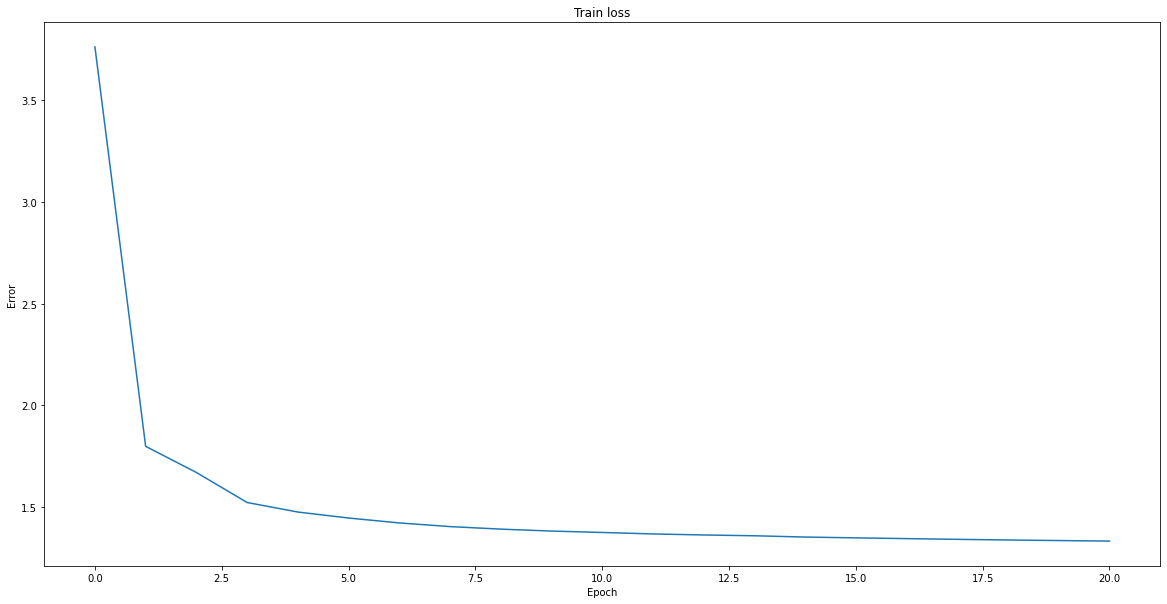

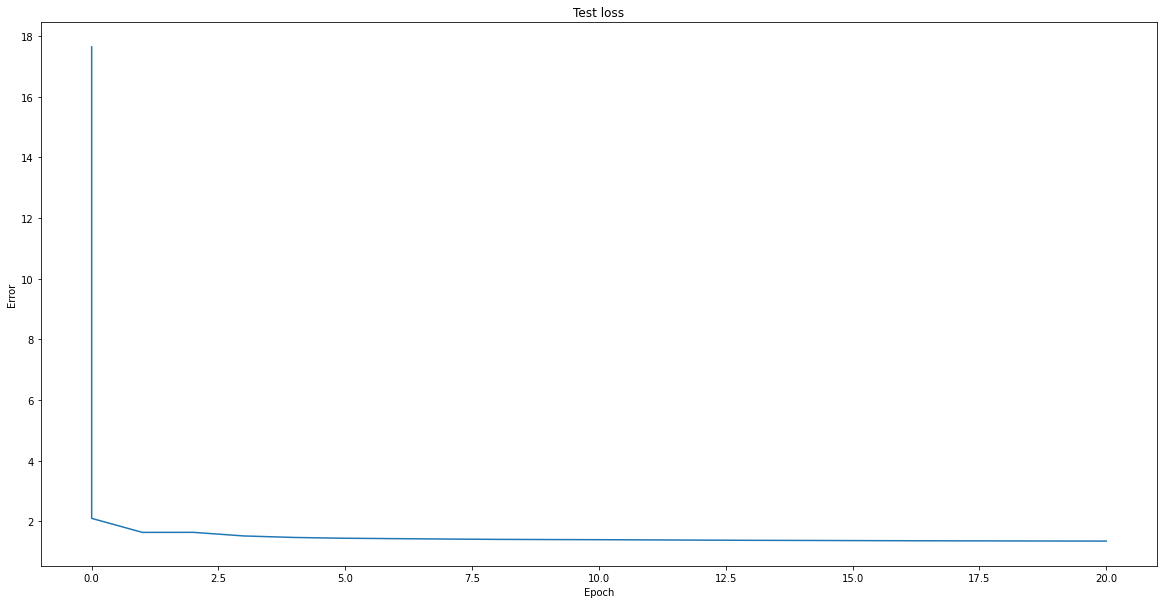

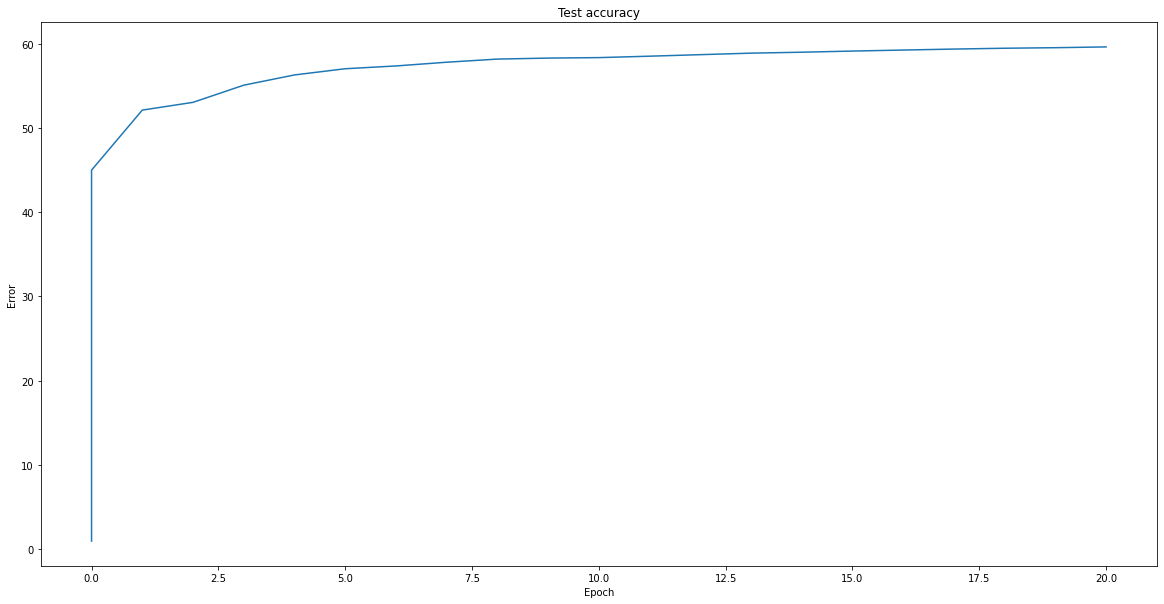

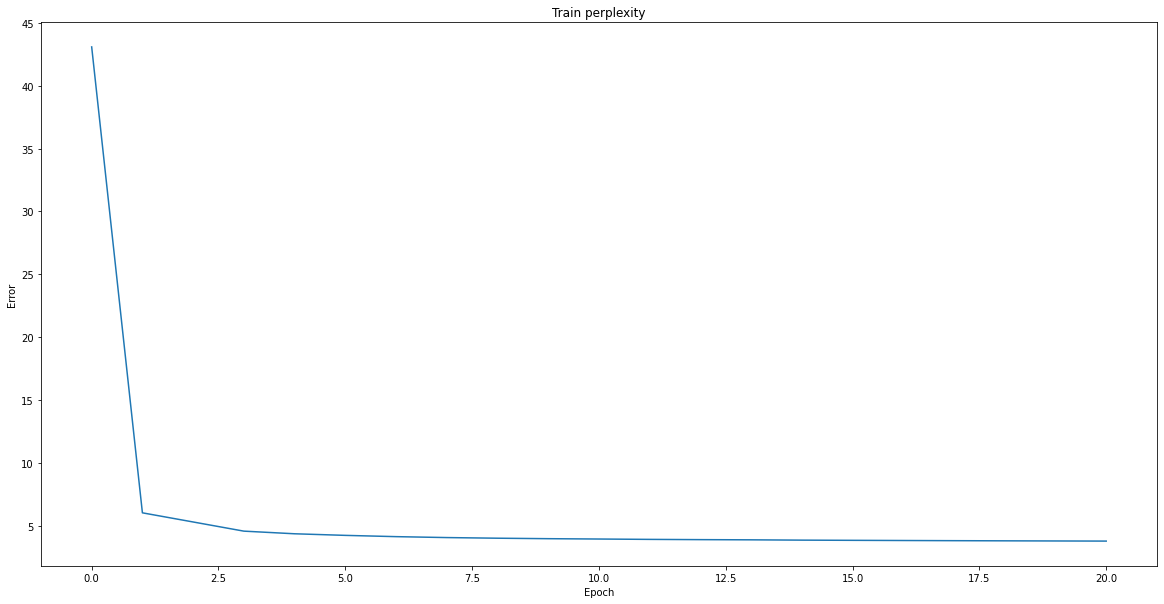

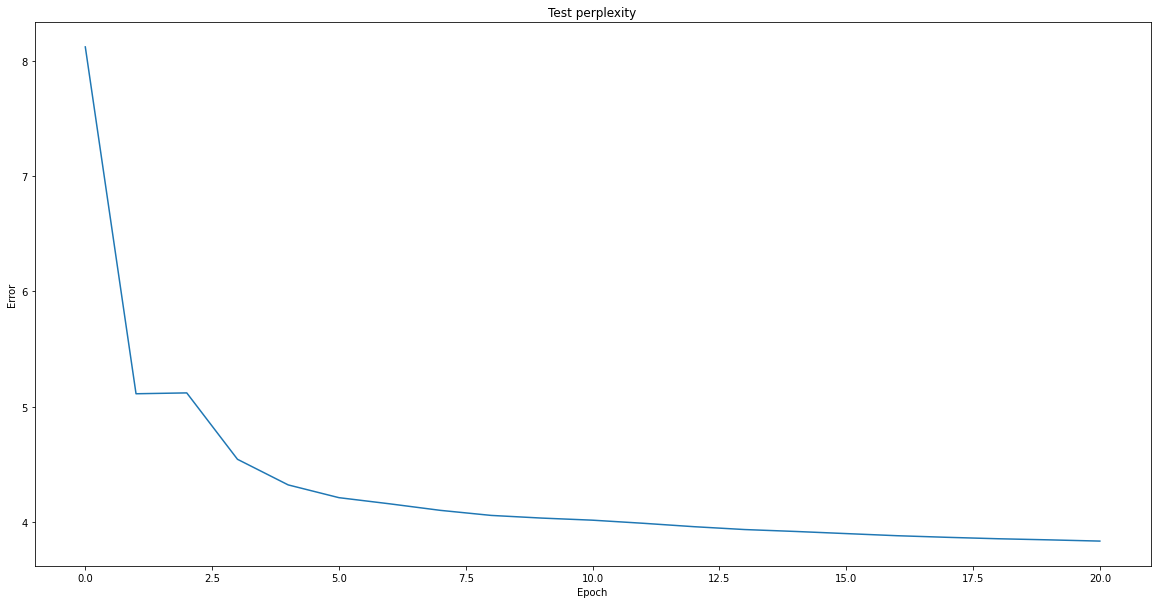

In [ ]:
!rm -r logs
!rm -r checkpoints
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False)#, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False)#, **kwargs)
    
    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies, train_perplexities, test_perplexities = pt_util.read_log(LOG_PATH, ([],[],[],[],[]))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))

            train_perplexity = np.exp(train_loss)
            test_perplexity = np.exp(test_loss)
            train_perplexities.append((epoch, train_perplexity))
            test_perplexities.append((epoch, test_perplexity))

            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies, train_perplexities, test_perplexities))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*train_perplexities)
        pt_util.plot(ep, val, 'Train perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_perplexities)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

#Part 7: Experiments

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'Tom Riddle laughs,'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Tom Riddle laughs, and said the started to the stairs and started to the stairs and started to the stairs and started to the stairs and started to the stairs and started to the stairs and started to the stairs and star
generated with sample	 Tom Riddle laughs, lying, and stone sluggly to the ear. Propher Never had sir-" not decied the back expered botter what was feet. Penty Ron a shelp shakwil party of and left that Mr. Fiddle turned to be all the right w
generated with sample	 Tom Riddle laughs, he had made voice mutted its tim, to the dircroll" but they to very excitection that it was so long. He was stoping it has back to her professor Mmbidge thought countrol us withXu Slughort -- bad she
generated with sample	 Tom Riddle laughs, a snak, "Professor sam loy he? gaved knoch I twin is you're do it?" said Harry acknos. "Eh, that you finally must be even to use dofing Apells elasing lay about it," said Ron completely. "I heard the
generated with sample	 Tom Riddle l

#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



# Train on different text corpus

In [ ]:
## Part 8
## Train on a different text corpus.
!rm -r logs
!rm -r checkpoints
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'sherlock_holmes.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')

def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    # replace all the whitespace characters with ' ' 
    data = re.sub('\s+', ' ', data)
    data.strip()
    
    voc2ind = {}
    tokens = []
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    seed = 0
    for char in data:
      # TODO Fill this in
      if char not in voc2ind:
        voc2ind[char] = seed
        seed += 1
      tokens.append(voc2ind[char])  

    ind2voc = {val: key for key, val in voc2ind.items()}
    
    # determine the place to separate training data and testing data
    tokens_len = len(tokens)
    pivot = int(0.8 * tokens_len)

    train_text = np.array(tokens[:pivot]) # TODO Fill this in
    test_text = np.array(tokens[pivot+1:]) # TODO Fill this in

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'sherlock_holmes_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'sherlock_holmes_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'sherlock_holmes.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'sherlock_holmes_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'sherlock_holmes_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False)#, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False)#, **kwargs)
    
    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies, train_perplexities, test_perplexities = pt_util.read_log(LOG_PATH, ([],[],[],[],[]))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))

            train_perplexity = np.exp(train_loss)
            test_perplexity = np.exp(test_loss)
            train_perplexities.append((epoch, train_perplexity))
            test_perplexities.append((epoch, test_perplexity))

            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies, train_perplexities, test_perplexities))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'sherlock drunks '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        return model, vocab, device

final_model, vocab, device = main()

Using device cuda
num workers: 2
Input	 births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now i
GT	births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now in
pred	àà&ß£r:àiZ£ààxfffxfr9ààzs0Zààxfr41££££àsiZRf&àiZ£ààxffrffàff&&zs0ààfffxZàr£££fß0&àèf£RRssffri[ààà2à6


Input	 that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water al
GT	that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water alw
pred	ààri3àiR6uRzàfi0àwiRZfs22K££à£r7x0wu14FàrffwfiffffZ6à0&s9AêàFFginJc77àir7x0wu14Fàrfwf[0àfrffNZ[fßàii




  2%|▏         | 2/97 [00:00<00:05, 18.76it/s]

Input	to give you the views I have formed first, and then you will be able to arrive at your own." He impr
GT	o give you the views I have formed first, and then you will be able to arrive at your own." He impre
pred	fàài6fff6u1àxrfff&fN0wnàrifffffß9f&àf&ß&&càiRsàfrfzà6u1àN2îGe½fài"yfàfààißß2fffffàxu1£ààl£RRàxfààààß



Test set: Average loss: 16.2765, Accuracy: 8107/640000 (1%)

Train Epoch: 0 [0/24832 (0%)]	Loss: 16.259132


 14%|█▍        | 14/97 [00:00<00:04, 18.54it/s]

Train Epoch: 0 [2560/24832 (10%)]	Loss: 13.627229


 25%|██▍       | 24/97 [00:01<00:03, 18.64it/s]

Train Epoch: 0 [5120/24832 (21%)]	Loss: 6.741950


 35%|███▌      | 34/97 [00:01<00:03, 18.59it/s]

Train Epoch: 0 [7680/24832 (31%)]	Loss: 4.311783


 45%|████▌     | 44/97 [00:02<00:02, 18.57it/s]

Train Epoch: 0 [10240/24832 (41%)]	Loss: 2.992461


 56%|█████▌    | 54/97 [00:02<00:02, 18.54it/s]

Train Epoch: 0 [12800/24832 (52%)]	Loss: 2.680845


 66%|██████▌   | 64/97 [00:03<00:01, 18.49it/s]

Train Epoch: 0 [15360/24832 (62%)]	Loss: 2.460523


 76%|███████▋  | 74/97 [00:03<00:01, 18.76it/s]

Train Epoch: 0 [17920/24832 (72%)]	Loss: 2.536896


 87%|████████▋ | 84/97 [00:04<00:00, 18.55it/s]

Train Epoch: 0 [20480/24832 (82%)]	Loss: 2.472477


 97%|█████████▋| 94/97 [00:05<00:00, 18.42it/s]

Train Epoch: 0 [23040/24832 (93%)]	Loss: 2.228691


100%|██████████| 97/97 [00:05<00:00, 18.60it/s]


Input	 births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now i
GT	births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now in
pred	weses  b d bf tese hres.   ar surld y tor e ew d bf the se n v.  af trr desdsr e Hhael edwheb so  ss


Input	 that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water al
GT	that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water alw
pred	ahet s d n  wad befd r -fot taa heauld baabaare b   herh " "Ixcll y  Tea weauld baa h  whe bas   w l


Input	to give you the views I have formed first, and then you will be able to arrive at your own." He impr
GT	o give you the views I have formed first, and then you will be able to arrive at your own." He impre
pred	h srve aeu she sess  a wade bor    trre   and Ihe  teu satl te f oa ah s reee w  hou  efn   "e wssae



Test set: Average loss: 2.2901, Accuracy: 

  2%|▏         | 2/97 [00:00<00:05, 17.23it/s]

generated beam		 sherlock drunks what here was a been the saw all be for ever here was a been the saw all be for ever here was a been the saw all be for ever here was a been the saw all be for ever here was a been the saw all be for 

Train Epoch: 1 [0/24832 (0%)]	Loss: 2.256723


 14%|█▍        | 14/97 [00:00<00:04, 18.37it/s]

Train Epoch: 1 [2560/24832 (10%)]	Loss: 2.160310


 25%|██▍       | 24/97 [00:01<00:03, 18.42it/s]

Train Epoch: 1 [5120/24832 (21%)]	Loss: 2.321929


 35%|███▌      | 34/97 [00:01<00:03, 18.47it/s]

Train Epoch: 1 [7680/24832 (31%)]	Loss: 2.291263


 45%|████▌     | 44/97 [00:02<00:02, 18.46it/s]

Train Epoch: 1 [10240/24832 (41%)]	Loss: 2.251149


 56%|█████▌    | 54/97 [00:02<00:02, 18.58it/s]

Train Epoch: 1 [12800/24832 (52%)]	Loss: 2.335467


 66%|██████▌   | 64/97 [00:03<00:01, 18.61it/s]

Train Epoch: 1 [15360/24832 (62%)]	Loss: 2.047030


 76%|███████▋  | 74/97 [00:04<00:01, 17.76it/s]

Train Epoch: 1 [17920/24832 (72%)]	Loss: 2.116376


 87%|████████▋ | 84/97 [00:04<00:00, 18.37it/s]

Train Epoch: 1 [20480/24832 (82%)]	Loss: 2.292305


 97%|█████████▋| 94/97 [00:05<00:00, 18.45it/s]

Train Epoch: 1 [23040/24832 (93%)]	Loss: 1.975550


100%|██████████| 97/97 [00:05<00:00, 18.27it/s]


Input	 births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now i
GT	births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now in
pred	hel    ond tn tiue tteng   ar hourd y orrye  tnd rn the caan vg  of hor dirdrr e Hhaetdertoet Iot hn


Input	 that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water al
GT	that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water alw
pred	ahet t d ng ood casd r -wut toi ceould harcaate a d terhe" "Ixcct y  Tha heould har""  aoe cos d ttl


Input	to give you the views I have formed first, and then you will be able to arrive at your own." He impr
GT	o give you the views I have formed first, and then you will be able to arrive at your own." He impre
pred	o sove tou soe calr  a rave aor    tor    tnd the  aou soll se anoiaao t eeee tt tou  ofn   "e rspae



Test set: Average loss: 1.8915, Accuracy: 

  2%|▏         | 2/97 [00:00<00:05, 18.67it/s]

generated beam		 sherlock drunks the could have a conly the drive to the could not the could not the could not the could not the could not the could not the could not the could not the could not the could not the could not the could 

Train Epoch: 2 [0/24832 (0%)]	Loss: 1.867880


 14%|█▍        | 14/97 [00:00<00:04, 18.61it/s]

Train Epoch: 2 [2560/24832 (10%)]	Loss: 1.769932


 25%|██▍       | 24/97 [00:01<00:03, 18.44it/s]

Train Epoch: 2 [5120/24832 (21%)]	Loss: 1.861602


 35%|███▌      | 34/97 [00:01<00:03, 18.52it/s]

Train Epoch: 2 [7680/24832 (31%)]	Loss: 1.865951


 45%|████▌     | 44/97 [00:02<00:02, 18.47it/s]

Train Epoch: 2 [10240/24832 (41%)]	Loss: 1.862217


 56%|█████▌    | 54/97 [00:02<00:02, 18.37it/s]

Train Epoch: 2 [12800/24832 (52%)]	Loss: 1.858373


 66%|██████▌   | 64/97 [00:03<00:01, 18.66it/s]

Train Epoch: 2 [15360/24832 (62%)]	Loss: 2.032005


 76%|███████▋  | 74/97 [00:03<00:01, 18.48it/s]

Train Epoch: 2 [17920/24832 (72%)]	Loss: 1.772207


 87%|████████▋ | 84/97 [00:04<00:00, 18.50it/s]

Train Epoch: 2 [20480/24832 (82%)]	Loss: 1.727606


 97%|█████████▋| 94/97 [00:05<00:00, 18.37it/s]

Train Epoch: 2 [23040/24832 (93%)]	Loss: 1.735944


100%|██████████| 97/97 [00:05<00:00, 18.54it/s]


Input	 births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now i
GT	births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now in
pred	tete   ond tf tise tteng   af toultry ooyde .wnd tf the watt.ng  of toretesdrret Ihaenderooet tot st


Input	 that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water al
GT	that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water alw
pred	ohet t d ne ood bind r -tot tae hhould barwofve t d thlns" "Ixcctly  Iha whould bar""  whe taser tnl


Input	to give you the views I have formed first, and then you will be able to arrive at your own." He impr
GT	o give you the views I have formed first, and then you will be able to arrive at your own." He impre
pred	o tove tou the telw  a wave tou    tonet  tnd the  wou will se t oe to t eeee tn tou  ofn   "e wspoe



Test set: Average loss: 1.7166, Accuracy: 

  2%|▏         | 2/97 [00:00<00:05, 17.08it/s]

generated beam		 sherlock drunks which he had been the could here was a sined the was a singular possible the was a sinerving the for the for the for the for the for the for the for the for the for the for the for the for the for the

Train Epoch: 3 [0/24832 (0%)]	Loss: 1.685267


 14%|█▍        | 14/97 [00:00<00:04, 18.03it/s]

Train Epoch: 3 [2560/24832 (10%)]	Loss: 1.710873


 25%|██▍       | 24/97 [00:01<00:03, 18.39it/s]

Train Epoch: 3 [5120/24832 (21%)]	Loss: 1.698266


 35%|███▌      | 34/97 [00:01<00:03, 18.62it/s]

Train Epoch: 3 [7680/24832 (31%)]	Loss: 1.727573


 45%|████▌     | 44/97 [00:02<00:02, 18.59it/s]

Train Epoch: 3 [10240/24832 (41%)]	Loss: 1.759079


 56%|█████▌    | 54/97 [00:02<00:02, 18.42it/s]

Train Epoch: 3 [12800/24832 (52%)]	Loss: 1.883022


 66%|██████▌   | 64/97 [00:03<00:01, 18.52it/s]

Train Epoch: 3 [15360/24832 (62%)]	Loss: 1.910141


 76%|███████▋  | 74/97 [00:04<00:01, 18.37it/s]

Train Epoch: 3 [17920/24832 (72%)]	Loss: 1.739067


 87%|████████▋ | 84/97 [00:04<00:00, 18.54it/s]

Train Epoch: 3 [20480/24832 (82%)]	Loss: 1.690674


 97%|█████████▋| 94/97 [00:05<00:00, 18.67it/s]

Train Epoch: 3 [23040/24832 (93%)]	Loss: 1.648131


100%|██████████| 97/97 [00:05<00:00, 18.47it/s]


Input	 births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now i
GT	births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now in
pred	hele   ond sf tire,treng   ar tourtry oeyke swnd tf the wott ng  of toremerder t Ihaep e ooet Io  an


Input	 that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water al
GT	that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water alw
pred	ohet t   ne oed bitg r -tot wha hhould harwofve t  tttrns  "Ixcctly  Tea whould har""  whe woser o l


Input	to give you the views I have formed first, and then you will be able to arrive at your own." He impr
GT	o give you the views I have formed first, and then you will be able to arrive at your own." He impre
pred	o tove tou woa welw  a wave aor  d tonst  and Ihe  wou woll we w oe to t eese a  tou  wfn   "e wspoe



Test set: Average loss: 1.6416, Accuracy: 

  2%|▏         | 2/97 [00:00<00:05, 18.81it/s]

generated beam		 sherlock drunks which had been the could have been the could have been the could have been the could have been the could have been the could have been the could have been the could have been the could have been the c

Train Epoch: 4 [0/24832 (0%)]	Loss: 1.607770


 14%|█▍        | 14/97 [00:00<00:04, 18.52it/s]

Train Epoch: 4 [2560/24832 (10%)]	Loss: 1.613497


 25%|██▍       | 24/97 [00:01<00:03, 18.52it/s]

Train Epoch: 4 [5120/24832 (21%)]	Loss: 1.606191


 35%|███▌      | 34/97 [00:01<00:03, 18.62it/s]

Train Epoch: 4 [7680/24832 (31%)]	Loss: 1.585733


 45%|████▌     | 44/97 [00:02<00:02, 18.45it/s]

Train Epoch: 4 [10240/24832 (41%)]	Loss: 1.595162


 56%|█████▌    | 54/97 [00:02<00:02, 18.46it/s]

Train Epoch: 4 [12800/24832 (52%)]	Loss: 1.651896


 66%|██████▌   | 64/97 [00:03<00:01, 18.26it/s]

Train Epoch: 4 [15360/24832 (62%)]	Loss: 1.757343


 76%|███████▋  | 74/97 [00:03<00:01, 18.42it/s]

Train Epoch: 4 [17920/24832 (72%)]	Loss: 1.652726


 87%|████████▋ | 84/97 [00:04<00:00, 18.76it/s]

Train Epoch: 4 [20480/24832 (82%)]	Loss: 1.628938


 97%|█████████▋| 94/97 [00:05<00:00, 18.52it/s]

Train Epoch: 4 [23040/24832 (93%)]	Loss: 1.596853


100%|██████████| 97/97 [00:05<00:00, 18.56it/s]


Input	 births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now i
GT	births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now in
pred	tetey  ond sf tiue hreng   br tourtry oeyye sond su the sott og  of toreairdrr t Ihoen e ooet Io  st


Input	 that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water al
GT	that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water alw
pred	ooet t   ne oid bise d -tot whi hheuld harwofse o   ohnns  "Ixcctly  Tee whould har""  woe doser onl


Input	to give you the views I have formed first, and then you will be able to arrive at your own." He impr
GT	o give you the views I have formed first, and then you will be able to arrive at your own." He impre
pred	o teve tou woa wesw  o wave aor ed tonst  tnd Ihe  tou well se w oe to t eeve a  tou  wfn   "e sspoe



Test set: Average loss: 1.6127, Accuracy: 

  2%|▏         | 2/97 [00:00<00:05, 18.80it/s]

generated beam		 sherlock drunks which he had some to do was a struck to the book of the struggest of the boothing of the struggest of the boothing of the struggest of the boothing of the struggest of the boothing of the struggest of

Train Epoch: 5 [0/24832 (0%)]	Loss: 1.575230


 14%|█▍        | 14/97 [00:00<00:04, 18.54it/s]

Train Epoch: 5 [2560/24832 (10%)]	Loss: 1.622693


 25%|██▍       | 24/97 [00:01<00:03, 18.62it/s]

Train Epoch: 5 [5120/24832 (21%)]	Loss: 1.612056


 33%|███▎      | 32/97 [00:01<00:03, 18.56it/s]

Train Epoch: 5 [7680/24832 (31%)]	Loss: 1.608702


 45%|████▌     | 44/97 [00:02<00:02, 18.05it/s]

Train Epoch: 5 [10240/24832 (41%)]	Loss: 1.667157


 56%|█████▌    | 54/97 [00:02<00:02, 18.41it/s]

Train Epoch: 5 [12800/24832 (52%)]	Loss: 1.644133


 66%|██████▌   | 64/97 [00:03<00:01, 18.52it/s]

Train Epoch: 5 [15360/24832 (62%)]	Loss: 1.692561


 76%|███████▋  | 74/97 [00:04<00:01, 18.64it/s]

Train Epoch: 5 [17920/24832 (72%)]	Loss: 1.551695


 87%|████████▋ | 84/97 [00:04<00:00, 18.45it/s]

Train Epoch: 5 [20480/24832 (82%)]	Loss: 1.545061


 97%|█████████▋| 94/97 [00:05<00:00, 18.51it/s]

Train Epoch: 5 [23040/24832 (93%)]	Loss: 1.554348


100%|██████████| 97/97 [00:05<00:00, 18.41it/s]


Input	 births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now i
GT	births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now in
pred	autdy  ond sf tiue,aaeng   af tourtry ooyge.sord tf the waat cg  of toreaardrr.t Ihael erooat Io  at


Input	 that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water al
GT	that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water alw
pred	ohet t y ne oad bose d -tut waa hhauld harwofve o  tohnns  "Ixactly  "ha whould har "  wha tasereonl


Input	to give you the views I have formed first, and then you will be able to arrive at your own." He impr
GT	o give you the views I have formed first, and then you will be able to arrive at your own." He impre
pred	o tove tou aha wasw  a aave aou ed tonst  and Ihe  wourwall ae a oe to t eeve a  tou  wfn   "e wspoe



Test set: Average loss: 1.5853, Accuracy: 

  2%|▏         | 2/97 [00:00<00:05, 17.08it/s]

generated beam		 sherlock drunks what a man was a sure of the father and of the was a law a man was a sure of the father and of the was a law a man was a sure of the father and of the was a law a man was a sure of the father and of t

Train Epoch: 6 [0/24832 (0%)]	Loss: 1.544685


 14%|█▍        | 14/97 [00:00<00:04, 18.60it/s]

Train Epoch: 6 [2560/24832 (10%)]	Loss: 1.727213


 25%|██▍       | 24/97 [00:01<00:03, 18.66it/s]

Train Epoch: 6 [5120/24832 (21%)]	Loss: 1.716031


 35%|███▌      | 34/97 [00:01<00:03, 18.75it/s]

Train Epoch: 6 [7680/24832 (31%)]	Loss: 1.609539


 45%|████▌     | 44/97 [00:02<00:02, 18.60it/s]

Train Epoch: 6 [10240/24832 (41%)]	Loss: 1.535958


 56%|█████▌    | 54/97 [00:02<00:02, 18.29it/s]

Train Epoch: 6 [12800/24832 (52%)]	Loss: 1.534164


 66%|██████▌   | 64/97 [00:03<00:01, 18.42it/s]

Train Epoch: 6 [15360/24832 (62%)]	Loss: 1.515731


 76%|███████▋  | 74/97 [00:03<00:01, 18.61it/s]

Train Epoch: 6 [17920/24832 (72%)]	Loss: 1.522350


 87%|████████▋ | 84/97 [00:04<00:00, 18.55it/s]

Train Epoch: 6 [20480/24832 (82%)]	Loss: 1.518005


 97%|█████████▋| 94/97 [00:05<00:00, 18.64it/s]

Train Epoch: 6 [23040/24832 (93%)]	Loss: 1.524809


100%|██████████| 97/97 [00:05<00:00, 18.59it/s]


Input	 births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now i
GT	births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now in
pred	tutd   ond sf tiue areng   af tourtry ooyge  ord tf the baat mg  af tor aardrr t Ihael e ohat Io  at


Input	 that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water al
GT	that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water alw
pred	ohat h   ne oad badd r btut wha hhauld ha wafve t   hhnn   "Ixactly  "ha hhould ha  "  wha taser a l


Input	to give you the views I have formed first, and then you will be able to arrive at your own." He impr
GT	o give you the views I have formed first, and then you will be able to arrive at your own." He impre
pred	h tove tou wha pasw  o have aor  d tonst  and the  wourwoll ae a oe th t eeve a  tou  hwn   "e wspoe



Test set: Average loss: 1.5490, Accuracy: 

  2%|▏         | 2/97 [00:00<00:05, 18.82it/s]

generated beam		 sherlock drunks which had been the could have been the come of the door and a law a man what had a been a for the for a man what had a been a for the for a man what had a been a for the for a man what had a been a fo

Train Epoch: 7 [0/24832 (0%)]	Loss: 1.505787


 14%|█▍        | 14/97 [00:00<00:04, 18.89it/s]

Train Epoch: 7 [2560/24832 (10%)]	Loss: 1.501003


 25%|██▍       | 24/97 [00:01<00:03, 18.65it/s]

Train Epoch: 7 [5120/24832 (21%)]	Loss: 1.489143


 35%|███▌      | 34/97 [00:01<00:03, 18.39it/s]

Train Epoch: 7 [7680/24832 (31%)]	Loss: 1.504863


 45%|████▌     | 44/97 [00:02<00:02, 18.85it/s]

Train Epoch: 7 [10240/24832 (41%)]	Loss: 1.534766


 56%|█████▌    | 54/97 [00:02<00:02, 18.53it/s]

Train Epoch: 7 [12800/24832 (52%)]	Loss: 1.515937


 66%|██████▌   | 64/97 [00:03<00:01, 18.53it/s]

Train Epoch: 7 [15360/24832 (62%)]	Loss: 1.503259


 76%|███████▋  | 74/97 [00:03<00:01, 18.57it/s]

Train Epoch: 7 [17920/24832 (72%)]	Loss: 1.478534


 87%|████████▋ | 84/97 [00:04<00:00, 18.44it/s]

Train Epoch: 7 [20480/24832 (82%)]	Loss: 1.497165


 97%|█████████▋| 94/97 [00:05<00:00, 18.81it/s]

Train Epoch: 7 [23040/24832 (93%)]	Loss: 1.489690


100%|██████████| 97/97 [00:05<00:00, 18.69it/s]


Input	 births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now i
GT	births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now in
pred	tutdy  and tf tire areng   ar tourtry ooygersond tf the baat cg  of tor tirdrr t Ihaelge ooat to  st


Input	 that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water al
GT	that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water alw
pred	ohat t y ne oad bose r btot wha hhauld ha wofve t   oenn   "Ixactly  "ha dhould ha  "  wha tascr onl


Input	to give you the views I have formed first, and then you will be able to arrive at your own." He impr
GT	o give you the views I have formed first, and then you will be able to arrive at your own." He impre
pred	o tove touraha tesw  o wave aor ed tonst  tnd the  tourwoll se a oe to t eeve a  tour cwn   "e wspoe



Test set: Average loss: 1.5183, Accuracy: 

  2%|▏         | 2/97 [00:00<00:05, 17.32it/s]

generated beam		 sherlock drunks which had been the could have been the corner of the door as a looking a strange of the booth of the corner of the corner of the corner of the corner of the corner of the corner of the corner of the c

Train Epoch: 8 [0/24832 (0%)]	Loss: 1.477570


 14%|█▍        | 14/97 [00:00<00:04, 18.40it/s]

Train Epoch: 8 [2560/24832 (10%)]	Loss: 1.494293


 25%|██▍       | 24/97 [00:01<00:03, 18.56it/s]

Train Epoch: 8 [5120/24832 (21%)]	Loss: 1.500926


 35%|███▌      | 34/97 [00:01<00:03, 18.60it/s]

Train Epoch: 8 [7680/24832 (31%)]	Loss: 1.503813


 45%|████▌     | 44/97 [00:02<00:02, 18.38it/s]

Train Epoch: 8 [10240/24832 (41%)]	Loss: 1.476496


 56%|█████▌    | 54/97 [00:02<00:02, 18.47it/s]

Train Epoch: 8 [12800/24832 (52%)]	Loss: 1.520050


 66%|██████▌   | 64/97 [00:03<00:01, 18.62it/s]

Train Epoch: 8 [15360/24832 (62%)]	Loss: 1.555156


 76%|███████▋  | 74/97 [00:03<00:01, 18.21it/s]

Train Epoch: 8 [17920/24832 (72%)]	Loss: 1.459178


 87%|████████▋ | 84/97 [00:04<00:00, 18.44it/s]

Train Epoch: 8 [20480/24832 (82%)]	Loss: 1.476193


 97%|█████████▋| 94/97 [00:05<00:00, 18.71it/s]

Train Epoch: 8 [23040/24832 (93%)]	Loss: 1.472430


100%|██████████| 97/97 [00:05<00:00, 18.55it/s]


Input	 births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now i
GT	births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now in
pred	tetd   and sf tiue areng   wr tourtry oayger ord tf the baat mg  of tor terdrr t Ihaepgerohat to  ss


Input	 that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water al
GT	that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water alw
pred	ohat t y ne wad bose r btot wha hhould ha cofve t   otnn   "Ixactly  "ha dhould ha  "  tha tascr o l


Input	to give you the views I have formed first, and then you will be able to arrive at your own." He impr
GT	o give you the views I have formed first, and then you will be able to arrive at your own." He impre
pred	o tove tourwha cesw  o have aor ed tonst  tnd the  tourwoll se a oe to t eeve a  tour hwn   "e wspoe



Test set: Average loss: 1.5017, Accuracy: 

  2%|▏         | 2/97 [00:00<00:07, 12.48it/s]

generated beam		 sherlock drunks which had been the come of the door as a looking the for the for the for the for the for the for the for the for the for the for the for the for the for the for the for the for the for the for the for

Train Epoch: 9 [0/24832 (0%)]	Loss: 1.460070


 14%|█▍        | 14/97 [00:00<00:04, 17.75it/s]

Train Epoch: 9 [2560/24832 (10%)]	Loss: 1.468189


 25%|██▍       | 24/97 [00:01<00:03, 18.48it/s]

Train Epoch: 9 [5120/24832 (21%)]	Loss: 1.481578


 35%|███▌      | 34/97 [00:01<00:03, 18.48it/s]

Train Epoch: 9 [7680/24832 (31%)]	Loss: 1.482013


 45%|████▌     | 44/97 [00:02<00:02, 18.74it/s]

Train Epoch: 9 [10240/24832 (41%)]	Loss: 1.505282


 56%|█████▌    | 54/97 [00:02<00:02, 18.29it/s]

Train Epoch: 9 [12800/24832 (52%)]	Loss: 1.496515


 66%|██████▌   | 64/97 [00:03<00:01, 18.50it/s]

Train Epoch: 9 [15360/24832 (62%)]	Loss: 1.459183


 76%|███████▋  | 74/97 [00:04<00:01, 18.59it/s]

Train Epoch: 9 [17920/24832 (72%)]	Loss: 1.436429


 87%|████████▋ | 84/97 [00:04<00:00, 18.58it/s]

Train Epoch: 9 [20480/24832 (82%)]	Loss: 1.460944


 97%|█████████▋| 94/97 [00:05<00:00, 18.48it/s]

Train Epoch: 9 [23040/24832 (93%)]	Loss: 1.462347


100%|██████████| 97/97 [00:05<00:00, 18.42it/s]


Input	 births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now i
GT	births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now in
pred	tetd   a d tf tiue areng   wr tourtry tayger wrd tf the caat mg  af tor terdrr   Ihaedgerlhat ho  as


Input	 that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water al
GT	that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water alw
pred	ohat h y ne wad bedd r btot hha hhauld ha hafve t d hhnn   "Ixactly. "ha,dhauld ha  "  hha tascr t l


Input	to give you the views I have formed first, and then you will be able to arrive at your own." He impr
GT	o give you the views I have formed first, and then you will be able to arrive at your own." He impre
pred	h teve tou hha celw  a have aor ed tonst  tnd the  wourwoll se a oe to t eeve a  tou  hwn   "e hspoe



Test set: Average loss: 1.4976, Accuracy: 

  2%|▏         | 2/97 [00:00<00:05, 18.40it/s]

generated beam		 sherlock drunks which had been the could have been the could have been the could have been the could have been the could have been the could have been the could have been the could have been the could have been the c

Train Epoch: 10 [0/24832 (0%)]	Loss: 1.455288


 14%|█▍        | 14/97 [00:00<00:04, 18.42it/s]

Train Epoch: 10 [2560/24832 (10%)]	Loss: 1.442198


 25%|██▍       | 24/97 [00:01<00:03, 18.44it/s]

Train Epoch: 10 [5120/24832 (21%)]	Loss: 1.440753


 35%|███▌      | 34/97 [00:01<00:03, 18.53it/s]

Train Epoch: 10 [7680/24832 (31%)]	Loss: 1.438321


 45%|████▌     | 44/97 [00:02<00:02, 18.59it/s]

Train Epoch: 10 [10240/24832 (41%)]	Loss: 1.430410


 56%|█████▌    | 54/97 [00:02<00:02, 18.63it/s]

Train Epoch: 10 [12800/24832 (52%)]	Loss: 1.457050


 66%|██████▌   | 64/97 [00:03<00:01, 18.60it/s]

Train Epoch: 10 [15360/24832 (62%)]	Loss: 1.465709


 76%|███████▋  | 74/97 [00:03<00:01, 18.61it/s]

Train Epoch: 10 [17920/24832 (72%)]	Loss: 1.412773


 87%|████████▋ | 84/97 [00:04<00:00, 18.75it/s]

Train Epoch: 10 [20480/24832 (82%)]	Loss: 1.439425


 97%|█████████▋| 94/97 [00:05<00:00, 18.65it/s]

Train Epoch: 10 [23040/24832 (93%)]	Loss: 1.443103


100%|██████████| 97/97 [00:05<00:00, 18.64it/s]


Input	 births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now i
GT	births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now in
pred	tetd   and tf tiue aueng   ar tourtry tayger ord tf the faat mg  af tor tardrr   Ihaedge ahat Io  as


Input	 that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water al
GT	that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water alw
pred	ohat t d ne wad bede r btot wha hhauld ha wofve t d otnns  "Ixactly. "ha,dhauld ha  "  tha tascr o l


Input	to give you the views I have formed first, and then you will be able to arrive at your own." He impr
GT	o give you the views I have formed first, and then you will be able to arrive at your own." He impre
pred	h tove tou aha celw  o have aor ed tonst  tnd the  tourwoll se a oe to t eeve a  tou  hwn   "e wspoe



Test set: Average loss: 1.4814, Accuracy: 

  2%|▏         | 2/97 [00:00<00:05, 17.84it/s]

generated beam		 sherlock drunks what had a little for the face was a passed a boot a boot a strange of the facts. The was a large a face was a strange of the face was a strange of the face was a strange of the face was a man who had

Train Epoch: 11 [0/24832 (0%)]	Loss: 1.440096


 14%|█▍        | 14/97 [00:00<00:04, 18.35it/s]

Train Epoch: 11 [2560/24832 (10%)]	Loss: 1.431902


 25%|██▍       | 24/97 [00:01<00:03, 18.33it/s]

Train Epoch: 11 [5120/24832 (21%)]	Loss: 1.431592


 35%|███▌      | 34/97 [00:01<00:03, 18.46it/s]

Train Epoch: 11 [7680/24832 (31%)]	Loss: 1.426204


 45%|████▌     | 44/97 [00:02<00:02, 18.54it/s]

Train Epoch: 11 [10240/24832 (41%)]	Loss: 1.419017


 56%|█████▌    | 54/97 [00:02<00:02, 18.58it/s]

Train Epoch: 11 [12800/24832 (52%)]	Loss: 1.452287


 66%|██████▌   | 64/97 [00:03<00:01, 18.66it/s]

Train Epoch: 11 [15360/24832 (62%)]	Loss: 1.527822


 76%|███████▋  | 74/97 [00:03<00:01, 18.82it/s]

Train Epoch: 11 [17920/24832 (72%)]	Loss: 1.457897


 87%|████████▋ | 84/97 [00:04<00:00, 18.63it/s]

Train Epoch: 11 [20480/24832 (82%)]	Loss: 1.440123


 97%|█████████▋| 94/97 [00:05<00:00, 18.59it/s]

Train Epoch: 11 [23040/24832 (93%)]	Loss: 1.433965


100%|██████████| 97/97 [00:05<00:00, 18.58it/s]


Input	 births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now i
GT	births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now in
pred	tetd   and tf tiue aueng   wr hourtry oayger ord tf the waat mg  of trr airdrr   Ihredgerwhat Io  ws


Input	 that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water al
GT	that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water alw
pred	ohat I y ne wad bedd r btot whi hhould ha wofve t   whnn   "Inactly. "ha,dhould ha  "  who taycr o l


Input	to give you the views I have formed first, and then you will be able to arrive at your own." He impr
GT	o give you the views I have formed first, and then you will be able to arrive at your own." He impre
pred	h tove tou wharfelw  o have aor ed trnst  tnd ther wourwoll se a oe to t rive a  tou  hwn   "e wspoe



Test set: Average loss: 1.4698, Accuracy: 

  2%|▏         | 2/97 [00:00<00:05, 18.75it/s]

generated beam		 sherlock drunks which had been the door of the day and we were the could have been the facts of the facts of the facts of the facts of the facts of the facts of the facts of the facts of the facts of the facts of the

Train Epoch: 12 [0/24832 (0%)]	Loss: 1.428270


 14%|█▍        | 14/97 [00:00<00:04, 18.64it/s]

Train Epoch: 12 [2560/24832 (10%)]	Loss: 1.414257


 25%|██▍       | 24/97 [00:01<00:03, 18.79it/s]

Train Epoch: 12 [5120/24832 (21%)]	Loss: 1.412651


 35%|███▌      | 34/97 [00:01<00:03, 18.55it/s]

Train Epoch: 12 [7680/24832 (31%)]	Loss: 1.412853


 45%|████▌     | 44/97 [00:02<00:02, 18.57it/s]

Train Epoch: 12 [10240/24832 (41%)]	Loss: 1.416403


 56%|█████▌    | 54/97 [00:02<00:02, 18.42it/s]

Train Epoch: 12 [12800/24832 (52%)]	Loss: 1.420291


 66%|██████▌   | 64/97 [00:03<00:01, 18.55it/s]

Train Epoch: 12 [15360/24832 (62%)]	Loss: 1.433585


 76%|███████▋  | 74/97 [00:03<00:01, 18.61it/s]

Train Epoch: 12 [17920/24832 (72%)]	Loss: 1.385939


 87%|████████▋ | 84/97 [00:04<00:00, 18.52it/s]

Train Epoch: 12 [20480/24832 (82%)]	Loss: 1.423009


 95%|█████████▍| 92/97 [00:05<00:00, 15.98it/s]

Train Epoch: 12 [23040/24832 (93%)]	Loss: 1.420031


100%|██████████| 97/97 [00:05<00:00, 18.43it/s]


Input	 births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now i
GT	births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now in
pred	tetd   a d sf tiue aueng   wr hourtry oayger ord tf the waat mg  of tor airdrr   Ihhedgerwhet ho  ws


Input	 that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water al
GT	that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water alw
pred	ohat I y ne wad bede r btot wha hhould ha wofve t d oenn   "Inactly,""ha,dhould ha  "  whe faycr o l


Input	to give you the views I have formed first, and then you will be able to arrive at your own." He impr
GT	o give you the views I have formed first, and then you will be able to arrive at your own." He impre
pred	o tove you wha felw  o have aor ed tonst  tnd the  wou woll se a oe to t eeve a  tou  hwn   "e wspoe



Test set: Average loss: 1.4656, Accuracy: 

  2%|▏         | 2/97 [00:00<00:05, 17.22it/s]

generated beam		 sherlock drunks which had been the door of the day, and we were all the face was a look a boot a bad of a look a bad a look a bad a look a bad a look a bad a look a bad a look a bad a look a bad a look a bad a look a

Train Epoch: 13 [0/24832 (0%)]	Loss: 1.426461


 14%|█▍        | 14/97 [00:00<00:04, 18.39it/s]

Train Epoch: 13 [2560/24832 (10%)]	Loss: 1.412964


 25%|██▍       | 24/97 [00:01<00:03, 18.46it/s]

Train Epoch: 13 [5120/24832 (21%)]	Loss: 1.404741


 35%|███▌      | 34/97 [00:01<00:03, 18.47it/s]

Train Epoch: 13 [7680/24832 (31%)]	Loss: 1.403010


 45%|████▌     | 44/97 [00:02<00:02, 18.44it/s]

Train Epoch: 13 [10240/24832 (41%)]	Loss: 1.421791


 56%|█████▌    | 54/97 [00:02<00:02, 18.56it/s]

Train Epoch: 13 [12800/24832 (52%)]	Loss: 1.417451


 66%|██████▌   | 64/97 [00:03<00:01, 18.69it/s]

Train Epoch: 13 [15360/24832 (62%)]	Loss: 1.431952


 76%|███████▋  | 74/97 [00:03<00:01, 18.49it/s]

Train Epoch: 13 [17920/24832 (72%)]	Loss: 1.397226


 87%|████████▋ | 84/97 [00:04<00:00, 18.56it/s]

Train Epoch: 13 [20480/24832 (82%)]	Loss: 1.408907


 97%|█████████▋| 94/97 [00:05<00:00, 18.47it/s]

Train Epoch: 13 [23040/24832 (93%)]	Loss: 1.410848


100%|██████████| 97/97 [00:05<00:00, 18.56it/s]


Input	 births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now i
GT	births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now in
pred	hetd   a d af tiue aueng   ar hourtry aayger ord tf the waat mg  of trr aimdrr   Ihhepgerwhet ho  as


Input	 that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water al
GT	that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water alw
pred	ohat I y ne wad bedeed btut hha hhould ha hofve t   oenn   "Inactly  "ha,dhould ha  "  whe laycr o l


Input	to give you the views I have formed first, and then you will be able to arrive at your own." He impr
GT	o give you the views I have formed first, and then you will be able to arrive at your own." He impre
pred	h hove you aha melw  o have aor ed trnst  tnd the  wou will se a oe to t reve a  tou  hwn   "e hspoe



Test set: Average loss: 1.4527, Accuracy: 

  2%|▏         | 2/97 [00:00<00:04, 19.08it/s]

generated beam		 sherlock drunks which had been the dark of his hands and a look a paper from the facts which had been the dark of his hands and had a little dropped his hands and a look a paper from the facts which had been the dark

Train Epoch: 14 [0/24832 (0%)]	Loss: 1.412567


 14%|█▍        | 14/97 [00:00<00:04, 18.76it/s]

Train Epoch: 14 [2560/24832 (10%)]	Loss: 1.397009


 25%|██▍       | 24/97 [00:01<00:03, 18.55it/s]

Train Epoch: 14 [5120/24832 (21%)]	Loss: 1.403666


 35%|███▌      | 34/97 [00:01<00:03, 18.52it/s]

Train Epoch: 14 [7680/24832 (31%)]	Loss: 1.395264


 45%|████▌     | 44/97 [00:02<00:02, 18.34it/s]

Train Epoch: 14 [10240/24832 (41%)]	Loss: 1.412743


 56%|█████▌    | 54/97 [00:02<00:02, 18.51it/s]

Train Epoch: 14 [12800/24832 (52%)]	Loss: 1.402020


 66%|██████▌   | 64/97 [00:03<00:01, 18.56it/s]

Train Epoch: 14 [15360/24832 (62%)]	Loss: 1.412159


 76%|███████▋  | 74/97 [00:03<00:01, 18.46it/s]

Train Epoch: 14 [17920/24832 (72%)]	Loss: 1.373692


 87%|████████▋ | 84/97 [00:04<00:00, 18.66it/s]

Train Epoch: 14 [20480/24832 (82%)]	Loss: 1.399915


 97%|█████████▋| 94/97 [00:05<00:00, 18.49it/s]

Train Epoch: 14 [23040/24832 (93%)]	Loss: 1.405386


100%|██████████| 97/97 [00:05<00:00, 18.61it/s]


Input	 births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now i
GT	births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now in
pred	hetd   and tf tiue aueng   ar hourtry aayger ord tf the waat mg  of trr airdrr   Ihhecgerahet ho  hs


Input	 that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water al
GT	that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water alw
pred	ohet I y ne wad bedeed btut hhe hhould ha wefve t   oenn   "Inactly. "ha,dhould ha  "  whe laycr o l


Input	to give you the views I have formed first, and then you will be able to arrive at your own." He impr
GT	o give you the views I have formed first, and then you will be able to arrive at your own." He impre
pred	h heve you aha melw  o have aor ed trnst  tnd the  wou well se a le th t reve a  tou  hwn   "e hspoe



Test set: Average loss: 1.4553, Accuracy: 

  2%|▏         | 2/97 [00:00<00:04, 19.22it/s]

generated beam		 sherlock drunks and the room which had been the dark of his day and we were all the facts which had been the carriage of the last had been a crime a large and see which had been the carriage of the dark and the room 

Train Epoch: 15 [0/24832 (0%)]	Loss: 1.413708


 14%|█▍        | 14/97 [00:00<00:04, 18.60it/s]

Train Epoch: 15 [2560/24832 (10%)]	Loss: 1.393955


 25%|██▍       | 24/97 [00:01<00:03, 18.55it/s]

Train Epoch: 15 [5120/24832 (21%)]	Loss: 1.388214


 35%|███▌      | 34/97 [00:01<00:03, 18.48it/s]

Train Epoch: 15 [7680/24832 (31%)]	Loss: 1.389046


 45%|████▌     | 44/97 [00:02<00:02, 18.50it/s]

Train Epoch: 15 [10240/24832 (41%)]	Loss: 1.401989


 56%|█████▌    | 54/97 [00:02<00:02, 18.53it/s]

Train Epoch: 15 [12800/24832 (52%)]	Loss: 1.407093


 66%|██████▌   | 64/97 [00:03<00:01, 18.49it/s]

Train Epoch: 15 [15360/24832 (62%)]	Loss: 1.416263


 76%|███████▋  | 74/97 [00:03<00:01, 18.63it/s]

Train Epoch: 15 [17920/24832 (72%)]	Loss: 1.378613


 87%|████████▋ | 84/97 [00:04<00:00, 18.63it/s]

Train Epoch: 15 [20480/24832 (82%)]	Loss: 1.395269


 97%|█████████▋| 94/97 [00:05<00:00, 18.59it/s]

Train Epoch: 15 [23040/24832 (93%)]	Loss: 1.396116


100%|██████████| 97/97 [00:05<00:00, 18.61it/s]


Input	 births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now i
GT	births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now in
pred	hetd   and tf tiue,hueng   ar hourtry oayger ord tf the raat mg  of trr airdrr . "hhecgerahet ho  hs


Input	 that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water al
GT	that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water alw
pred	ohat I y ne wad bedeed btut hhi hhould ha hofve t   oenn   "Inactly.""ha,dhould ha  "  hhirraycr onl


Input	to give you the views I have formed first, and then you will be able to arrive at your own." He impr
GT	o give you the views I have formed first, and then you will be able to arrive at your own." He impre
pred	h tove you aharcelw  o have aor ed trnst  tnd ther wou will se a oe to t reve a  tou  cwn   "e hspoe



Test set: Average loss: 1.4323, Accuracy: 

  2%|▏         | 2/97 [00:00<00:05, 17.21it/s]

generated beam		 sherlock drunks which had been the room which had been the carriage of the carriage of the carriage of the room which had been the room which had been the carriage of the room which had been the carriage of the carri

Train Epoch: 16 [0/24832 (0%)]	Loss: 1.392463


 14%|█▍        | 14/97 [00:00<00:04, 18.31it/s]

Train Epoch: 16 [2560/24832 (10%)]	Loss: 1.382034


 25%|██▍       | 24/97 [00:01<00:03, 18.77it/s]

Train Epoch: 16 [5120/24832 (21%)]	Loss: 1.383001


 35%|███▌      | 34/97 [00:01<00:03, 18.59it/s]

Train Epoch: 16 [7680/24832 (31%)]	Loss: 1.377993


 45%|████▌     | 44/97 [00:02<00:02, 18.43it/s]

Train Epoch: 16 [10240/24832 (41%)]	Loss: 1.374563


 56%|█████▌    | 54/97 [00:02<00:02, 18.50it/s]

Train Epoch: 16 [12800/24832 (52%)]	Loss: 1.397812


 66%|██████▌   | 64/97 [00:03<00:01, 17.05it/s]

Train Epoch: 16 [15360/24832 (62%)]	Loss: 1.408532


 76%|███████▋  | 74/97 [00:04<00:01, 18.32it/s]

Train Epoch: 16 [17920/24832 (72%)]	Loss: 1.377679


 87%|████████▋ | 84/97 [00:04<00:00, 18.38it/s]

Train Epoch: 16 [20480/24832 (82%)]	Loss: 1.403853


 97%|█████████▋| 94/97 [00:05<00:00, 18.64it/s]

Train Epoch: 16 [23040/24832 (93%)]	Loss: 1.394455


100%|██████████| 97/97 [00:05<00:00, 18.33it/s]


Input	 births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now i
GT	births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now in
pred	tetd   ald tf tiue huena   ar tourtry oayger ord tf the roatimg  of trr tirdrr . "hhecgerahet ho  ts


Input	 that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water al
GT	that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water alw
pred	ohat I y ne wad bedeed btut hhe hhould ha hafve t   oenn   "Inactly.""ea,dhould ha  "  hherraycr oll


Input	to give you the views I have formed first, and then you will be able to arrive at your own." He impr
GT	o give you the views I have formed first, and then you will be able to arrive at your own." He impre
pred	h tove you tharmelw  o have aor ed trnst  tnd ther wou will se a oe to t reve a  tou  cwn   "e hspoe



Test set: Average loss: 1.4257, Accuracy: 

  2%|▏         | 2/97 [00:00<00:05, 18.25it/s]

generated beam		 sherlock drunks and the room which had been the carriage of the room which had been the carriage of the room which had been the room which had been the carriage of the room which had been the carriage of the room whi

Train Epoch: 17 [0/24832 (0%)]	Loss: 1.386164


 14%|█▍        | 14/97 [00:00<00:04, 18.54it/s]

Train Epoch: 17 [2560/24832 (10%)]	Loss: 1.376934


 25%|██▍       | 24/97 [00:01<00:03, 18.37it/s]

Train Epoch: 17 [5120/24832 (21%)]	Loss: 1.376391


 35%|███▌      | 34/97 [00:01<00:03, 18.76it/s]

Train Epoch: 17 [7680/24832 (31%)]	Loss: 1.371448


 45%|████▌     | 44/97 [00:02<00:02, 18.42it/s]

Train Epoch: 17 [10240/24832 (41%)]	Loss: 1.365451


 56%|█████▌    | 54/97 [00:02<00:02, 18.75it/s]

Train Epoch: 17 [12800/24832 (52%)]	Loss: 1.378337


 66%|██████▌   | 64/97 [00:03<00:01, 18.61it/s]

Train Epoch: 17 [15360/24832 (62%)]	Loss: 1.387025


 76%|███████▋  | 74/97 [00:03<00:01, 18.55it/s]

Train Epoch: 17 [17920/24832 (72%)]	Loss: 1.356487


 87%|████████▋ | 84/97 [00:04<00:00, 18.53it/s]

Train Epoch: 17 [20480/24832 (82%)]	Loss: 1.386064


 97%|█████████▋| 94/97 [00:05<00:00, 18.59it/s]

Train Epoch: 17 [23040/24832 (93%)]	Loss: 1.383614


100%|██████████| 97/97 [00:05<00:00, 18.59it/s]


Input	 births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now i
GT	births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now in
pred	tetd   and tf tiue huena   ar hourtry oorger ord tf the rorting  of tor airdrr . "hhecgerahet ho  hs


Input	 that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water al
GT	that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water alw
pred	ohat I   ne wad bedeed btut hhe hhould ha hofve t   oenn   "Inactly.""ha,dhould ha  "  hherroycr onl


Input	to give you the views I have formed first, and then you will be able to arrive at your own." He impr
GT	o give you the views I have formed first, and then you will be able to arrive at your own." He impre
pred	h tove you aharcelw  o have aor ed trnst  tnd ther wou woll se a oe to t reve a  tour cwn   "e hspoe



Test set: Average loss: 1.4221, Accuracy: 

  2%|▏         | 2/97 [00:00<00:05, 17.30it/s]

generated beam		 sherlock drunks of the room and the country of the country of the country of the country of the country of the country of the country of the country of the country of the country of the country of the country of the 

Train Epoch: 18 [0/24832 (0%)]	Loss: 1.383996


 14%|█▍        | 14/97 [00:00<00:04, 18.34it/s]

Train Epoch: 18 [2560/24832 (10%)]	Loss: 1.373633


 25%|██▍       | 24/97 [00:01<00:03, 18.53it/s]

Train Epoch: 18 [5120/24832 (21%)]	Loss: 1.411015


 35%|███▌      | 34/97 [00:01<00:03, 18.54it/s]

Train Epoch: 18 [7680/24832 (31%)]	Loss: 1.388417


 45%|████▌     | 44/97 [00:02<00:02, 18.64it/s]

Train Epoch: 18 [10240/24832 (41%)]	Loss: 1.363589


 56%|█████▌    | 54/97 [00:02<00:02, 18.53it/s]

Train Epoch: 18 [12800/24832 (52%)]	Loss: 1.374687


 66%|██████▌   | 64/97 [00:03<00:01, 18.60it/s]

Train Epoch: 18 [15360/24832 (62%)]	Loss: 1.377773


 76%|███████▋  | 74/97 [00:03<00:01, 18.43it/s]

Train Epoch: 18 [17920/24832 (72%)]	Loss: 1.350014


 87%|████████▋ | 84/97 [00:04<00:00, 18.48it/s]

Train Epoch: 18 [20480/24832 (82%)]	Loss: 1.374453


 97%|█████████▋| 94/97 [00:05<00:00, 18.56it/s]

Train Epoch: 18 [23040/24832 (93%)]	Loss: 1.384119


100%|██████████| 97/97 [00:05<00:00, 18.56it/s]


Input	 births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now i
GT	births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now in
pred	aetd   and tf tiue huena   ar tourtry aarger ard tf the raating  of trr aimdrr . "hhecgerahet ho  ws


Input	 that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water al
GT	that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water alw
pred	ohat I   ne wad bedded btut tha hhould ha wafve t   oenn   "Inactly.""ha,dhould ha  "  hhirraycr onl


Input	to give you the views I have formed first, and then you will be able to arrive at your own." He impr
GT	o give you the views I have formed first, and then you will be able to arrive at your own." He impre
pred	h tove you aharmelw  o have aor ed trnst  tnd ther aou will se a le to t reve a  tour cwn   "e hspre



Test set: Average loss: 1.4250, Accuracy: 

  2%|▏         | 2/97 [00:00<00:05, 18.56it/s]

generated beam		 sherlock drunks and the room which had been a carriage of the man who had been the carriage of the man who had been the carriage of the carriage of the man who had been the carriage of the man who had been the carria

Train Epoch: 19 [0/24832 (0%)]	Loss: 1.382953


 14%|█▍        | 14/97 [00:00<00:04, 18.48it/s]

Train Epoch: 19 [2560/24832 (10%)]	Loss: 1.369842


 25%|██▍       | 24/97 [00:01<00:03, 18.57it/s]

Train Epoch: 19 [5120/24832 (21%)]	Loss: 1.368685


 35%|███▌      | 34/97 [00:01<00:03, 18.27it/s]

Train Epoch: 19 [7680/24832 (31%)]	Loss: 1.356963


 45%|████▌     | 44/97 [00:02<00:02, 18.55it/s]

Train Epoch: 19 [10240/24832 (41%)]	Loss: 1.352476


 56%|█████▌    | 54/97 [00:02<00:02, 18.51it/s]

Train Epoch: 19 [12800/24832 (52%)]	Loss: 1.373773


 66%|██████▌   | 64/97 [00:03<00:01, 18.41it/s]

Train Epoch: 19 [15360/24832 (62%)]	Loss: 1.377993


 76%|███████▋  | 74/97 [00:03<00:01, 18.48it/s]

Train Epoch: 19 [17920/24832 (72%)]	Loss: 1.344864


 87%|████████▋ | 84/97 [00:04<00:00, 18.37it/s]

Train Epoch: 19 [20480/24832 (82%)]	Loss: 1.372675


 97%|█████████▋| 94/97 [00:05<00:00, 18.76it/s]

Train Epoch: 19 [23040/24832 (93%)]	Loss: 1.379450


100%|██████████| 97/97 [00:05<00:00, 18.55it/s]


Input	 births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now i
GT	births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now in
pred	tetd   and tf tire huena   ar tourtry aarger ond tf the caating  of trr aimdrr . "hhecgerahet to  ws


Input	 that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water al
GT	that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water alw
pred	ohat I y ne wad bedded btut tha hhould ha wifve t   otnn   "Inactly ""ha,dhould ha  "  hhirlaycr onl


Input	to give you the views I have formed first, and then you will be able to arrive at your own." He impr
GT	o give you the views I have formed first, and then you will be able to arrive at your own." He impre
pred	h tove tou tharmelw  o have aor ed trnst  tnd ther aou will se a le to t reve a  tour cwn   "e hspoe



Test set: Average loss: 1.4074, Accuracy: 

  2%|▏         | 2/97 [00:00<00:05, 18.58it/s]

generated beam		 sherlock drunks and the carriage of the man who had been the carriage of the man who had been the carriage of the man who had been the drawn and the carriage of the man who had been the carriage of the crime of the c

Train Epoch: 20 [0/24832 (0%)]	Loss: 1.367519


 14%|█▍        | 14/97 [00:00<00:04, 18.69it/s]

Train Epoch: 20 [2560/24832 (10%)]	Loss: 1.361290


 25%|██▍       | 24/97 [00:01<00:03, 18.54it/s]

Train Epoch: 20 [5120/24832 (21%)]	Loss: 1.363725


 35%|███▌      | 34/97 [00:01<00:03, 17.45it/s]

Train Epoch: 20 [7680/24832 (31%)]	Loss: 1.354968


 45%|████▌     | 44/97 [00:02<00:02, 18.47it/s]

Train Epoch: 20 [10240/24832 (41%)]	Loss: 1.364818


 56%|█████▌    | 54/97 [00:02<00:02, 18.50it/s]

Train Epoch: 20 [12800/24832 (52%)]	Loss: 1.379968


 66%|██████▌   | 64/97 [00:03<00:01, 18.79it/s]

Train Epoch: 20 [15360/24832 (62%)]	Loss: 1.384963


 76%|███████▋  | 74/97 [00:04<00:01, 18.52it/s]

Train Epoch: 20 [17920/24832 (72%)]	Loss: 1.338759


 87%|████████▋ | 84/97 [00:04<00:00, 18.52it/s]

Train Epoch: 20 [20480/24832 (82%)]	Loss: 1.367630


 97%|█████████▋| 94/97 [00:05<00:00, 18.48it/s]

Train Epoch: 20 [23040/24832 (93%)]	Loss: 1.369418


100%|██████████| 97/97 [00:05<00:00, 18.41it/s]


Input	 births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now i
GT	births and of homecomings, of country dances and of the meetings of fox hunters. Strange that now in
pred	tetd   and tf tire haena   ar tourtry aarger ond tf the caating  of trr aimdir . "hhecgerahet ti  ws


Input	 that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water al
GT	that anyone has landed--but why should he leave any sign?" "Exactly. Why should he? Is the water alw
pred	ohat i y ne wad bedded btut tha hhould ha wifve t   otnn   "Inactly ""ha dhould ha  "  hhi maycr onl


Input	to give you the views I have formed first, and then you will be able to arrive at your own." He impr
GT	o give you the views I have formed first, and then you will be able to arrive at your own." He impre
pred	h tove tou tha milw  o have aor ed trnst  tnd then aou will se a oe to t rave a  tour cwn   "e wspoe



Test set: Average loss: 1.3988, Accuracy: 

# LSTM

Using device cuda
num workers: 2
Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	ZZzzY?X"Z;MJe'fb?X99'AJJJhh*q????M(JCNzGA(o**bnH[oo6$f?JzJJJHH)HMKX%'HnHZ2eJY?(((zwynK"G1HkKX%'o`Jzz


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	KKXsf???M(H(Hzn(JCN=kJ9'$`Jzzwn7HPk?ff2ot(Z?'ezznQk6if%eEen(??MA(wMKHXXXs91nY?k??$hZZx'f???M(XXC%(HM


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	HzhhZAJV'o'oh"""eGMheL???M??''uHf((n???Mfkozf?uZ;MAY1xHE??h??(MKt?X'9JAJ(Xn(e(B2ezzhuuun?e(?eE??Jzzw


Input	elp,

  1%|          | 2/195 [00:00<00:12, 15.06it/s]


Test set: Average loss: 8.8981, Accuracy: 12291/1254400 (1%)

Train Epoch: 0 [0/49920 (0%)]	Loss: 8.862766


  7%|▋         | 14/195 [00:00<00:12, 14.90it/s]

Train Epoch: 0 [2560/49920 (5%)]	Loss: 4.378866


 12%|█▏        | 24/195 [00:01<00:11, 15.05it/s]

Train Epoch: 0 [5120/49920 (10%)]	Loss: 2.732339


 17%|█▋        | 34/195 [00:02<00:10, 14.92it/s]

Train Epoch: 0 [7680/49920 (15%)]	Loss: 2.318434


 23%|██▎       | 44/195 [00:02<00:09, 15.10it/s]

Train Epoch: 0 [10240/49920 (21%)]	Loss: 2.136516


 28%|██▊       | 54/195 [00:03<00:09, 14.79it/s]

Train Epoch: 0 [12800/49920 (26%)]	Loss: 2.027098


 33%|███▎      | 64/195 [00:04<00:08, 14.90it/s]

Train Epoch: 0 [15360/49920 (31%)]	Loss: 1.980466


 38%|███▊      | 74/195 [00:04<00:08, 14.93it/s]

Train Epoch: 0 [17920/49920 (36%)]	Loss: 1.929703


 43%|████▎     | 84/195 [00:05<00:07, 14.91it/s]

Train Epoch: 0 [20480/49920 (41%)]	Loss: 1.881390


 48%|████▊     | 94/195 [00:06<00:06, 14.92it/s]

Train Epoch: 0 [23040/49920 (46%)]	Loss: 1.865074


 53%|█████▎    | 104/195 [00:06<00:06, 14.83it/s]

Train Epoch: 0 [25600/49920 (51%)]	Loss: 1.834311


 58%|█████▊    | 114/195 [00:07<00:05, 14.82it/s]

Train Epoch: 0 [28160/49920 (56%)]	Loss: 1.797900


 64%|██████▎   | 124/195 [00:08<00:04, 14.69it/s]

Train Epoch: 0 [30720/49920 (62%)]	Loss: 1.800588


 69%|██████▊   | 134/195 [00:09<00:04, 14.73it/s]

Train Epoch: 0 [33280/49920 (67%)]	Loss: 1.783374


 74%|███████▍  | 144/195 [00:09<00:03, 14.78it/s]

Train Epoch: 0 [35840/49920 (72%)]	Loss: 1.764865


 79%|███████▉  | 154/195 [00:10<00:02, 14.82it/s]

Train Epoch: 0 [38400/49920 (77%)]	Loss: 1.735323


 84%|████████▍ | 164/195 [00:11<00:02, 14.78it/s]

Train Epoch: 0 [40960/49920 (82%)]	Loss: 1.711186


 89%|████████▉ | 174/195 [00:11<00:01, 14.83it/s]

Train Epoch: 0 [43520/49920 (87%)]	Loss: 1.696986


 94%|█████████▍| 184/195 [00:12<00:00, 14.84it/s]

Train Epoch: 0 [46080/49920 (92%)]	Loss: 1.672069


 99%|█████████▉| 194/195 [00:13<00:00, 14.86it/s]

Train Epoch: 0 [48640/49920 (97%)]	Loss: 1.669614


100%|██████████| 195/195 [00:13<00:00, 14.86it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 edthttthtttd toasdd t ain   the sone  othsk  "I w  tarre .  "e said  "Ion't tardi  wots  said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sid the sft d tane  and tarry aaap d tumbledore aeck an o the snk atet yed thet torl d the sooaene t


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	  ng tnd toecpeng tn the sageee tf the sore aashttnaaed tn tagw edd   "ir tf  tawriele torent tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:14, 13.77it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The said Harry and the started the started the started the started the started the started the started the started the was a stared the started the was a stared the started the started the started the

Train Epoch: 1 [0/49920 (0%)]	Loss: 1.679044


  7%|▋         | 14/195 [00:00<00:12, 14.59it/s]

Train Epoch: 1 [2560/49920 (5%)]	Loss: 1.669885


 12%|█▏        | 24/195 [00:01<00:11, 14.74it/s]

Train Epoch: 1 [5120/49920 (10%)]	Loss: 1.644256


 17%|█▋        | 34/195 [00:02<00:10, 14.88it/s]

Train Epoch: 1 [7680/49920 (15%)]	Loss: 1.653330


 23%|██▎       | 44/195 [00:02<00:10, 14.64it/s]

Train Epoch: 1 [10240/49920 (21%)]	Loss: 1.624859


 27%|██▋       | 52/195 [00:03<00:11, 12.80it/s]

Train Epoch: 1 [12800/49920 (26%)]	Loss: 1.607037


 33%|███▎      | 64/195 [00:04<00:08, 14.63it/s]

Train Epoch: 1 [15360/49920 (31%)]	Loss: 1.608336


 38%|███▊      | 74/195 [00:05<00:08, 14.80it/s]

Train Epoch: 1 [17920/49920 (36%)]	Loss: 1.594130


 43%|████▎     | 84/195 [00:05<00:07, 14.92it/s]

Train Epoch: 1 [20480/49920 (41%)]	Loss: 1.571041


 48%|████▊     | 94/195 [00:06<00:06, 14.96it/s]

Train Epoch: 1 [23040/49920 (46%)]	Loss: 1.578013


 53%|█████▎    | 104/195 [00:07<00:06, 14.87it/s]

Train Epoch: 1 [25600/49920 (51%)]	Loss: 1.575247


 58%|█████▊    | 114/195 [00:07<00:05, 14.89it/s]

Train Epoch: 1 [28160/49920 (56%)]	Loss: 1.553888


 64%|██████▎   | 124/195 [00:08<00:04, 14.81it/s]

Train Epoch: 1 [30720/49920 (62%)]	Loss: 1.556297


 69%|██████▊   | 134/195 [00:09<00:04, 14.83it/s]

Train Epoch: 1 [33280/49920 (67%)]	Loss: 1.571204


 74%|███████▍  | 144/195 [00:09<00:03, 14.89it/s]

Train Epoch: 1 [35840/49920 (72%)]	Loss: 1.557475


 79%|███████▉  | 154/195 [00:10<00:02, 14.84it/s]

Train Epoch: 1 [38400/49920 (77%)]	Loss: 1.544629


 84%|████████▍ | 164/195 [00:11<00:02, 14.88it/s]

Train Epoch: 1 [40960/49920 (82%)]	Loss: 1.527924


 89%|████████▉ | 174/195 [00:11<00:01, 14.90it/s]

Train Epoch: 1 [43520/49920 (87%)]	Loss: 1.516967


 94%|█████████▍| 184/195 [00:12<00:00, 15.02it/s]

Train Epoch: 1 [46080/49920 (92%)]	Loss: 1.504698


 99%|█████████▉| 194/195 [00:13<00:00, 14.89it/s]

Train Epoch: 1 [48640/49920 (97%)]	Loss: 1.512636


100%|██████████| 195/195 [00:13<00:00, 14.79it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 eet toghttnd seardd tnain,t the sare  otask  "I ws tarri .  "e said  "Ion't bauky, toti  said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	s d the stt d tare  tnd sarry waap d aumbledore aeck tn o the ssk woer yer ahet horl d ahe saeaeoe t


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	  ng tnd seenpeng tn the sagdle of the sork aashtanuuat.an tagwmeade  "ir an  oalrible aarent tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:12, 14.90it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry was a surry and the stretter and so the stranged to the stranged to the come of the stretched to the come of the stretched to the come of the come of the stretched to the come of the stretched t

Train Epoch: 2 [0/49920 (0%)]	Loss: 1.528036


  7%|▋         | 14/195 [00:00<00:12, 14.94it/s]

Train Epoch: 2 [2560/49920 (5%)]	Loss: 1.518508


 12%|█▏        | 24/195 [00:01<00:11, 14.78it/s]

Train Epoch: 2 [5120/49920 (10%)]	Loss: 1.502366


 17%|█▋        | 34/195 [00:02<00:10, 14.82it/s]

Train Epoch: 2 [7680/49920 (15%)]	Loss: 1.514636


 23%|██▎       | 44/195 [00:02<00:10, 14.93it/s]

Train Epoch: 2 [10240/49920 (21%)]	Loss: 1.499784


 28%|██▊       | 54/195 [00:03<00:09, 14.95it/s]

Train Epoch: 2 [12800/49920 (26%)]	Loss: 1.485929


 33%|███▎      | 64/195 [00:04<00:08, 14.92it/s]

Train Epoch: 2 [15360/49920 (31%)]	Loss: 1.498349


 38%|███▊      | 74/195 [00:04<00:08, 14.88it/s]

Train Epoch: 2 [17920/49920 (36%)]	Loss: 1.480100


 43%|████▎     | 84/195 [00:05<00:07, 14.91it/s]

Train Epoch: 2 [20480/49920 (41%)]	Loss: 1.468047


 48%|████▊     | 94/195 [00:06<00:06, 15.00it/s]

Train Epoch: 2 [23040/49920 (46%)]	Loss: 1.472693


 53%|█████▎    | 104/195 [00:06<00:06, 14.90it/s]

Train Epoch: 2 [25600/49920 (51%)]	Loss: 1.486862


 58%|█████▊    | 114/195 [00:07<00:05, 15.02it/s]

Train Epoch: 2 [28160/49920 (56%)]	Loss: 1.483477


 64%|██████▎   | 124/195 [00:08<00:04, 14.92it/s]

Train Epoch: 2 [30720/49920 (62%)]	Loss: 1.478999


 69%|██████▊   | 134/195 [00:08<00:04, 14.95it/s]

Train Epoch: 2 [33280/49920 (67%)]	Loss: 1.489676


 74%|███████▍  | 144/195 [00:09<00:03, 14.95it/s]

Train Epoch: 2 [35840/49920 (72%)]	Loss: 1.476200


 79%|███████▉  | 154/195 [00:10<00:02, 14.94it/s]

Train Epoch: 2 [38400/49920 (77%)]	Loss: 1.460009


 84%|████████▍ | 164/195 [00:11<00:02, 14.85it/s]

Train Epoch: 2 [40960/49920 (82%)]	Loss: 1.444061


 89%|████████▉ | 174/195 [00:11<00:01, 14.83it/s]

Train Epoch: 2 [43520/49920 (87%)]	Loss: 1.431743


 94%|█████████▍| 184/195 [00:12<00:00, 14.76it/s]

Train Epoch: 2 [46080/49920 (92%)]	Loss: 1.426577


 99%|█████████▉| 194/195 [00:13<00:00, 14.76it/s]

Train Epoch: 2 [48640/49920 (97%)]	Loss: 1.436640


100%|██████████| 195/195 [00:13<00:00, 14.90it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 eet thgnttnd soandd tnain.t the sase  oahsk  "I ss thrri .  "e said  "Ion't wanky  tht," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	s d the snt   aare  and serry saap d tumbledore weck tn o the cnk oiet yed ahet horl d aoe saeaeoe t


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	  ng ttd seenpeng tn the sogdle of the serk aashtanuuet on tagwmeade  "ir an  oelrible torent tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:13, 13.87it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He was a surry of the sight of the side of the side of the side of the side of the side of the side of the side of the side of the side of the side of the side of the side of the side of the side of t

Train Epoch: 3 [0/49920 (0%)]	Loss: 1.459037


  7%|▋         | 14/195 [00:00<00:12, 14.71it/s]

Train Epoch: 3 [2560/49920 (5%)]	Loss: 1.466135


 12%|█▏        | 24/195 [00:01<00:11, 14.93it/s]

Train Epoch: 3 [5120/49920 (10%)]	Loss: 1.437801


 17%|█▋        | 34/195 [00:02<00:11, 14.18it/s]

Train Epoch: 3 [7680/49920 (15%)]	Loss: 1.444282


 23%|██▎       | 44/195 [00:03<00:10, 14.76it/s]

Train Epoch: 3 [10240/49920 (21%)]	Loss: 1.442018


 28%|██▊       | 54/195 [00:03<00:09, 14.91it/s]

Train Epoch: 3 [12800/49920 (26%)]	Loss: 1.427064


 33%|███▎      | 64/195 [00:04<00:08, 14.90it/s]

Train Epoch: 3 [15360/49920 (31%)]	Loss: 1.440778


 38%|███▊      | 74/195 [00:05<00:08, 14.93it/s]

Train Epoch: 3 [17920/49920 (36%)]	Loss: 1.423460


 43%|████▎     | 84/195 [00:05<00:07, 14.90it/s]

Train Epoch: 3 [20480/49920 (41%)]	Loss: 1.403592


 48%|████▊     | 94/195 [00:06<00:06, 14.97it/s]

Train Epoch: 3 [23040/49920 (46%)]	Loss: 1.417865


 53%|█████▎    | 104/195 [00:07<00:06, 14.75it/s]

Train Epoch: 3 [25600/49920 (51%)]	Loss: 1.418369


 58%|█████▊    | 114/195 [00:07<00:05, 14.74it/s]

Train Epoch: 3 [28160/49920 (56%)]	Loss: 1.427904


 64%|██████▎   | 124/195 [00:08<00:04, 14.77it/s]

Train Epoch: 3 [30720/49920 (62%)]	Loss: 1.416557


 69%|██████▊   | 134/195 [00:09<00:04, 14.68it/s]

Train Epoch: 3 [33280/49920 (67%)]	Loss: 1.436091


 74%|███████▍  | 144/195 [00:09<00:03, 14.87it/s]

Train Epoch: 3 [35840/49920 (72%)]	Loss: 1.424694


 79%|███████▉  | 154/195 [00:10<00:02, 14.95it/s]

Train Epoch: 3 [38400/49920 (77%)]	Loss: 1.417247


 84%|████████▍ | 164/195 [00:11<00:02, 14.92it/s]

Train Epoch: 3 [40960/49920 (82%)]	Loss: 1.411349


 89%|████████▉ | 174/195 [00:11<00:01, 14.93it/s]

Train Epoch: 3 [43520/49920 (87%)]	Loss: 1.394637


 94%|█████████▍| 184/195 [00:12<00:00, 14.74it/s]

Train Epoch: 3 [46080/49920 (92%)]	Loss: 1.391716


 99%|█████████▉| 194/195 [00:13<00:00, 14.78it/s]

Train Epoch: 3 [48640/49920 (97%)]	Loss: 1.397729


100%|██████████| 195/195 [00:13<00:00, 14.81it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 idt thgntand soadid ttainst the base  ohask  "I ss th ri .  "e said  "Wun't wanry  thr," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	s d the btt r oare  and harry saap d tumbledore wack tn o the cnk oier yed aoat hrrl d ahe baoaeoi o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	  ng atd soenpeng tn the condle of the sork oashtanuietion tagwmeade  "ir wf  oilrible torent aarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:12, 14.88it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry was still signing the back of the side of the castle of the side of the castle of the castle of the side of the side of the side of the castle of the castle of the side of the side of the castle

Train Epoch: 4 [0/49920 (0%)]	Loss: 1.420494


  7%|▋         | 14/195 [00:00<00:12, 14.71it/s]

Train Epoch: 4 [2560/49920 (5%)]	Loss: 1.421272


 12%|█▏        | 24/195 [00:01<00:11, 14.87it/s]

Train Epoch: 4 [5120/49920 (10%)]	Loss: 1.407748


 17%|█▋        | 34/195 [00:02<00:10, 14.99it/s]

Train Epoch: 4 [7680/49920 (15%)]	Loss: 1.420373


 23%|██▎       | 44/195 [00:02<00:10, 14.88it/s]

Train Epoch: 4 [10240/49920 (21%)]	Loss: 1.413298


 28%|██▊       | 54/195 [00:03<00:09, 14.94it/s]

Train Epoch: 4 [12800/49920 (26%)]	Loss: 1.392322


 33%|███▎      | 64/195 [00:04<00:08, 14.90it/s]

Train Epoch: 4 [15360/49920 (31%)]	Loss: 1.413399


 37%|███▋      | 72/195 [00:04<00:08, 14.74it/s]

Train Epoch: 4 [17920/49920 (36%)]	Loss: 1.394027


 43%|████▎     | 84/195 [00:05<00:07, 14.79it/s]

Train Epoch: 4 [20480/49920 (41%)]	Loss: 1.382947


 48%|████▊     | 94/195 [00:06<00:06, 14.86it/s]

Train Epoch: 4 [23040/49920 (46%)]	Loss: 1.390692


 52%|█████▏    | 102/195 [00:06<00:06, 14.88it/s]

Train Epoch: 4 [25600/49920 (51%)]	Loss: 1.397160


 58%|█████▊    | 114/195 [00:07<00:05, 14.93it/s]

Train Epoch: 4 [28160/49920 (56%)]	Loss: 1.385392


 64%|██████▎   | 124/195 [00:08<00:04, 14.92it/s]

Train Epoch: 4 [30720/49920 (62%)]	Loss: 1.391550


 69%|██████▊   | 134/195 [00:09<00:04, 14.82it/s]

Train Epoch: 4 [33280/49920 (67%)]	Loss: 1.405987


 74%|███████▍  | 144/195 [00:09<00:03, 14.96it/s]

Train Epoch: 4 [35840/49920 (72%)]	Loss: 1.403147


 79%|███████▉  | 154/195 [00:10<00:02, 14.89it/s]

Train Epoch: 4 [38400/49920 (77%)]	Loss: 1.400450


 84%|████████▍ | 164/195 [00:11<00:02, 14.90it/s]

Train Epoch: 4 [40960/49920 (82%)]	Loss: 1.415815


 89%|████████▉ | 174/195 [00:11<00:01, 14.96it/s]

Train Epoch: 4 [43520/49920 (87%)]	Loss: 1.377318


 94%|█████████▍| 184/195 [00:12<00:00, 14.83it/s]

Train Epoch: 4 [46080/49920 (92%)]	Loss: 1.369245


 98%|█████████▊| 192/195 [00:12<00:00, 14.69it/s]

Train Epoch: 4 [48640/49920 (97%)]	Loss: 1.370987


100%|██████████| 195/195 [00:13<00:00, 14.88it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 eet tolntand soandd ttain,t the sare  ohask  "I ss ti ri".  "e said  "Ion't sanry  thr," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the stt r oore  and sarry saap d tumbledore seck tnto the snk oter yed aoat hrrl d the saeaeoi o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	d ng atd soenpeng hn the soddle of the sork oaghtanuietion tagwmeade  "ir sf  oiwrible torent,aarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:13, 13.81it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry stared at the started and started at the started and started at the started and started at the started and started at the started and started at the started and started at the started and starte

Train Epoch: 5 [0/49920 (0%)]	Loss: 1.396783


  7%|▋         | 14/195 [00:01<00:12, 14.14it/s]

Train Epoch: 5 [2560/49920 (5%)]	Loss: 1.396235


 12%|█▏        | 24/195 [00:01<00:11, 14.73it/s]

Train Epoch: 5 [5120/49920 (10%)]	Loss: 1.391962


 17%|█▋        | 34/195 [00:02<00:10, 14.85it/s]

Train Epoch: 5 [7680/49920 (15%)]	Loss: 1.396751


 23%|██▎       | 44/195 [00:03<00:10, 14.94it/s]

Train Epoch: 5 [10240/49920 (21%)]	Loss: 1.388941


 28%|██▊       | 54/195 [00:03<00:09, 14.95it/s]

Train Epoch: 5 [12800/49920 (26%)]	Loss: 1.375147


 33%|███▎      | 64/195 [00:04<00:08, 14.90it/s]

Train Epoch: 5 [15360/49920 (31%)]	Loss: 1.386276


 38%|███▊      | 74/195 [00:05<00:08, 14.85it/s]

Train Epoch: 5 [17920/49920 (36%)]	Loss: 1.375594


 43%|████▎     | 84/195 [00:05<00:07, 14.95it/s]

Train Epoch: 5 [20480/49920 (41%)]	Loss: 1.363315


 48%|████▊     | 94/195 [00:06<00:06, 14.97it/s]

Train Epoch: 5 [23040/49920 (46%)]	Loss: 1.378312


 53%|█████▎    | 104/195 [00:07<00:06, 14.95it/s]

Train Epoch: 5 [25600/49920 (51%)]	Loss: 1.381666


 58%|█████▊    | 114/195 [00:07<00:05, 14.92it/s]

Train Epoch: 5 [28160/49920 (56%)]	Loss: 1.386472


 64%|██████▎   | 124/195 [00:08<00:04, 14.84it/s]

Train Epoch: 5 [30720/49920 (62%)]	Loss: 1.398642


 69%|██████▊   | 134/195 [00:09<00:04, 14.82it/s]

Train Epoch: 5 [33280/49920 (67%)]	Loss: 1.401514


 74%|███████▍  | 144/195 [00:09<00:03, 14.87it/s]

Train Epoch: 5 [35840/49920 (72%)]	Loss: 1.396102


 79%|███████▉  | 154/195 [00:10<00:02, 14.84it/s]

Train Epoch: 5 [38400/49920 (77%)]	Loss: 1.379916


 84%|████████▍ | 164/195 [00:11<00:02, 14.75it/s]

Train Epoch: 5 [40960/49920 (82%)]	Loss: 1.373034


 89%|████████▉ | 174/195 [00:11<00:01, 14.79it/s]

Train Epoch: 5 [43520/49920 (87%)]	Loss: 1.363973


 94%|█████████▍| 184/195 [00:12<00:00, 14.91it/s]

Train Epoch: 5 [46080/49920 (92%)]	Loss: 1.354441


 98%|█████████▊| 192/195 [00:12<00:00, 14.89it/s]

Train Epoch: 5 [48640/49920 (97%)]	Loss: 1.361884


100%|██████████| 195/195 [00:13<00:00, 14.81it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 eetetolntand soaded ttain,t the sose  oaisk  "I ws to ri".  "e said  "Won't yanry  Ior," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed toe btt r oone  and sarry saap d tumbledore aeck tn o the snk otar yed aoan horl d toe boeaeoa o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ring atd soenpeng hn the coddle of the cork oaghtanuietson tagwmeade  "or wf  oiwrible torentatarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:12, 14.99it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What is it?" said Harry staring at the staff and started to the staff and started to the staff and started to the back of the castle of the corridor was a sort of the corridor was a sort of the corri

Train Epoch: 6 [0/49920 (0%)]	Loss: 1.389138


  7%|▋         | 14/195 [00:00<00:12, 15.06it/s]

Train Epoch: 6 [2560/49920 (5%)]	Loss: 1.387868


 12%|█▏        | 24/195 [00:01<00:11, 14.91it/s]

Train Epoch: 6 [5120/49920 (10%)]	Loss: 1.390646


 17%|█▋        | 34/195 [00:02<00:10, 14.97it/s]

Train Epoch: 6 [7680/49920 (15%)]	Loss: 1.380587


 23%|██▎       | 44/195 [00:02<00:10, 14.80it/s]

Train Epoch: 6 [10240/49920 (21%)]	Loss: 1.377195


 28%|██▊       | 54/195 [00:03<00:09, 14.82it/s]

Train Epoch: 6 [12800/49920 (26%)]	Loss: 1.366775


 33%|███▎      | 64/195 [00:04<00:08, 14.88it/s]

Train Epoch: 6 [15360/49920 (31%)]	Loss: 1.374074


 38%|███▊      | 74/195 [00:04<00:08, 15.00it/s]

Train Epoch: 6 [17920/49920 (36%)]	Loss: 1.364435


 43%|████▎     | 84/195 [00:05<00:07, 14.88it/s]

Train Epoch: 6 [20480/49920 (41%)]	Loss: 1.357954


 48%|████▊     | 94/195 [00:06<00:06, 15.01it/s]

Train Epoch: 6 [23040/49920 (46%)]	Loss: 1.377467


 53%|█████▎    | 104/195 [00:06<00:06, 14.99it/s]

Train Epoch: 6 [25600/49920 (51%)]	Loss: 1.375054


 58%|█████▊    | 114/195 [00:07<00:05, 14.86it/s]

Train Epoch: 6 [28160/49920 (56%)]	Loss: 1.364336


 63%|██████▎   | 122/195 [00:08<00:04, 14.78it/s]

Train Epoch: 6 [30720/49920 (62%)]	Loss: 1.386805


 69%|██████▊   | 134/195 [00:08<00:04, 14.82it/s]

Train Epoch: 6 [33280/49920 (67%)]	Loss: 1.442665


 74%|███████▍  | 144/195 [00:09<00:03, 14.89it/s]

Train Epoch: 6 [35840/49920 (72%)]	Loss: 1.392804


 79%|███████▉  | 154/195 [00:10<00:02, 14.82it/s]

Train Epoch: 6 [38400/49920 (77%)]	Loss: 1.377692


 84%|████████▍ | 164/195 [00:11<00:02, 14.88it/s]

Train Epoch: 6 [40960/49920 (82%)]	Loss: 1.365167


 89%|████████▉ | 174/195 [00:11<00:01, 14.92it/s]

Train Epoch: 6 [43520/49920 (87%)]	Loss: 1.350969


 94%|█████████▍| 184/195 [00:12<00:00, 14.89it/s]

Train Epoch: 6 [46080/49920 (92%)]	Loss: 1.348253


 99%|█████████▉| 194/195 [00:13<00:00, 14.74it/s]

Train Epoch: 6 [48640/49920 (97%)]	Loss: 1.359193


100%|██████████| 195/195 [00:13<00:00, 14.90it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 eetetolntand soaded tnain,t the sare  oaisk  "I tn th rn".  "e said  "Ion't yarry  Ior," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the stt r aane  and tarry saad d tumbledore aeck tn o the cnk otar yed aoan horl d the baeaeoa o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ring and soenpeng hn the coddle of the cork aaghtanaeetsan tagwmeade  "ir tfe tiwrible terent,tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:13, 13.97it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He was still and started to the started and said, "I said the morning, the matter of the castle of the castle of the careful to the first that the can to the first that the can to the first that the c

Train Epoch: 7 [0/49920 (0%)]	Loss: 1.384494


  7%|▋         | 14/195 [00:00<00:12, 14.71it/s]

Train Epoch: 7 [2560/49920 (5%)]	Loss: 1.377698


 12%|█▏        | 24/195 [00:01<00:11, 14.86it/s]

Train Epoch: 7 [5120/49920 (10%)]	Loss: 1.382994


 17%|█▋        | 34/195 [00:02<00:10, 14.82it/s]

Train Epoch: 7 [7680/49920 (15%)]	Loss: 1.374871


 23%|██▎       | 44/195 [00:02<00:10, 14.80it/s]

Train Epoch: 7 [10240/49920 (21%)]	Loss: 1.371661


 28%|██▊       | 54/195 [00:03<00:09, 14.80it/s]

Train Epoch: 7 [12800/49920 (26%)]	Loss: 1.361809


 33%|███▎      | 64/195 [00:04<00:08, 14.85it/s]

Train Epoch: 7 [15360/49920 (31%)]	Loss: 1.373414


 38%|███▊      | 74/195 [00:05<00:08, 14.77it/s]

Train Epoch: 7 [17920/49920 (36%)]	Loss: 1.361939


 43%|████▎     | 84/195 [00:05<00:07, 14.78it/s]

Train Epoch: 7 [20480/49920 (41%)]	Loss: 1.354954


 48%|████▊     | 94/195 [00:06<00:06, 14.86it/s]

Train Epoch: 7 [23040/49920 (46%)]	Loss: 1.364727


 52%|█████▏    | 102/195 [00:06<00:06, 14.68it/s]

Train Epoch: 7 [25600/49920 (51%)]	Loss: 1.369702


 58%|█████▊    | 114/195 [00:07<00:05, 14.87it/s]

Train Epoch: 7 [28160/49920 (56%)]	Loss: 1.361811


 64%|██████▎   | 124/195 [00:08<00:04, 14.79it/s]

Train Epoch: 7 [30720/49920 (62%)]	Loss: 1.388833


 69%|██████▊   | 134/195 [00:09<00:04, 14.72it/s]

Train Epoch: 7 [33280/49920 (67%)]	Loss: 1.394052


 74%|███████▍  | 144/195 [00:09<00:03, 14.87it/s]

Train Epoch: 7 [35840/49920 (72%)]	Loss: 1.379389


 79%|███████▉  | 154/195 [00:10<00:02, 15.02it/s]

Train Epoch: 7 [38400/49920 (77%)]	Loss: 1.366049


 84%|████████▍ | 164/195 [00:11<00:02, 14.94it/s]

Train Epoch: 7 [40960/49920 (82%)]	Loss: 1.349844


 89%|████████▉ | 174/195 [00:11<00:01, 14.95it/s]

Train Epoch: 7 [43520/49920 (87%)]	Loss: 1.348763


 94%|█████████▍| 184/195 [00:12<00:00, 14.88it/s]

Train Epoch: 7 [46080/49920 (92%)]	Loss: 1.342993


 99%|█████████▉| 194/195 [00:13<00:00, 14.83it/s]

Train Epoch: 7 [48640/49920 (97%)]	Loss: 1.356984


100%|██████████| 195/195 [00:13<00:00, 14.85it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 eet tolntond soaded tnainst the carer oaasl  "I wn sh rn".  "e said  "Iun't yarry  Ihr," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the ctt r oane  and tarry saaded tumbledore teck tn o the cnk otar yed aoan horl d the caeaeoa o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	r ng and saenpeng hn the caddle of the cark oagh anaeethan tagwmeade  "ir tfe telrible serent tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:12, 15.24it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Hermione was a start of the careful of the careful of the careful of the careful of the careful of the careful of the careful of the carder and said, "I said the matter of the castle of the castle of 

Train Epoch: 8 [0/49920 (0%)]	Loss: 1.378282


  7%|▋         | 14/195 [00:00<00:12, 14.91it/s]

Train Epoch: 8 [2560/49920 (5%)]	Loss: 1.376305


 12%|█▏        | 24/195 [00:01<00:11, 14.95it/s]

Train Epoch: 8 [5120/49920 (10%)]	Loss: 1.373802


 17%|█▋        | 34/195 [00:02<00:10, 14.75it/s]

Train Epoch: 8 [7680/49920 (15%)]	Loss: 1.372178


 23%|██▎       | 44/195 [00:02<00:10, 14.85it/s]

Train Epoch: 8 [10240/49920 (21%)]	Loss: 1.363130


 28%|██▊       | 54/195 [00:03<00:09, 14.88it/s]

Train Epoch: 8 [12800/49920 (26%)]	Loss: 1.359274


 33%|███▎      | 64/195 [00:04<00:08, 14.85it/s]

Train Epoch: 8 [15360/49920 (31%)]	Loss: 1.391342


 38%|███▊      | 74/195 [00:04<00:08, 14.86it/s]

Train Epoch: 8 [17920/49920 (36%)]	Loss: 1.370320


 43%|████▎     | 84/195 [00:05<00:07, 14.92it/s]

Train Epoch: 8 [20480/49920 (41%)]	Loss: 1.345056


 48%|████▊     | 94/195 [00:06<00:06, 14.90it/s]

Train Epoch: 8 [23040/49920 (46%)]	Loss: 1.358837


 53%|█████▎    | 104/195 [00:06<00:06, 14.98it/s]

Train Epoch: 8 [25600/49920 (51%)]	Loss: 1.366168


 58%|█████▊    | 114/195 [00:07<00:05, 14.97it/s]

Train Epoch: 8 [28160/49920 (56%)]	Loss: 1.351722


 64%|██████▎   | 124/195 [00:08<00:04, 14.89it/s]

Train Epoch: 8 [30720/49920 (62%)]	Loss: 1.368764


 69%|██████▊   | 134/195 [00:08<00:04, 14.88it/s]

Train Epoch: 8 [33280/49920 (67%)]	Loss: 1.381402


 74%|███████▍  | 144/195 [00:09<00:03, 14.92it/s]

Train Epoch: 8 [35840/49920 (72%)]	Loss: 1.381809


 79%|███████▉  | 154/195 [00:10<00:02, 14.95it/s]

Train Epoch: 8 [38400/49920 (77%)]	Loss: 1.367677


 84%|████████▍ | 164/195 [00:11<00:02, 14.94it/s]

Train Epoch: 8 [40960/49920 (82%)]	Loss: 1.348777


 89%|████████▉ | 174/195 [00:11<00:01, 14.92it/s]

Train Epoch: 8 [43520/49920 (87%)]	Loss: 1.342165


 94%|█████████▍| 184/195 [00:12<00:00, 14.89it/s]

Train Epoch: 8 [46080/49920 (92%)]	Loss: 1.338153


 99%|█████████▉| 194/195 [00:13<00:00, 14.83it/s]

Train Epoch: 8 [48640/49920 (97%)]	Loss: 1.356766


100%|██████████| 195/195 [00:13<00:00, 14.90it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 eetetodntond soaved tnainst the sareraeaasl  "I ws se rn".  "e said  "Iun't sarry  Ihr," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the snt r oane  and sarry saaded tumbledore weck tnto the cnk oear yed aoat horl d the saeaeoa o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	reng and saenpeng hn ahe caddle of the cark oagh anaee ean aagwmeade  "ir tne oeurible serent tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:13, 13.94it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. They were started to be and the back of the castle of the careful of the careful of the careful of the careful of the careful of the careful of the careful of the careful of the careful of the careful

Train Epoch: 9 [0/49920 (0%)]	Loss: 1.377149


  7%|▋         | 14/195 [00:00<00:12, 14.76it/s]

Train Epoch: 9 [2560/49920 (5%)]	Loss: 1.369543


 12%|█▏        | 24/195 [00:01<00:11, 14.92it/s]

Train Epoch: 9 [5120/49920 (10%)]	Loss: 1.366187


 17%|█▋        | 34/195 [00:02<00:10, 14.94it/s]

Train Epoch: 9 [7680/49920 (15%)]	Loss: 1.369413


 23%|██▎       | 44/195 [00:02<00:10, 14.85it/s]

Train Epoch: 9 [10240/49920 (21%)]	Loss: 1.368550


 28%|██▊       | 54/195 [00:03<00:09, 14.87it/s]

Train Epoch: 9 [12800/49920 (26%)]	Loss: 1.350960


 33%|███▎      | 64/195 [00:04<00:08, 14.89it/s]

Train Epoch: 9 [15360/49920 (31%)]	Loss: 1.368111


 38%|███▊      | 74/195 [00:04<00:08, 14.87it/s]

Train Epoch: 9 [17920/49920 (36%)]	Loss: 1.360938


 43%|████▎     | 84/195 [00:05<00:07, 14.90it/s]

Train Epoch: 9 [20480/49920 (41%)]	Loss: 1.341693


 48%|████▊     | 94/195 [00:06<00:06, 14.95it/s]

Train Epoch: 9 [23040/49920 (46%)]	Loss: 1.354272


 53%|█████▎    | 104/195 [00:06<00:06, 14.99it/s]

Train Epoch: 9 [25600/49920 (51%)]	Loss: 1.366813


 58%|█████▊    | 114/195 [00:07<00:05, 14.97it/s]

Train Epoch: 9 [28160/49920 (56%)]	Loss: 1.349608


 64%|██████▎   | 124/195 [00:08<00:04, 14.87it/s]

Train Epoch: 9 [30720/49920 (62%)]	Loss: 1.358478


 69%|██████▊   | 134/195 [00:08<00:04, 14.85it/s]

Train Epoch: 9 [33280/49920 (67%)]	Loss: 1.374887


 74%|███████▍  | 144/195 [00:09<00:03, 14.79it/s]

Train Epoch: 9 [35840/49920 (72%)]	Loss: 1.371737


 79%|███████▉  | 154/195 [00:10<00:02, 14.71it/s]

Train Epoch: 9 [38400/49920 (77%)]	Loss: 1.363392


 84%|████████▍ | 164/195 [00:11<00:02, 14.78it/s]

Train Epoch: 9 [40960/49920 (82%)]	Loss: 1.343957


 89%|████████▉ | 174/195 [00:11<00:01, 14.75it/s]

Train Epoch: 9 [43520/49920 (87%)]	Loss: 1.338436


 94%|█████████▍| 184/195 [00:12<00:00, 14.88it/s]

Train Epoch: 9 [46080/49920 (92%)]	Loss: 1.336180


 99%|█████████▉| 194/195 [00:13<00:00, 14.85it/s]

Train Epoch: 9 [48640/49920 (97%)]	Loss: 1.354389


100%|██████████| 195/195 [00:13<00:00, 14.88it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 edtetedntond soaved tnain.t the care aeaisl  "I wm se rn".  "e said  "Iun't yarry  Ihr," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the cnt r tore  and harry saaded tumbledore teck tnto the cnk oeer yed aoat horl d the coeaeoa o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	r ng hnd seenping hn the coddle of the cerk oagh anaee yan tagwmeade  "ir tne heurible serent tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:12, 15.09it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He was started to be and see the bed of the corridor to the common room with a sear and seemed to be and the seat of the corridor to the common room with a sear and seemed to be and the bed of the cor

Train Epoch: 10 [0/49920 (0%)]	Loss: 1.382744


  7%|▋         | 14/195 [00:00<00:12, 14.92it/s]

Train Epoch: 10 [2560/49920 (5%)]	Loss: 1.374818


 12%|█▏        | 24/195 [00:01<00:11, 14.91it/s]

Train Epoch: 10 [5120/49920 (10%)]	Loss: 1.363886


 17%|█▋        | 34/195 [00:02<00:10, 14.77it/s]

Train Epoch: 10 [7680/49920 (15%)]	Loss: 1.362800


 23%|██▎       | 44/195 [00:02<00:10, 14.77it/s]

Train Epoch: 10 [10240/49920 (21%)]	Loss: 1.359241


 27%|██▋       | 52/195 [00:03<00:09, 14.76it/s]

Train Epoch: 10 [12800/49920 (26%)]	Loss: 1.338599


 33%|███▎      | 64/195 [00:04<00:08, 14.92it/s]

Train Epoch: 10 [15360/49920 (31%)]	Loss: 1.367931


 38%|███▊      | 74/195 [00:04<00:08, 14.94it/s]

Train Epoch: 10 [17920/49920 (36%)]	Loss: 1.355977


 43%|████▎     | 84/195 [00:05<00:07, 14.80it/s]

Train Epoch: 10 [20480/49920 (41%)]	Loss: 1.339678


 48%|████▊     | 94/195 [00:06<00:06, 14.71it/s]

Train Epoch: 10 [23040/49920 (46%)]	Loss: 1.349119


 53%|█████▎    | 104/195 [00:07<00:06, 14.80it/s]

Train Epoch: 10 [25600/49920 (51%)]	Loss: 1.361102


 58%|█████▊    | 114/195 [00:07<00:05, 14.77it/s]

Train Epoch: 10 [28160/49920 (56%)]	Loss: 1.342305


 64%|██████▎   | 124/195 [00:08<00:04, 14.83it/s]

Train Epoch: 10 [30720/49920 (62%)]	Loss: 1.359383


 69%|██████▊   | 134/195 [00:09<00:04, 14.93it/s]

Train Epoch: 10 [33280/49920 (67%)]	Loss: 1.379566


 74%|███████▍  | 144/195 [00:09<00:03, 14.91it/s]

Train Epoch: 10 [35840/49920 (72%)]	Loss: 1.366562


 79%|███████▉  | 154/195 [00:10<00:02, 14.94it/s]

Train Epoch: 10 [38400/49920 (77%)]	Loss: 1.358642


 84%|████████▍ | 164/195 [00:11<00:02, 14.91it/s]

Train Epoch: 10 [40960/49920 (82%)]	Loss: 1.335347


 89%|████████▉ | 174/195 [00:11<00:01, 14.85it/s]

Train Epoch: 10 [43520/49920 (87%)]	Loss: 1.336890


 94%|█████████▍| 184/195 [00:12<00:00, 14.39it/s]

Train Epoch: 10 [46080/49920 (92%)]	Loss: 1.332435


 99%|█████████▉| 194/195 [00:13<00:00, 14.87it/s]

Train Epoch: 10 [48640/49920 (97%)]	Loss: 1.348056


100%|██████████| 195/195 [00:13<00:00, 14.81it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 edtetodntond soaved tnain.t the care aeaasl  "I wm salrn".  "e said, "Iun't warry  Iar," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the ctt r tore  and harry saaded tumbledore weck tnto the cnk teat yed aoat horl d the caeaeoa o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	r ng and saanping hn the caddle of the cark aagh anaee san tagwmeade  "or tne oaurible sarent tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:13, 13.94it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry was started to be and the start of the carder was a sear of the carder was a sear of the carder and said, "I was a sound of the car of the car of the car of the car of the car of the car of the 

Train Epoch: 11 [0/49920 (0%)]	Loss: 1.368876


  6%|▌         | 12/195 [00:00<00:12, 14.61it/s]

Train Epoch: 11 [2560/49920 (5%)]	Loss: 1.360111


 12%|█▏        | 24/195 [00:01<00:11, 14.78it/s]

Train Epoch: 11 [5120/49920 (10%)]	Loss: 1.353812


 17%|█▋        | 34/195 [00:02<00:10, 14.88it/s]

Train Epoch: 11 [7680/49920 (15%)]	Loss: 1.363143


 23%|██▎       | 44/195 [00:02<00:10, 14.76it/s]

Train Epoch: 11 [10240/49920 (21%)]	Loss: 1.359622


 28%|██▊       | 54/195 [00:03<00:09, 14.93it/s]

Train Epoch: 11 [12800/49920 (26%)]	Loss: 1.348247


 33%|███▎      | 64/195 [00:04<00:08, 14.91it/s]

Train Epoch: 11 [15360/49920 (31%)]	Loss: 1.357640


 38%|███▊      | 74/195 [00:04<00:08, 14.86it/s]

Train Epoch: 11 [17920/49920 (36%)]	Loss: 1.346850


 43%|████▎     | 84/195 [00:05<00:07, 14.84it/s]

Train Epoch: 11 [20480/49920 (41%)]	Loss: 1.336512


 48%|████▊     | 94/195 [00:06<00:06, 14.95it/s]

Train Epoch: 11 [23040/49920 (46%)]	Loss: 1.345603


 53%|█████▎    | 104/195 [00:07<00:06, 14.93it/s]

Train Epoch: 11 [25600/49920 (51%)]	Loss: 1.359547


 58%|█████▊    | 114/195 [00:07<00:05, 14.92it/s]

Train Epoch: 11 [28160/49920 (56%)]	Loss: 1.332844


 64%|██████▎   | 124/195 [00:08<00:04, 14.95it/s]

Train Epoch: 11 [30720/49920 (62%)]	Loss: 1.361141


 69%|██████▊   | 134/195 [00:09<00:04, 14.95it/s]

Train Epoch: 11 [33280/49920 (67%)]	Loss: 1.365873


 74%|███████▍  | 144/195 [00:09<00:03, 14.87it/s]

Train Epoch: 11 [35840/49920 (72%)]	Loss: 1.359508


 79%|███████▉  | 154/195 [00:10<00:02, 14.97it/s]

Train Epoch: 11 [38400/49920 (77%)]	Loss: 1.352982


 84%|████████▍ | 164/195 [00:11<00:02, 14.99it/s]

Train Epoch: 11 [40960/49920 (82%)]	Loss: 1.336697


 89%|████████▉ | 174/195 [00:11<00:01, 14.96it/s]

Train Epoch: 11 [43520/49920 (87%)]	Loss: 1.334111


 94%|█████████▍| 184/195 [00:12<00:00, 14.90it/s]

Train Epoch: 11 [46080/49920 (92%)]	Loss: 1.326586


 99%|█████████▉| 194/195 [00:13<00:00, 14.99it/s]

Train Epoch: 11 [48640/49920 (97%)]	Loss: 1.342084


100%|██████████| 195/195 [00:13<00:00, 14.92it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 edtetolntond soaved tnain.t the care aeaasl  "I wm solrn".  "e said  "Iun't warry  Ior," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the ctt r tore  and harry saaded tumbledore aeck tnto the cnk ttar yed ahat horl d the coeaeoa o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	r ng and soanping hn the caddle of the cork aagh anaee san tagwmeade  "or tn  weurible sorent tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:12, 15.04it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What was a sure of the moment that he was a good to be and the moment the moment the moment the moment the moment the moment the moment the start of the car was a sear and said, "I was a sure of the 

Train Epoch: 12 [0/49920 (0%)]	Loss: 1.365196


  7%|▋         | 14/195 [00:00<00:12, 14.98it/s]

Train Epoch: 12 [2560/49920 (5%)]	Loss: 1.355011


 12%|█▏        | 24/195 [00:01<00:11, 14.86it/s]

Train Epoch: 12 [5120/49920 (10%)]	Loss: 1.354947


 17%|█▋        | 34/195 [00:02<00:10, 14.99it/s]

Train Epoch: 12 [7680/49920 (15%)]	Loss: 1.359276


 23%|██▎       | 44/195 [00:02<00:10, 14.94it/s]

Train Epoch: 12 [10240/49920 (21%)]	Loss: 1.353491


 28%|██▊       | 54/195 [00:03<00:09, 14.85it/s]

Train Epoch: 12 [12800/49920 (26%)]	Loss: 1.348628


 33%|███▎      | 64/195 [00:04<00:08, 14.88it/s]

Train Epoch: 12 [15360/49920 (31%)]	Loss: 1.356170


 38%|███▊      | 74/195 [00:04<00:08, 14.95it/s]

Train Epoch: 12 [17920/49920 (36%)]	Loss: 1.340963


 43%|████▎     | 84/195 [00:05<00:07, 14.83it/s]

Train Epoch: 12 [20480/49920 (41%)]	Loss: 1.333583


 48%|████▊     | 94/195 [00:06<00:06, 14.90it/s]

Train Epoch: 12 [23040/49920 (46%)]	Loss: 1.341528


 53%|█████▎    | 104/195 [00:06<00:06, 14.88it/s]

Train Epoch: 12 [25600/49920 (51%)]	Loss: 1.357256


 58%|█████▊    | 114/195 [00:07<00:05, 14.88it/s]

Train Epoch: 12 [28160/49920 (56%)]	Loss: 1.329604


 64%|██████▎   | 124/195 [00:08<00:04, 14.90it/s]

Train Epoch: 12 [30720/49920 (62%)]	Loss: 1.348482


 68%|██████▊   | 132/195 [00:08<00:04, 14.82it/s]

Train Epoch: 12 [33280/49920 (67%)]	Loss: 1.358532


 74%|███████▍  | 144/195 [00:09<00:03, 14.83it/s]

Train Epoch: 12 [35840/49920 (72%)]	Loss: 1.356988


 78%|███████▊  | 152/195 [00:10<00:02, 14.75it/s]

Train Epoch: 12 [38400/49920 (77%)]	Loss: 1.349719


 83%|████████▎ | 162/195 [00:10<00:02, 14.39it/s]

Train Epoch: 12 [40960/49920 (82%)]	Loss: 1.332345


 89%|████████▉ | 174/195 [00:11<00:01, 14.88it/s]

Train Epoch: 12 [43520/49920 (87%)]	Loss: 1.340146


 94%|█████████▍| 184/195 [00:12<00:00, 14.95it/s]

Train Epoch: 12 [46080/49920 (92%)]	Loss: 1.324522


 99%|█████████▉| 194/195 [00:13<00:00, 14.88it/s]

Train Epoch: 12 [48640/49920 (97%)]	Loss: 1.338923


100%|██████████| 195/195 [00:13<00:00, 14.86it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 e tettlntond soavtd ttain.t the care aeaasl  "I wm solrn".  "e said, "Iun't warry  Ior," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the ctthr tore  and harry saaded tumbledore aeck tnto the cnk wtateyed aoat hirl d the caeaeoa o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	r ng and saanping hn the caddle of the cark aagh anaeetsan tagwmeade  "ir an  oaurible sarent tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:14, 13.76it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry was started to be and started to be and started to be and the start of the car and said, "I was a sure of the moment the match of the match of the castle was a sure of the car and was a sear and

Train Epoch: 13 [0/49920 (0%)]	Loss: 1.359759


  6%|▌         | 12/195 [00:00<00:12, 14.61it/s]

Train Epoch: 13 [2560/49920 (5%)]	Loss: 1.350356


 12%|█▏        | 24/195 [00:01<00:11, 14.84it/s]

Train Epoch: 13 [5120/49920 (10%)]	Loss: 1.350573


 16%|█▋        | 32/195 [00:02<00:11, 14.75it/s]

Train Epoch: 13 [7680/49920 (15%)]	Loss: 1.357609


 23%|██▎       | 44/195 [00:02<00:10, 14.78it/s]

Train Epoch: 13 [10240/49920 (21%)]	Loss: 1.353165


 28%|██▊       | 54/195 [00:03<00:09, 14.96it/s]

Train Epoch: 13 [12800/49920 (26%)]	Loss: 1.334232


 33%|███▎      | 64/195 [00:04<00:08, 14.93it/s]

Train Epoch: 13 [15360/49920 (31%)]	Loss: 1.349571


 38%|███▊      | 74/195 [00:04<00:08, 14.87it/s]

Train Epoch: 13 [17920/49920 (36%)]	Loss: 1.337477


 43%|████▎     | 84/195 [00:05<00:07, 14.95it/s]

Train Epoch: 13 [20480/49920 (41%)]	Loss: 1.327388


 48%|████▊     | 94/195 [00:06<00:06, 14.82it/s]

Train Epoch: 13 [23040/49920 (46%)]	Loss: 1.338529


 52%|█████▏    | 102/195 [00:06<00:06, 14.81it/s]

Train Epoch: 13 [25600/49920 (51%)]	Loss: 1.348862


 58%|█████▊    | 114/195 [00:07<00:05, 14.80it/s]

Train Epoch: 13 [28160/49920 (56%)]	Loss: 1.324743


 64%|██████▎   | 124/195 [00:08<00:04, 14.85it/s]

Train Epoch: 13 [30720/49920 (62%)]	Loss: 1.345259


 69%|██████▊   | 134/195 [00:09<00:04, 14.87it/s]

Train Epoch: 13 [33280/49920 (67%)]	Loss: 1.365768


 74%|███████▍  | 144/195 [00:09<00:03, 14.82it/s]

Train Epoch: 13 [35840/49920 (72%)]	Loss: 1.356814


 79%|███████▉  | 154/195 [00:10<00:02, 14.77it/s]

Train Epoch: 13 [38400/49920 (77%)]	Loss: 1.350215


 84%|████████▍ | 164/195 [00:11<00:02, 14.75it/s]

Train Epoch: 13 [40960/49920 (82%)]	Loss: 1.327418


 89%|████████▉ | 174/195 [00:11<00:01, 14.83it/s]

Train Epoch: 13 [43520/49920 (87%)]	Loss: 1.321534


 94%|█████████▍| 184/195 [00:12<00:00, 14.86it/s]

Train Epoch: 13 [46080/49920 (92%)]	Loss: 1.321892


 99%|█████████▉| 194/195 [00:13<00:00, 14.95it/s]

Train Epoch: 13 [48640/49920 (97%)]	Loss: 1.339206


100%|██████████| 195/195 [00:13<00:00, 14.87it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 edtettlntond soaved ttain.t the care  eaasl  "I wm tolrn .  "e said, "Iun't warry  Ihr," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the ctt r tore  and tarry saaded tumbledore aeck tnto the cnk wtarnyed aoat horl d the caeaena o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	r ng and saanping hn the caddle of the cark aagh anaeetsan tagwmeade  "rr an  waurible sarent tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:12, 15.11it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry was started to be and the back of the carder was a start of the carder and said, "I was all the moment that was a start of the match of the car and was a start of the car and was a start of the 

Train Epoch: 14 [0/49920 (0%)]	Loss: 1.359911


  7%|▋         | 14/195 [00:00<00:12, 14.91it/s]

Train Epoch: 14 [2560/49920 (5%)]	Loss: 1.351012


 12%|█▏        | 24/195 [00:01<00:11, 14.86it/s]

Train Epoch: 14 [5120/49920 (10%)]	Loss: 1.347535


 17%|█▋        | 34/195 [00:02<00:10, 14.88it/s]

Train Epoch: 14 [7680/49920 (15%)]	Loss: 1.354162


 23%|██▎       | 44/195 [00:02<00:10, 14.78it/s]

Train Epoch: 14 [10240/49920 (21%)]	Loss: 1.352812


 28%|██▊       | 54/195 [00:03<00:09, 14.77it/s]

Train Epoch: 14 [12800/49920 (26%)]	Loss: 1.330596


 33%|███▎      | 64/195 [00:04<00:08, 14.76it/s]

Train Epoch: 14 [15360/49920 (31%)]	Loss: 1.343228


 38%|███▊      | 74/195 [00:04<00:08, 14.76it/s]

Train Epoch: 14 [17920/49920 (36%)]	Loss: 1.333646


 43%|████▎     | 84/195 [00:05<00:07, 14.81it/s]

Train Epoch: 14 [20480/49920 (41%)]	Loss: 1.328129


 48%|████▊     | 94/195 [00:06<00:06, 14.86it/s]

Train Epoch: 14 [23040/49920 (46%)]	Loss: 1.339301


 53%|█████▎    | 104/195 [00:07<00:06, 14.94it/s]

Train Epoch: 14 [25600/49920 (51%)]	Loss: 1.353322


 58%|█████▊    | 114/195 [00:07<00:05, 14.86it/s]

Train Epoch: 14 [28160/49920 (56%)]	Loss: 1.321906


 64%|██████▎   | 124/195 [00:08<00:05, 14.03it/s]

Train Epoch: 14 [30720/49920 (62%)]	Loss: 1.337704


 69%|██████▊   | 134/195 [00:09<00:04, 14.74it/s]

Train Epoch: 14 [33280/49920 (67%)]	Loss: 1.356690


 74%|███████▍  | 144/195 [00:09<00:03, 14.90it/s]

Train Epoch: 14 [35840/49920 (72%)]	Loss: 1.354841


 79%|███████▉  | 154/195 [00:10<00:02, 14.94it/s]

Train Epoch: 14 [38400/49920 (77%)]	Loss: 1.343620


 84%|████████▍ | 164/195 [00:11<00:02, 14.86it/s]

Train Epoch: 14 [40960/49920 (82%)]	Loss: 1.323715


 89%|████████▉ | 174/195 [00:11<00:01, 15.00it/s]

Train Epoch: 14 [43520/49920 (87%)]	Loss: 1.318723


 94%|█████████▍| 184/195 [00:12<00:00, 14.90it/s]

Train Epoch: 14 [46080/49920 (92%)]	Loss: 1.317106


 99%|█████████▉| 194/195 [00:13<00:00, 14.99it/s]

Train Epoch: 14 [48640/49920 (97%)]	Loss: 1.348103


100%|██████████| 195/195 [00:13<00:00, 14.83it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 e t ttlntond soaved ttain.t the care  eahsl  "I wm talr  .  "e said, "Iun't warky  Ihr,  said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the ctt r tare  and tarry saaded tumbledore aeck tn o the cnk atarnyed ahat hrrl d the caaaena o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	r ng and saanping hn the caddle of the cark aagh anaeethan tagwmeade  "rr an  waurible sarent tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:13, 13.82it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry was started to be and the back of the card of the card of the carder and said, "I was all the match of the match of the car was a little back of the card of the card of the card of the carder an

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.368884


  7%|▋         | 14/195 [00:00<00:12, 14.84it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 1.347203


 12%|█▏        | 24/195 [00:01<00:11, 14.91it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 1.342689


 17%|█▋        | 34/195 [00:02<00:10, 14.92it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 1.350721


 23%|██▎       | 44/195 [00:02<00:10, 14.92it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 1.338827


 28%|██▊       | 54/195 [00:03<00:09, 14.92it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 1.320206


 33%|███▎      | 64/195 [00:04<00:08, 14.98it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 1.335910


 38%|███▊      | 74/195 [00:04<00:08, 14.91it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 1.342388


 43%|████▎     | 84/195 [00:05<00:07, 14.96it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 1.324073


 48%|████▊     | 94/195 [00:06<00:06, 14.88it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 1.330069


 53%|█████▎    | 104/195 [00:06<00:06, 14.87it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 1.346110


 58%|█████▊    | 114/195 [00:07<00:05, 14.82it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 1.322182


 64%|██████▎   | 124/195 [00:08<00:04, 14.87it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 1.335781


 69%|██████▊   | 134/195 [00:09<00:04, 14.86it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 1.353485


 74%|███████▍  | 144/195 [00:09<00:03, 14.79it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 1.348539


 79%|███████▉  | 154/195 [00:10<00:02, 14.81it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 1.337068


 84%|████████▍ | 164/195 [00:11<00:02, 14.85it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 1.321302


 89%|████████▉ | 174/195 [00:11<00:01, 14.89it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 1.313930


 94%|█████████▍| 184/195 [00:12<00:00, 14.96it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 1.316724


 99%|█████████▉| 194/195 [00:13<00:00, 15.00it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 1.334214


100%|██████████| 195/195 [00:13<00:00, 14.91it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 e tettlntond soaved ttain.t the care  eaisl  "I wm solrn .  "e said, "Iun't warry  Ior," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the ctt r tore  and tarry saaded oumbledore aeck tnto the cnk wtarnyer aoat hrrl d the baeaena o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	r ng and seanping hn the caddle of the cark aagh anaeetsan tagwmeade  "or an  waurible sarent tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:12, 15.20it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The wall of the car was all the back of the carder of the carder of the carder was a sear and said, "I was all the only the match of the match of the match of the match of the castle was a sear and sa

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.351239


  7%|▋         | 14/195 [00:00<00:12, 14.86it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 1.346318


 12%|█▏        | 24/195 [00:01<00:11, 14.98it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 1.346041


 17%|█▋        | 34/195 [00:02<00:10, 14.88it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 1.347497


 23%|██▎       | 44/195 [00:02<00:10, 14.78it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 1.350606


 28%|██▊       | 54/195 [00:03<00:09, 14.78it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 1.333347


 33%|███▎      | 64/195 [00:04<00:08, 14.85it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 1.342922


 38%|███▊      | 74/195 [00:04<00:08, 14.76it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 1.327578


 43%|████▎     | 84/195 [00:05<00:07, 14.80it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 1.320521


 48%|████▊     | 94/195 [00:06<00:06, 14.50it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 1.327680


 53%|█████▎    | 104/195 [00:07<00:06, 14.86it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 1.346458


 58%|█████▊    | 114/195 [00:07<00:05, 14.91it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 1.318374


 64%|██████▎   | 124/195 [00:08<00:04, 14.98it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 1.331579


 69%|██████▊   | 134/195 [00:09<00:04, 14.85it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 1.349345


 74%|███████▍  | 144/195 [00:09<00:03, 14.80it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 1.345994


 79%|███████▉  | 154/195 [00:10<00:02, 14.76it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 1.337998


 84%|████████▍ | 164/195 [00:11<00:02, 14.65it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 1.315660


 89%|████████▉ | 174/195 [00:11<00:01, 14.75it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 1.314024


 94%|█████████▍| 184/195 [00:12<00:00, 14.87it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 1.308954


 99%|█████████▉| 194/195 [00:13<00:00, 14.83it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 1.332419


100%|██████████| 195/195 [00:13<00:00, 14.79it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 e tettlntond soaved ttain.t the care  eahsl  "I wm solrn .  "e said, "Iun't warry  Ior," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the ctthr tore  and tarry saaded humbledore aeck tnto the cnk atatnyer aoat hrrl d the caeaena o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	r ng and seanping hn the caddle of the cark aagh anaeethan tagwmeade  "rr an  weurible sarent tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:13, 13.98it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry was still staring at the cared of the carder and said, "I was all the only one of the match of the match of the match of the car and was all the only one of the car and was all the back of the c

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.350419


  7%|▋         | 14/195 [00:00<00:12, 14.69it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 1.342205


 12%|█▏        | 24/195 [00:01<00:11, 14.94it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 1.337152


 17%|█▋        | 34/195 [00:02<00:10, 14.84it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 1.347077


 23%|██▎       | 44/195 [00:02<00:10, 14.87it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 1.330882


 28%|██▊       | 54/195 [00:03<00:09, 14.79it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 1.319242


 33%|███▎      | 64/195 [00:04<00:08, 14.84it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 1.334101


 37%|███▋      | 72/195 [00:04<00:08, 14.74it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 1.329079


 43%|████▎     | 84/195 [00:05<00:07, 14.78it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 1.315073


 48%|████▊     | 94/195 [00:06<00:06, 14.75it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 1.326996


 53%|█████▎    | 104/195 [00:07<00:06, 14.80it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 1.338530


 58%|█████▊    | 114/195 [00:07<00:05, 14.88it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 1.319395


 64%|██████▎   | 124/195 [00:08<00:04, 14.85it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 1.332739


 69%|██████▊   | 134/195 [00:09<00:04, 14.57it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 1.359194


 74%|███████▍  | 144/195 [00:09<00:03, 14.76it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 1.362294


 79%|███████▉  | 154/195 [00:10<00:02, 14.84it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 1.339570


 84%|████████▍ | 164/195 [00:11<00:02, 14.93it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 1.319105


 89%|████████▉ | 174/195 [00:11<00:01, 14.88it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 1.311655


 94%|█████████▍| 184/195 [00:12<00:00, 14.88it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 1.307809


 99%|█████████▉| 194/195 [00:13<00:00, 14.87it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 1.326184


100%|██████████| 195/195 [00:13<00:00, 14.84it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 e tettlntond soaved ttain.t the care  eahsl  "I wm aolrn .  "e said, "Iun't warry  Ior," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the ctthr tore  and tarry saaded humbledore teck tnto the cnr atatnyer aoat hrrl d the coeaena o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	r ng and seanpeng hn the caddle of the cork aagh anaeethan tagwmeade  "rr an  weurible sorent warry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:12, 15.08it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The wall of the wall of the carriage of the cared of the carriage and stared at the carriage and stared at the carriage and stared at the carriage and stared at the carriage and stared at the carriage

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.344366


  7%|▋         | 14/195 [00:00<00:12, 15.03it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 1.340889


 12%|█▏        | 24/195 [00:01<00:11, 14.84it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 1.334129


 17%|█▋        | 34/195 [00:02<00:10, 14.93it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 1.344987


 23%|██▎       | 44/195 [00:02<00:10, 14.91it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 1.334115


 28%|██▊       | 54/195 [00:03<00:10, 13.74it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 1.315269


 33%|███▎      | 64/195 [00:04<00:08, 14.78it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 1.331239


 38%|███▊      | 74/195 [00:05<00:08, 14.97it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 1.326079


 43%|████▎     | 84/195 [00:05<00:07, 14.87it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 1.317521


 48%|████▊     | 94/195 [00:06<00:06, 14.69it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 1.325493


 53%|█████▎    | 104/195 [00:07<00:06, 14.80it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 1.337024


 58%|█████▊    | 114/195 [00:07<00:05, 14.96it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 1.315611


 64%|██████▎   | 124/195 [00:08<00:04, 14.93it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 1.331464


 69%|██████▊   | 134/195 [00:09<00:04, 14.92it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 1.353387


 74%|███████▍  | 144/195 [00:09<00:03, 14.93it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 1.341916


 79%|███████▉  | 154/195 [00:10<00:02, 14.87it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 1.333093


 84%|████████▍ | 164/195 [00:11<00:02, 14.94it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 1.315171


 89%|████████▉ | 174/195 [00:11<00:01, 14.87it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 1.309450


 94%|█████████▍| 184/195 [00:12<00:00, 14.81it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 1.305682


 99%|█████████▉| 194/195 [00:13<00:00, 14.95it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 1.333559


100%|██████████| 195/195 [00:13<00:00, 14.86it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 e tettlntond soaved ttain.t the care  eaisl  "I wm aolri .  "e said, "Iun't warry  Ihr," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the cnt r tore  and tarry saaded humbledore aeck tnto the cnk btatnrer aoat hrrl d the baeaena o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ring and sranping hn the caddle of the cark aagh anaeet an tagwmeade  "rr an  waurible sarent warry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:14, 13.67it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry was still staring at him. "I was all the only one of the match of the match of the match of the match of the cared of the cared of the cared of the carriage and he was still staring at him. "I w

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.346394


  7%|▋         | 14/195 [00:00<00:12, 14.75it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 1.342500


 12%|█▏        | 24/195 [00:01<00:11, 14.88it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 1.331113


 17%|█▋        | 34/195 [00:02<00:10, 14.94it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 1.350660


 23%|██▎       | 44/195 [00:02<00:10, 14.94it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 1.338401


 28%|██▊       | 54/195 [00:03<00:09, 14.84it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 1.319129


 33%|███▎      | 64/195 [00:04<00:08, 14.76it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 1.332614


 38%|███▊      | 74/195 [00:04<00:08, 14.73it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 1.324281


 43%|████▎     | 84/195 [00:05<00:07, 14.82it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 1.314217


 48%|████▊     | 94/195 [00:06<00:06, 14.73it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 1.320799


 53%|█████▎    | 104/195 [00:07<00:06, 14.87it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 1.339717


 58%|█████▊    | 114/195 [00:07<00:05, 14.81it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 1.317219


 64%|██████▎   | 124/195 [00:08<00:04, 14.93it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 1.331754


 69%|██████▊   | 134/195 [00:09<00:04, 14.94it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 1.359753


 74%|███████▍  | 144/195 [00:09<00:03, 14.89it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 1.338569


 79%|███████▉  | 154/195 [00:10<00:02, 14.91it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 1.330732


 84%|████████▍ | 164/195 [00:11<00:02, 14.67it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 1.311579


 89%|████████▉ | 174/195 [00:11<00:01, 14.82it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 1.307469


 94%|█████████▍| 184/195 [00:12<00:00, 14.90it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 1.307480


 99%|█████████▉| 194/195 [00:13<00:00, 14.76it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 1.326042


100%|██████████| 195/195 [00:13<00:00, 14.86it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 e t ttlntond soavid ttain.t the care  eaisl  "I wm aolri .  "e said, "Iun't tarry  Ior," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the ctt r tore  and tarry saaded humbledore teck tnto the cnr atatnrer aoat hrrl d the caeaena o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ring and seanpeng hn the caddle of the cark aagh anaeet an tagwmeade  "or an  weurible sarent warry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:12, 14.99it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The wall of the carriage was still staring at the carriage and the back of the carriage of the carriage of the carriage and said, "I was all the only one of the match of the match of the match of the 

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.340712


  7%|▋         | 14/195 [00:00<00:12, 14.92it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.335921


 12%|█▏        | 24/195 [00:01<00:11, 14.25it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.336014


 17%|█▋        | 34/195 [00:02<00:10, 14.78it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.340270


 23%|██▎       | 44/195 [00:03<00:10, 14.97it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.332822


 28%|██▊       | 54/195 [00:03<00:09, 14.93it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.316854


 33%|███▎      | 64/195 [00:04<00:08, 15.04it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.328601


 38%|███▊      | 74/195 [00:05<00:08, 14.86it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.322678


 43%|████▎     | 84/195 [00:05<00:07, 14.81it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.316084


 48%|████▊     | 94/195 [00:06<00:06, 14.83it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.320054


 53%|█████▎    | 104/195 [00:07<00:06, 14.82it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.334363


 58%|█████▊    | 114/195 [00:07<00:05, 14.70it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.316141


 64%|██████▎   | 124/195 [00:08<00:04, 14.84it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.327613


 69%|██████▊   | 134/195 [00:09<00:04, 14.84it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.345820


 74%|███████▍  | 144/195 [00:09<00:03, 14.86it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.348065


 79%|███████▉  | 154/195 [00:10<00:02, 14.79it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.330720


 84%|████████▍ | 164/195 [00:11<00:02, 14.75it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.308968


 89%|████████▉ | 174/195 [00:11<00:01, 14.91it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.306598


 94%|█████████▍| 184/195 [00:12<00:00, 14.92it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.307664


 99%|█████████▉| 194/195 [00:13<00:00, 14.95it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.322819


100%|██████████| 195/195 [00:13<00:00, 14.82it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 e t ttlntond toaved tnain.t the care  eahsl  "I wm tolrn .  "e said  "Iun't tarry  Ior," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the cnt r tore  and tarry saaded humbledore teck tnto the cnk atatnrer ahet hrrl d the cooaena o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	r ng and seanpeng hn the caddle of the cork aagh anaeethan tagwmeade  "or an  weurible sorent tarry 


Input	elp, but there was nobody to be seen 

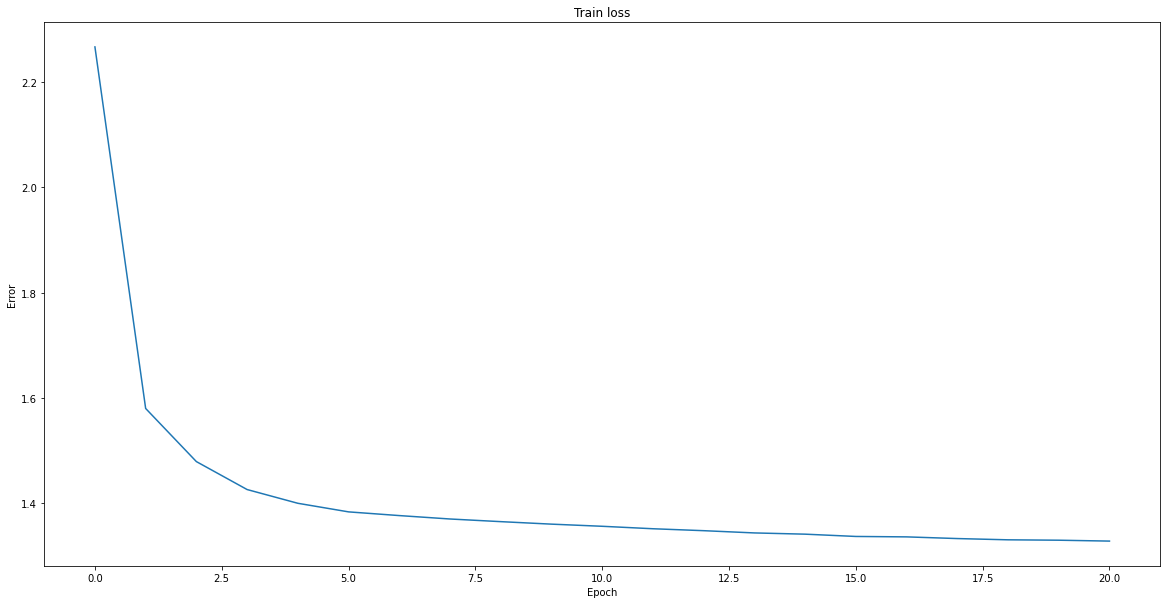

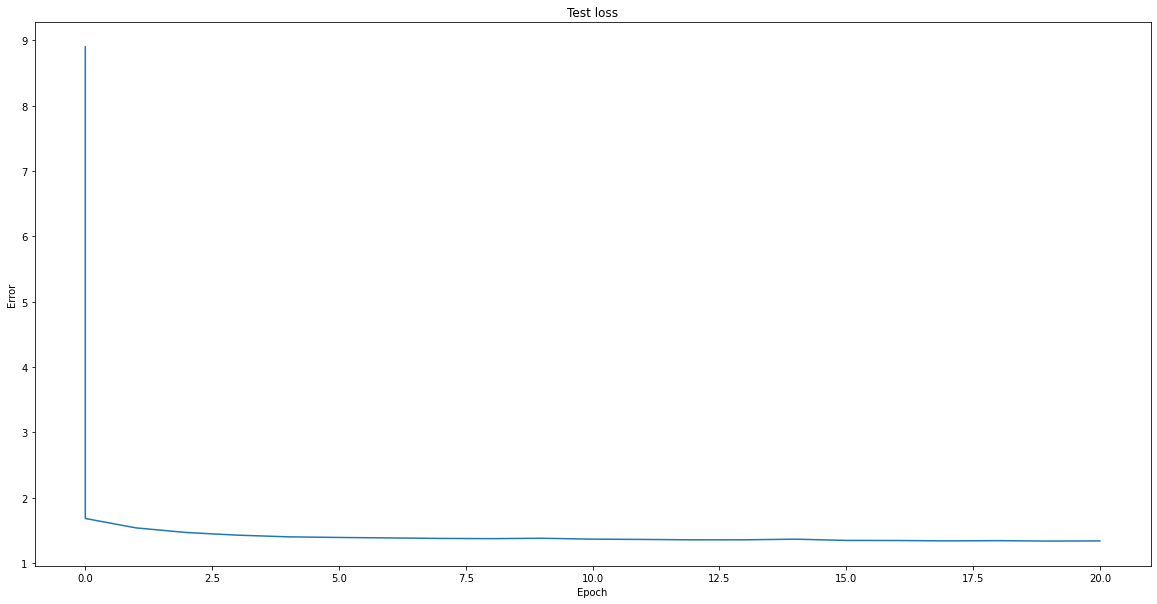

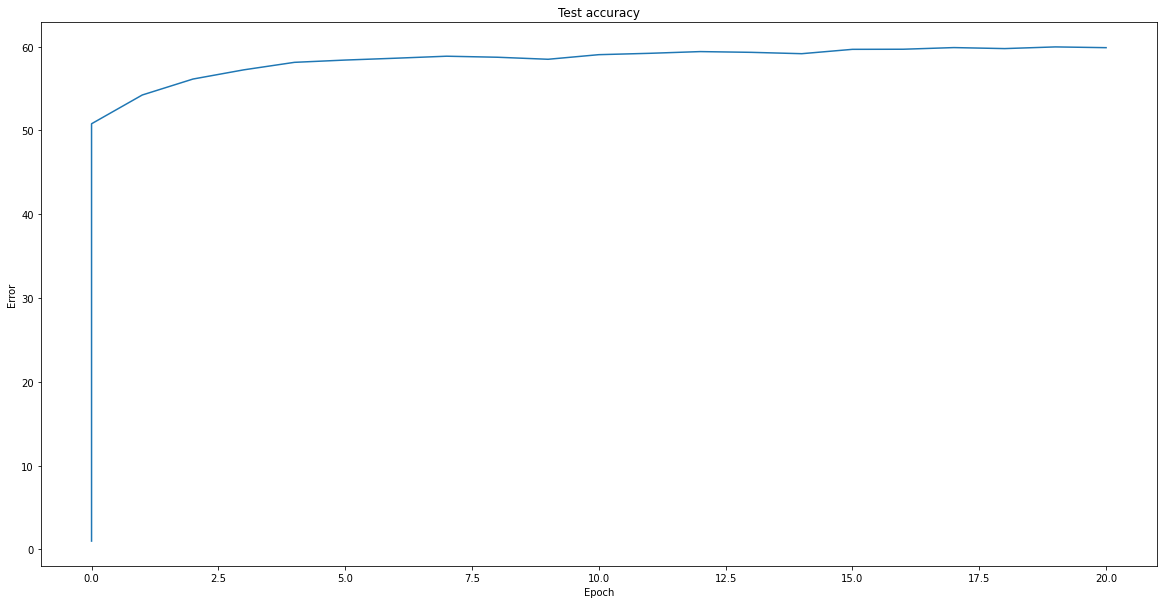

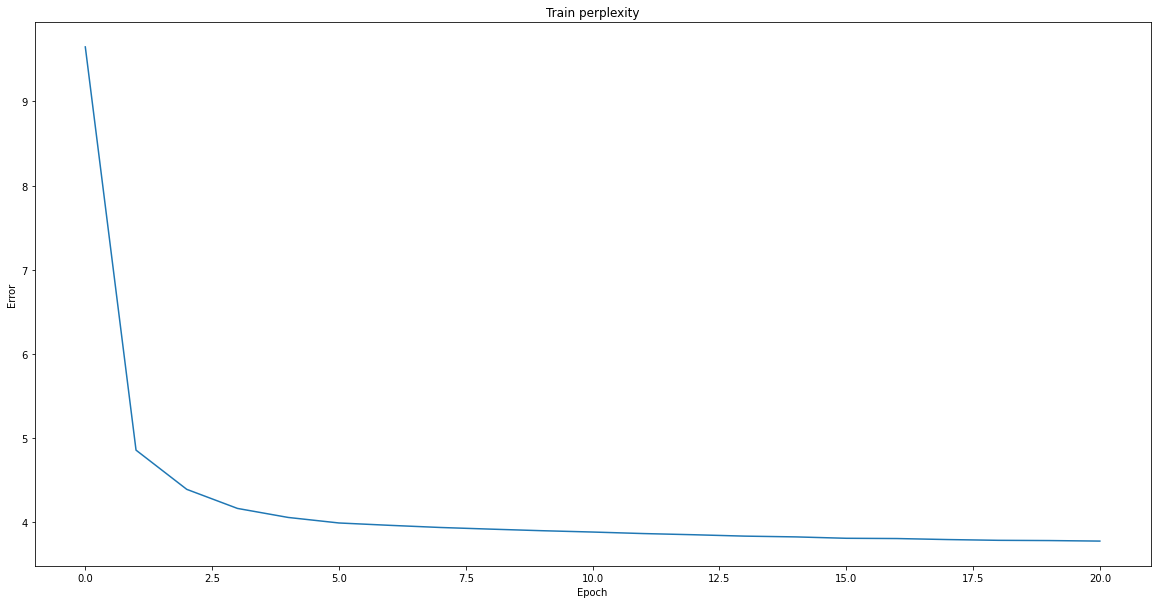

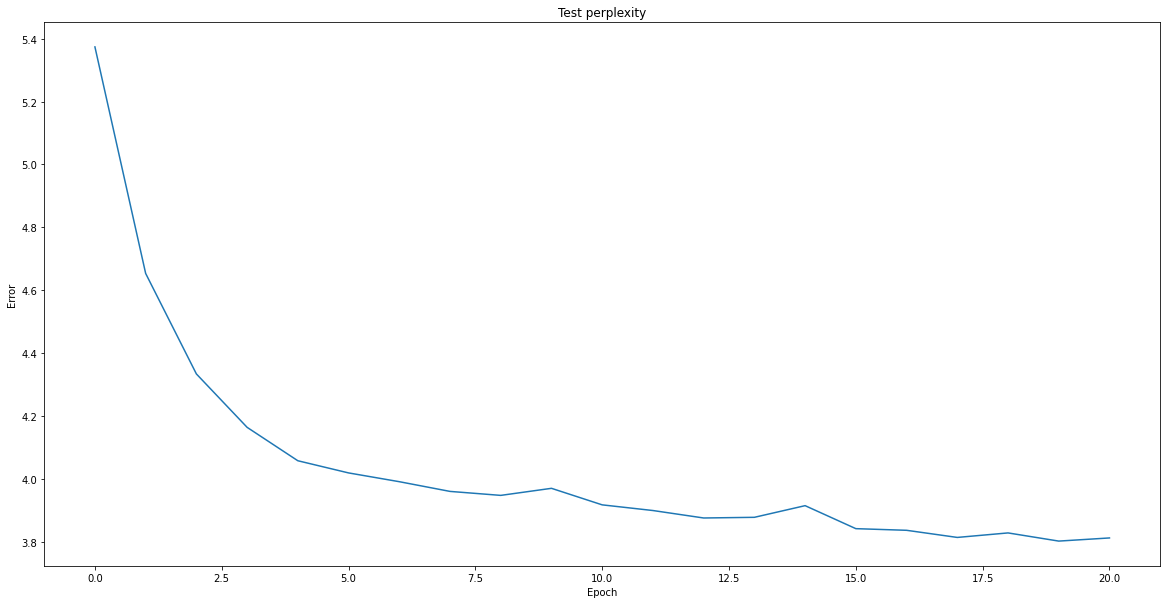

In [ ]:
##LSTM
!rm -r logs
!rm -r checkpoints
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.lstm = nn.LSTM(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru. 
        encode = self.encoder(x)
        decode,hidden_state=self.lstm(encode,hidden_state)
        decode = self.decoder(decode)
        return decode, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False)#, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False)#, **kwargs)
    
    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies, train_perplexities, test_perplexities = pt_util.read_log(LOG_PATH, ([],[],[],[],[]))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))

            train_perplexity = np.exp(train_loss)
            test_perplexity = np.exp(test_loss)
            train_perplexities.append((epoch, train_perplexity))
            test_perplexities.append((epoch, test_perplexity))

            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies, train_perplexities, test_perplexities))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*train_perplexities)
        pt_util.plot(ep, val, 'Train perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_perplexities)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

# Train on words

rm: cannot remove 'logs': No such file or directory
rm: cannot remove 'checkpoints': No such file or directory
Using device cuda
num workers: 2
Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	`88~%XRR`8jl~&))w2~~!jl`l,s!%)%o}j\l}}8~jolvvv)1RjlPPo}l33EEmho}j!l,!0)h=X;;G)j5GMG'j!,,,,j!l,!j-l?,


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	!!}!j%o}jSgggajtl}}}j~~!)-l,,ajo8w2w!j=gP')w\gG8j6'~4)]k,5)\o}j\\mjR}~ll5\8j%ol%)Kbw)we)%o}j\,88,,~j


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	88

  1%|          | 2/195 [00:00<00:12, 15.15it/s]


Test set: Average loss: 9.0631, Accuracy: 15885/1254400 (1%)

Train Epoch: 0 [0/49920 (0%)]	Loss: 9.049556


  7%|▋         | 14/195 [00:00<00:12, 14.94it/s]

Train Epoch: 0 [2560/49920 (5%)]	Loss: 4.602639


 11%|█▏        | 22/195 [00:01<00:11, 14.81it/s]

Train Epoch: 0 [5120/49920 (10%)]	Loss: 2.735839


 16%|█▋        | 32/195 [00:02<00:10, 14.83it/s]

Train Epoch: 0 [7680/49920 (15%)]	Loss: 2.280568


 23%|██▎       | 44/195 [00:02<00:10, 14.85it/s]

Train Epoch: 0 [10240/49920 (21%)]	Loss: 2.125371


 28%|██▊       | 54/195 [00:03<00:09, 14.79it/s]

Train Epoch: 0 [12800/49920 (26%)]	Loss: 2.020727


 33%|███▎      | 64/195 [00:04<00:08, 14.89it/s]

Train Epoch: 0 [15360/49920 (31%)]	Loss: 1.973392


 38%|███▊      | 74/195 [00:04<00:08, 14.81it/s]

Train Epoch: 0 [17920/49920 (36%)]	Loss: 1.920479


 43%|████▎     | 84/195 [00:05<00:07, 14.86it/s]

Train Epoch: 0 [20480/49920 (41%)]	Loss: 1.878312


 48%|████▊     | 94/195 [00:06<00:06, 14.87it/s]

Train Epoch: 0 [23040/49920 (46%)]	Loss: 1.866870


 53%|█████▎    | 104/195 [00:07<00:06, 14.68it/s]

Train Epoch: 0 [25600/49920 (51%)]	Loss: 1.833808


 58%|█████▊    | 114/195 [00:07<00:05, 14.81it/s]

Train Epoch: 0 [28160/49920 (56%)]	Loss: 1.794194


 64%|██████▎   | 124/195 [00:08<00:04, 14.80it/s]

Train Epoch: 0 [30720/49920 (62%)]	Loss: 1.796820


 69%|██████▊   | 134/195 [00:09<00:04, 14.72it/s]

Train Epoch: 0 [33280/49920 (67%)]	Loss: 1.769327


 74%|███████▍  | 144/195 [00:09<00:03, 14.80it/s]

Train Epoch: 0 [35840/49920 (72%)]	Loss: 1.765150


 79%|███████▉  | 154/195 [00:10<00:02, 14.74it/s]

Train Epoch: 0 [38400/49920 (77%)]	Loss: 1.733450


 83%|████████▎ | 162/195 [00:10<00:02, 14.75it/s]

Train Epoch: 0 [40960/49920 (82%)]	Loss: 1.709495


 89%|████████▉ | 174/195 [00:11<00:01, 14.92it/s]

Train Epoch: 0 [43520/49920 (87%)]	Loss: 1.695896


 94%|█████████▍| 184/195 [00:12<00:00, 14.83it/s]

Train Epoch: 0 [46080/49920 (92%)]	Loss: 1.660532


 99%|█████████▉| 194/195 [00:13<00:00, 14.92it/s]

Train Epoch: 0 [48640/49920 (97%)]	Loss: 1.660001


100%|██████████| 195/195 [00:13<00:00, 14.86it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 idththdhttnd totsdd tnains  the sone yothsk  "I wn tarri .  "e said  "Ion't tauki  wadi  said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	s d the sft r tone  and tarry sa p d tumbledore teck tn o the snk ated ycd thet torl d the sooaile t


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	  ng ttd toecpeng tn the sagdie tf the sork aashttnaiem tn tagw edne  "or tf  taw inle tarent tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:13, 14.15it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry staring the said Harry staring the said Harry staring the comment the said Harry and the said Harry staring the said Harry and the said Harry staring the said Harry staring the said Harry starin

Train Epoch: 1 [0/49920 (0%)]	Loss: 1.670571


  7%|▋         | 14/195 [00:00<00:12, 14.84it/s]

Train Epoch: 1 [2560/49920 (5%)]	Loss: 1.659054


 12%|█▏        | 24/195 [00:01<00:11, 14.89it/s]

Train Epoch: 1 [5120/49920 (10%)]	Loss: 1.638636


 17%|█▋        | 34/195 [00:02<00:10, 14.77it/s]

Train Epoch: 1 [7680/49920 (15%)]	Loss: 1.638016


 23%|██▎       | 44/195 [00:02<00:10, 14.90it/s]

Train Epoch: 1 [10240/49920 (21%)]	Loss: 1.622762


 28%|██▊       | 54/195 [00:03<00:09, 14.87it/s]

Train Epoch: 1 [12800/49920 (26%)]	Loss: 1.598788


 33%|███▎      | 64/195 [00:04<00:08, 14.87it/s]

Train Epoch: 1 [15360/49920 (31%)]	Loss: 1.595906


 38%|███▊      | 74/195 [00:04<00:08, 14.88it/s]

Train Epoch: 1 [17920/49920 (36%)]	Loss: 1.579157


 43%|████▎     | 84/195 [00:05<00:07, 14.75it/s]

Train Epoch: 1 [20480/49920 (41%)]	Loss: 1.556291


 48%|████▊     | 94/195 [00:06<00:06, 14.83it/s]

Train Epoch: 1 [23040/49920 (46%)]	Loss: 1.565008


 53%|█████▎    | 104/195 [00:07<00:06, 14.89it/s]

Train Epoch: 1 [25600/49920 (51%)]	Loss: 1.561400


 58%|█████▊    | 114/195 [00:07<00:05, 14.97it/s]

Train Epoch: 1 [28160/49920 (56%)]	Loss: 1.544113


 64%|██████▎   | 124/195 [00:08<00:04, 14.93it/s]

Train Epoch: 1 [30720/49920 (62%)]	Loss: 1.548294


 69%|██████▊   | 134/195 [00:09<00:04, 14.77it/s]

Train Epoch: 1 [33280/49920 (67%)]	Loss: 1.560515


 74%|███████▍  | 144/195 [00:09<00:03, 14.81it/s]

Train Epoch: 1 [35840/49920 (72%)]	Loss: 1.550178


 79%|███████▉  | 154/195 [00:10<00:02, 14.91it/s]

Train Epoch: 1 [38400/49920 (77%)]	Loss: 1.538853


 84%|████████▍ | 164/195 [00:11<00:02, 14.85it/s]

Train Epoch: 1 [40960/49920 (82%)]	Loss: 1.520578


 89%|████████▉ | 174/195 [00:11<00:01, 14.80it/s]

Train Epoch: 1 [43520/49920 (87%)]	Loss: 1.521328


 94%|█████████▍| 184/195 [00:12<00:00, 14.09it/s]

Train Epoch: 1 [46080/49920 (92%)]	Loss: 1.515495


 99%|█████████▉| 194/195 [00:13<00:00, 14.63it/s]

Train Epoch: 1 [48640/49920 (97%)]	Loss: 1.505946


100%|██████████| 195/195 [00:13<00:00, 14.80it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 idd thdnttnd titrtd tnain,t tha sane  oaasl  "I wn aarr  .  "e said  "Ion't wauky  wtdi  said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	s d toe snt r aane  and tarry saap d aumbledore aack tn o the snk aiar yer ahat horl d toa saoaine a


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	  ng tnd toonpeng tn the sagdle af the sork aashttnauat an tagwmead d "or af  aawrible aarent tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:12, 15.02it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry said Harry said and the said and should be and the said and should be and the said and should be and the said and should be and the said and should be and the said and should be and the said and

Train Epoch: 2 [0/49920 (0%)]	Loss: 1.539619


  7%|▋         | 14/195 [00:00<00:12, 14.86it/s]

Train Epoch: 2 [2560/49920 (5%)]	Loss: 1.520770


 11%|█▏        | 22/195 [00:01<00:11, 14.76it/s]

Train Epoch: 2 [5120/49920 (10%)]	Loss: 1.500700


 17%|█▋        | 34/195 [00:02<00:10, 14.85it/s]

Train Epoch: 2 [7680/49920 (15%)]	Loss: 1.508964


 23%|██▎       | 44/195 [00:02<00:10, 14.83it/s]

Train Epoch: 2 [10240/49920 (21%)]	Loss: 1.498012


 28%|██▊       | 54/195 [00:03<00:09, 14.76it/s]

Train Epoch: 2 [12800/49920 (26%)]	Loss: 1.482423


 33%|███▎      | 64/195 [00:04<00:08, 14.91it/s]

Train Epoch: 2 [15360/49920 (31%)]	Loss: 1.489458


 38%|███▊      | 74/195 [00:04<00:08, 14.91it/s]

Train Epoch: 2 [17920/49920 (36%)]	Loss: 1.478820


 43%|████▎     | 84/195 [00:05<00:07, 14.97it/s]

Train Epoch: 2 [20480/49920 (41%)]	Loss: 1.461343


 48%|████▊     | 94/195 [00:06<00:06, 14.79it/s]

Train Epoch: 2 [23040/49920 (46%)]	Loss: 1.469949


 53%|█████▎    | 104/195 [00:06<00:06, 14.91it/s]

Train Epoch: 2 [25600/49920 (51%)]	Loss: 1.473001


 58%|█████▊    | 114/195 [00:07<00:05, 14.85it/s]

Train Epoch: 2 [28160/49920 (56%)]	Loss: 1.471170


 64%|██████▎   | 124/195 [00:08<00:04, 14.78it/s]

Train Epoch: 2 [30720/49920 (62%)]	Loss: 1.467140


 69%|██████▊   | 134/195 [00:09<00:04, 14.82it/s]

Train Epoch: 2 [33280/49920 (67%)]	Loss: 1.480413


 74%|███████▍  | 144/195 [00:09<00:03, 14.76it/s]

Train Epoch: 2 [35840/49920 (72%)]	Loss: 1.479267


 79%|███████▉  | 154/195 [00:10<00:02, 14.79it/s]

Train Epoch: 2 [38400/49920 (77%)]	Loss: 1.472139


 84%|████████▍ | 164/195 [00:11<00:02, 14.82it/s]

Train Epoch: 2 [40960/49920 (82%)]	Loss: 1.468584


 89%|████████▉ | 174/195 [00:11<00:01, 14.82it/s]

Train Epoch: 2 [43520/49920 (87%)]	Loss: 1.447870


 94%|█████████▍| 184/195 [00:12<00:00, 14.85it/s]

Train Epoch: 2 [46080/49920 (92%)]	Loss: 1.439046


 99%|█████████▉| 194/195 [00:13<00:00, 14.89it/s]

Train Epoch: 2 [48640/49920 (97%)]	Loss: 1.436992


100%|██████████| 195/195 [00:13<00:00, 14.86it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 eet hulnttnd soared tnain,t the sare  eahsk  "I tn thrr  .  "e said  "Wun't wauky  wht,  said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	s d the snt r oane  and terry saad d aumbledore aeck tn o the snk ouar yer ahet horl d ahe saoaene a


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	r ng and teenpeng hn the soddle of the sork aashtanuuet an tagwmeade  "or tn  oewrible aorent aarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:13, 13.80it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What was a long the start of the first that he was a long the first that he was a long the first that he was a long the first that he was a long the first that he was a long the first that he was a l

Train Epoch: 3 [0/49920 (0%)]	Loss: 1.460428


  7%|▋         | 14/195 [00:00<00:12, 14.78it/s]

Train Epoch: 3 [2560/49920 (5%)]	Loss: 1.456148


 12%|█▏        | 24/195 [00:01<00:11, 14.82it/s]

Train Epoch: 3 [5120/49920 (10%)]	Loss: 1.436224


 17%|█▋        | 34/195 [00:02<00:10, 14.91it/s]

Train Epoch: 3 [7680/49920 (15%)]	Loss: 1.445220


 23%|██▎       | 44/195 [00:02<00:10, 14.79it/s]

Train Epoch: 3 [10240/49920 (21%)]	Loss: 1.434499


 28%|██▊       | 54/195 [00:03<00:09, 14.91it/s]

Train Epoch: 3 [12800/49920 (26%)]	Loss: 1.427482


 32%|███▏      | 62/195 [00:04<00:09, 14.76it/s]

Train Epoch: 3 [15360/49920 (31%)]	Loss: 1.435272


 38%|███▊      | 74/195 [00:04<00:08, 14.82it/s]

Train Epoch: 3 [17920/49920 (36%)]	Loss: 1.432433


 43%|████▎     | 84/195 [00:05<00:07, 14.89it/s]

Train Epoch: 3 [20480/49920 (41%)]	Loss: 1.412356


 48%|████▊     | 94/195 [00:06<00:06, 14.90it/s]

Train Epoch: 3 [23040/49920 (46%)]	Loss: 1.428686


 53%|█████▎    | 104/195 [00:07<00:06, 14.89it/s]

Train Epoch: 3 [25600/49920 (51%)]	Loss: 1.428931


 58%|█████▊    | 114/195 [00:07<00:05, 14.97it/s]

Train Epoch: 3 [28160/49920 (56%)]	Loss: 1.416939


 64%|██████▎   | 124/195 [00:08<00:04, 14.86it/s]

Train Epoch: 3 [30720/49920 (62%)]	Loss: 1.421178


 69%|██████▊   | 134/195 [00:09<00:04, 14.82it/s]

Train Epoch: 3 [33280/49920 (67%)]	Loss: 1.444918


 74%|███████▍  | 144/195 [00:09<00:03, 14.94it/s]

Train Epoch: 3 [35840/49920 (72%)]	Loss: 1.439491


 79%|███████▉  | 154/195 [00:10<00:02, 14.40it/s]

Train Epoch: 3 [38400/49920 (77%)]	Loss: 1.426860


 84%|████████▍ | 164/195 [00:11<00:02, 14.83it/s]

Train Epoch: 3 [40960/49920 (82%)]	Loss: 1.449196


 89%|████████▉ | 174/195 [00:11<00:01, 14.81it/s]

Train Epoch: 3 [43520/49920 (87%)]	Loss: 1.432544


 94%|█████████▍| 184/195 [00:12<00:00, 14.84it/s]

Train Epoch: 3 [46080/49920 (92%)]	Loss: 1.417426


 99%|█████████▉| 194/195 [00:13<00:00, 14.82it/s]

Train Epoch: 3 [48640/49920 (97%)]	Loss: 1.411813


100%|██████████| 195/195 [00:13<00:00, 14.82it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 eet aolnttnd seavid tnain,t the same  eaisk  "I tn iarr  .  "e said  "Won't wauky "tot," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the stt r oane  and tarry saad d humbledore aeck tn o the sne oeer yer ahet honl d ohe saeaene a


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	r ng and soenpeng hn the soddle of the sork oashtanuuet an tagwmeade  "or tf  oewrible aorent aarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:13, 14.56it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He had been a long to the first that he had been a long and the started to the first that he had been a long and the started to the side of the stairs. "What was all the bent of the common room with a

Train Epoch: 4 [0/49920 (0%)]	Loss: 1.421498


  7%|▋         | 14/195 [00:00<00:12, 15.00it/s]

Train Epoch: 4 [2560/49920 (5%)]	Loss: 1.419169


 12%|█▏        | 24/195 [00:01<00:11, 14.78it/s]

Train Epoch: 4 [5120/49920 (10%)]	Loss: 1.404344


 17%|█▋        | 34/195 [00:02<00:10, 14.64it/s]

Train Epoch: 4 [7680/49920 (15%)]	Loss: 1.414692


 23%|██▎       | 44/195 [00:02<00:10, 14.72it/s]

Train Epoch: 4 [10240/49920 (21%)]	Loss: 1.404529


 28%|██▊       | 54/195 [00:03<00:09, 14.87it/s]

Train Epoch: 4 [12800/49920 (26%)]	Loss: 1.390591


 33%|███▎      | 64/195 [00:04<00:08, 14.88it/s]

Train Epoch: 4 [15360/49920 (31%)]	Loss: 1.402432


 38%|███▊      | 74/195 [00:04<00:08, 14.85it/s]

Train Epoch: 4 [17920/49920 (36%)]	Loss: 1.393254


 43%|████▎     | 84/195 [00:05<00:07, 15.02it/s]

Train Epoch: 4 [20480/49920 (41%)]	Loss: 1.385914


 48%|████▊     | 94/195 [00:06<00:06, 14.87it/s]

Train Epoch: 4 [23040/49920 (46%)]	Loss: 1.397687


 53%|█████▎    | 104/195 [00:07<00:06, 14.84it/s]

Train Epoch: 4 [25600/49920 (51%)]	Loss: 1.396805


 58%|█████▊    | 114/195 [00:07<00:05, 14.77it/s]

Train Epoch: 4 [28160/49920 (56%)]	Loss: 1.388505


 64%|██████▎   | 124/195 [00:08<00:04, 14.83it/s]

Train Epoch: 4 [30720/49920 (62%)]	Loss: 1.400101


 69%|██████▊   | 134/195 [00:09<00:04, 15.01it/s]

Train Epoch: 4 [33280/49920 (67%)]	Loss: 1.433430


 74%|███████▍  | 144/195 [00:09<00:03, 14.91it/s]

Train Epoch: 4 [35840/49920 (72%)]	Loss: 1.410246


 79%|███████▉  | 154/195 [00:10<00:02, 14.94it/s]

Train Epoch: 4 [38400/49920 (77%)]	Loss: 1.410118


 84%|████████▍ | 164/195 [00:11<00:02, 14.83it/s]

Train Epoch: 4 [40960/49920 (82%)]	Loss: 1.393443


 89%|████████▉ | 174/195 [00:11<00:01, 14.80it/s]

Train Epoch: 4 [43520/49920 (87%)]	Loss: 1.392281


 94%|█████████▍| 184/195 [00:12<00:00, 14.86it/s]

Train Epoch: 4 [46080/49920 (92%)]	Loss: 1.387216


 99%|█████████▉| 194/195 [00:13<00:00, 14.93it/s]

Train Epoch: 4 [48640/49920 (97%)]	Loss: 1.381433


100%|██████████| 195/195 [00:13<00:00, 14.88it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 eet aolntond soavid tnainst the sase  eoask  "I wn iarr.".  "e said  "Ion't wanky "wot," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the stt r aane  and tarry saad d aumbledore.aack tn o the snk ooarnyer aoat honl d ahe caeaena o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ring and soanpeng hn the saddle of the sork oashtanuuet an tagwmeade  "or tf  oewrible aarent,aarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:14, 13.76it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry saw that he had been all the back of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the

Train Epoch: 5 [0/49920 (0%)]	Loss: 1.402914


  7%|▋         | 14/195 [00:00<00:12, 14.62it/s]

Train Epoch: 5 [2560/49920 (5%)]	Loss: 1.395653


 12%|█▏        | 24/195 [00:01<00:11, 14.67it/s]

Train Epoch: 5 [5120/49920 (10%)]	Loss: 1.383938


 17%|█▋        | 34/195 [00:02<00:10, 14.80it/s]

Train Epoch: 5 [7680/49920 (15%)]	Loss: 1.390436


 23%|██▎       | 44/195 [00:02<00:10, 14.68it/s]

Train Epoch: 5 [10240/49920 (21%)]	Loss: 1.390356


 28%|██▊       | 54/195 [00:03<00:09, 14.76it/s]

Train Epoch: 5 [12800/49920 (26%)]	Loss: 1.387861


 33%|███▎      | 64/195 [00:04<00:08, 14.84it/s]

Train Epoch: 5 [15360/49920 (31%)]	Loss: 1.410839


 38%|███▊      | 74/195 [00:05<00:08, 14.79it/s]

Train Epoch: 5 [17920/49920 (36%)]	Loss: 1.388089


 43%|████▎     | 84/195 [00:05<00:07, 14.85it/s]

Train Epoch: 5 [20480/49920 (41%)]	Loss: 1.371848


 48%|████▊     | 94/195 [00:06<00:06, 14.79it/s]

Train Epoch: 5 [23040/49920 (46%)]	Loss: 1.384964


 53%|█████▎    | 104/195 [00:07<00:06, 14.68it/s]

Train Epoch: 5 [25600/49920 (51%)]	Loss: 1.383179


 58%|█████▊    | 114/195 [00:07<00:05, 13.57it/s]

Train Epoch: 5 [28160/49920 (56%)]	Loss: 1.372495


 64%|██████▎   | 124/195 [00:08<00:04, 14.64it/s]

Train Epoch: 5 [30720/49920 (62%)]	Loss: 1.383701


 69%|██████▊   | 134/195 [00:09<00:04, 14.73it/s]

Train Epoch: 5 [33280/49920 (67%)]	Loss: 1.405466


 74%|███████▍  | 144/195 [00:09<00:03, 14.74it/s]

Train Epoch: 5 [35840/49920 (72%)]	Loss: 1.397237


 79%|███████▉  | 154/195 [00:10<00:02, 14.85it/s]

Train Epoch: 5 [38400/49920 (77%)]	Loss: 1.395111


 84%|████████▍ | 164/195 [00:11<00:02, 14.91it/s]

Train Epoch: 5 [40960/49920 (82%)]	Loss: 1.388101


 89%|████████▉ | 174/195 [00:11<00:01, 14.89it/s]

Train Epoch: 5 [43520/49920 (87%)]	Loss: 1.366019


 94%|█████████▍| 184/195 [00:12<00:00, 14.92it/s]

Train Epoch: 5 [46080/49920 (92%)]	Loss: 1.368192


 99%|█████████▉| 194/195 [00:13<00:00, 14.96it/s]

Train Epoch: 5 [48640/49920 (97%)]	Loss: 1.368833


100%|██████████| 195/195 [00:13<00:00, 14.75it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 eet tolntond soanid ttain,t the core  eiisk  "I wn ihrrn".  "e said  "Ion't tanky "tor," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the ctt r tane  and tarry saad d tumbledore teck tn o the cnk ooar.yer toat horl d the cooaena t


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ring tnd soanpeng tn the coddle of the cork oashtanuuet an tagwmeade  "or tf  oewrible torent,tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:12, 15.01it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry stared to his face was a lot of the common room what he had been to be an early that he was all the common room with a long of the common room what he was all the common room with a long of the 

Train Epoch: 6 [0/49920 (0%)]	Loss: 1.396947


  7%|▋         | 14/195 [00:00<00:12, 14.86it/s]

Train Epoch: 6 [2560/49920 (5%)]	Loss: 1.388302


 12%|█▏        | 24/195 [00:01<00:11, 14.77it/s]

Train Epoch: 6 [5120/49920 (10%)]	Loss: 1.381510


 17%|█▋        | 34/195 [00:02<00:10, 14.85it/s]

Train Epoch: 6 [7680/49920 (15%)]	Loss: 1.393789


 23%|██▎       | 44/195 [00:02<00:10, 14.87it/s]

Train Epoch: 6 [10240/49920 (21%)]	Loss: 1.381911


 28%|██▊       | 54/195 [00:03<00:09, 14.94it/s]

Train Epoch: 6 [12800/49920 (26%)]	Loss: 1.377062


 33%|███▎      | 64/195 [00:04<00:08, 14.93it/s]

Train Epoch: 6 [15360/49920 (31%)]	Loss: 1.383382


 38%|███▊      | 74/195 [00:04<00:08, 14.86it/s]

Train Epoch: 6 [17920/49920 (36%)]	Loss: 1.372010


 43%|████▎     | 84/195 [00:05<00:07, 14.84it/s]

Train Epoch: 6 [20480/49920 (41%)]	Loss: 1.360089


 48%|████▊     | 94/195 [00:06<00:06, 14.96it/s]

Train Epoch: 6 [23040/49920 (46%)]	Loss: 1.372472


 53%|█████▎    | 104/195 [00:06<00:06, 14.86it/s]

Train Epoch: 6 [25600/49920 (51%)]	Loss: 1.379397


 58%|█████▊    | 114/195 [00:07<00:05, 14.86it/s]

Train Epoch: 6 [28160/49920 (56%)]	Loss: 1.387361


 64%|██████▎   | 124/195 [00:08<00:04, 14.82it/s]

Train Epoch: 6 [30720/49920 (62%)]	Loss: 1.407824


 69%|██████▊   | 134/195 [00:09<00:04, 14.86it/s]

Train Epoch: 6 [33280/49920 (67%)]	Loss: 1.398668


 74%|███████▍  | 144/195 [00:09<00:03, 14.88it/s]

Train Epoch: 6 [35840/49920 (72%)]	Loss: 1.380910


 79%|███████▉  | 154/195 [00:10<00:02, 14.77it/s]

Train Epoch: 6 [38400/49920 (77%)]	Loss: 1.370911


 84%|████████▍ | 164/195 [00:11<00:02, 14.79it/s]

Train Epoch: 6 [40960/49920 (82%)]	Loss: 1.370425


 89%|████████▉ | 174/195 [00:11<00:01, 14.76it/s]

Train Epoch: 6 [43520/49920 (87%)]	Loss: 1.352055


 94%|█████████▍| 184/195 [00:12<00:00, 14.81it/s]

Train Epoch: 6 [46080/49920 (92%)]	Loss: 1.352224


 99%|█████████▉| 194/195 [00:13<00:00, 14.78it/s]

Train Epoch: 6 [48640/49920 (97%)]	Loss: 1.362859


100%|██████████| 195/195 [00:13<00:00, 14.87it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 eet aolntond hoanid ttainst the fase  eoisk  "I wn ih rn .  "e said  "Ion't yarky  Ior   said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	s d the ctt r tare  and tarry saaded tumbledore teck tn o the fnk ooar.ye  toat horl d the fooaene o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ring and soanpeng tn ahe coddle of the cork oashtanuaetsan tagwmeade  "or tf  oewrible torent,tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:14, 13.59it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. It was a sound of the for the first to the first to the first to the first to the first to the first to the first to the first to the first to the first to the first to the first to the first to the f

Train Epoch: 7 [0/49920 (0%)]	Loss: 1.388411


  7%|▋         | 14/195 [00:00<00:12, 14.61it/s]

Train Epoch: 7 [2560/49920 (5%)]	Loss: 1.389107


 12%|█▏        | 24/195 [00:01<00:11, 14.76it/s]

Train Epoch: 7 [5120/49920 (10%)]	Loss: 1.401393


 17%|█▋        | 34/195 [00:02<00:10, 14.77it/s]

Train Epoch: 7 [7680/49920 (15%)]	Loss: 1.380997


 23%|██▎       | 44/195 [00:02<00:10, 14.79it/s]

Train Epoch: 7 [10240/49920 (21%)]	Loss: 1.373942


 28%|██▊       | 54/195 [00:03<00:09, 14.76it/s]

Train Epoch: 7 [12800/49920 (26%)]	Loss: 1.358036


 33%|███▎      | 64/195 [00:04<00:08, 14.87it/s]

Train Epoch: 7 [15360/49920 (31%)]	Loss: 1.371646


 38%|███▊      | 74/195 [00:05<00:08, 14.80it/s]

Train Epoch: 7 [17920/49920 (36%)]	Loss: 1.365389


 43%|████▎     | 84/195 [00:05<00:07, 14.23it/s]

Train Epoch: 7 [20480/49920 (41%)]	Loss: 1.364191


 48%|████▊     | 94/195 [00:06<00:06, 14.74it/s]

Train Epoch: 7 [23040/49920 (46%)]	Loss: 1.372029


 53%|█████▎    | 104/195 [00:07<00:06, 14.81it/s]

Train Epoch: 7 [25600/49920 (51%)]	Loss: 1.373036


 58%|█████▊    | 114/195 [00:07<00:05, 14.86it/s]

Train Epoch: 7 [28160/49920 (56%)]	Loss: 1.355875


 64%|██████▎   | 124/195 [00:08<00:04, 14.93it/s]

Train Epoch: 7 [30720/49920 (62%)]	Loss: 1.362512


 69%|██████▊   | 134/195 [00:09<00:04, 14.85it/s]

Train Epoch: 7 [33280/49920 (67%)]	Loss: 1.394791


 74%|███████▍  | 144/195 [00:09<00:03, 14.85it/s]

Train Epoch: 7 [35840/49920 (72%)]	Loss: 1.376696


 79%|███████▉  | 154/195 [00:10<00:02, 14.78it/s]

Train Epoch: 7 [38400/49920 (77%)]	Loss: 1.370357


 84%|████████▍ | 164/195 [00:11<00:02, 14.81it/s]

Train Epoch: 7 [40960/49920 (82%)]	Loss: 1.362973


 89%|████████▉ | 174/195 [00:11<00:01, 14.85it/s]

Train Epoch: 7 [43520/49920 (87%)]	Loss: 1.354756


 94%|█████████▍| 184/195 [00:12<00:00, 14.82it/s]

Train Epoch: 7 [46080/49920 (92%)]	Loss: 1.348356


 99%|█████████▉| 194/195 [00:13<00:00, 14.85it/s]

Train Epoch: 7 [48640/49920 (97%)]	Loss: 1.358897


100%|██████████| 195/195 [00:13<00:00, 14.77it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 eeteaolntond soanid tnain,t the sase  ewisl  "I wn ah rn .  "e said, "Ion't yarky  Ior," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	eed the str r tore  and tarry saaded tumbledore teck tnto the fne oeer.ye  toat horl d the soeaene o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ring and soanpeng tn the caddle of the fark oaghtanuee san tagwmeade  "rr tfe oelrible terent tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:12, 15.02it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What was a lot of the first time to be and the only of the first time to be and the only of the first time to be and the only of the first time to be and the only of the first time to be and the only

Train Epoch: 8 [0/49920 (0%)]	Loss: 1.378115


  7%|▋         | 14/195 [00:00<00:12, 14.85it/s]

Train Epoch: 8 [2560/49920 (5%)]	Loss: 1.372331


 12%|█▏        | 24/195 [00:01<00:11, 14.88it/s]

Train Epoch: 8 [5120/49920 (10%)]	Loss: 1.371446


 17%|█▋        | 34/195 [00:02<00:10, 14.76it/s]

Train Epoch: 8 [7680/49920 (15%)]	Loss: 1.377345


 23%|██▎       | 44/195 [00:02<00:10, 14.80it/s]

Train Epoch: 8 [10240/49920 (21%)]	Loss: 1.391367


 28%|██▊       | 54/195 [00:03<00:09, 14.92it/s]

Train Epoch: 8 [12800/49920 (26%)]	Loss: 1.362203


 33%|███▎      | 64/195 [00:04<00:08, 14.92it/s]

Train Epoch: 8 [15360/49920 (31%)]	Loss: 1.376701


 38%|███▊      | 74/195 [00:04<00:08, 14.84it/s]

Train Epoch: 8 [17920/49920 (36%)]	Loss: 1.361848


 43%|████▎     | 84/195 [00:05<00:07, 14.74it/s]

Train Epoch: 8 [20480/49920 (41%)]	Loss: 1.347329


 48%|████▊     | 94/195 [00:06<00:06, 14.82it/s]

Train Epoch: 8 [23040/49920 (46%)]	Loss: 1.361627


 53%|█████▎    | 104/195 [00:07<00:06, 14.91it/s]

Train Epoch: 8 [25600/49920 (51%)]	Loss: 1.370079


 58%|█████▊    | 114/195 [00:07<00:05, 14.88it/s]

Train Epoch: 8 [28160/49920 (56%)]	Loss: 1.370751


 64%|██████▎   | 124/195 [00:08<00:04, 14.95it/s]

Train Epoch: 8 [30720/49920 (62%)]	Loss: 1.369284


 69%|██████▊   | 134/195 [00:09<00:04, 14.89it/s]

Train Epoch: 8 [33280/49920 (67%)]	Loss: 1.377696


 74%|███████▍  | 144/195 [00:09<00:03, 14.92it/s]

Train Epoch: 8 [35840/49920 (72%)]	Loss: 1.369879


 79%|███████▉  | 154/195 [00:10<00:02, 14.99it/s]

Train Epoch: 8 [38400/49920 (77%)]	Loss: 1.359600


 84%|████████▍ | 164/195 [00:11<00:02, 14.86it/s]

Train Epoch: 8 [40960/49920 (82%)]	Loss: 1.347356


 89%|████████▉ | 174/195 [00:11<00:01, 14.82it/s]

Train Epoch: 8 [43520/49920 (87%)]	Loss: 1.344522


 94%|█████████▍| 184/195 [00:12<00:00, 14.71it/s]

Train Epoch: 8 [46080/49920 (92%)]	Loss: 1.345563


 99%|█████████▉| 194/195 [00:13<00:00, 14.74it/s]

Train Epoch: 8 [48640/49920 (97%)]	Loss: 1.353840


100%|██████████| 195/195 [00:13<00:00, 14.87it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 edt aolntond seaned tnain.t the sose  ewisl  "I wn se rn .  "e said, "Ien't yarky  Ior," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the stt r tore  and sarry saaded tumbledore aeck tnto the cne oeer,ye  toat hrrl d the soeaena o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ring and seenpeng hn the caddle of the cork aaghtanueetsan tagwmeade  "ir ane oelrible terent tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:13, 14.14it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He stared at the fire to the fire to the first time to the first time to the first time to the first time to the first time to the first time to the first time to the first time to the first time to t

Train Epoch: 9 [0/49920 (0%)]	Loss: 1.373654


  7%|▋         | 14/195 [00:00<00:12, 14.76it/s]

Train Epoch: 9 [2560/49920 (5%)]	Loss: 1.367736


 12%|█▏        | 24/195 [00:01<00:11, 14.82it/s]

Train Epoch: 9 [5120/49920 (10%)]	Loss: 1.368917


 17%|█▋        | 34/195 [00:02<00:10, 14.83it/s]

Train Epoch: 9 [7680/49920 (15%)]	Loss: 1.377744


 22%|██▏       | 42/195 [00:02<00:10, 14.80it/s]

Train Epoch: 9 [10240/49920 (21%)]	Loss: 1.380222


 28%|██▊       | 54/195 [00:03<00:09, 14.69it/s]

Train Epoch: 9 [12800/49920 (26%)]	Loss: 1.352194


 33%|███▎      | 64/195 [00:04<00:08, 14.86it/s]

Train Epoch: 9 [15360/49920 (31%)]	Loss: 1.363617


 38%|███▊      | 74/195 [00:05<00:08, 14.79it/s]

Train Epoch: 9 [17920/49920 (36%)]	Loss: 1.356318


 43%|████▎     | 84/195 [00:05<00:07, 14.70it/s]

Train Epoch: 9 [20480/49920 (41%)]	Loss: 1.342674


 48%|████▊     | 94/195 [00:06<00:06, 14.76it/s]

Train Epoch: 9 [23040/49920 (46%)]	Loss: 1.356876


 52%|█████▏    | 102/195 [00:06<00:06, 14.64it/s]

Train Epoch: 9 [25600/49920 (51%)]	Loss: 1.362061


 58%|█████▊    | 114/195 [00:07<00:05, 14.84it/s]

Train Epoch: 9 [28160/49920 (56%)]	Loss: 1.373602


 64%|██████▎   | 124/195 [00:08<00:04, 14.81it/s]

Train Epoch: 9 [30720/49920 (62%)]	Loss: 1.365431


 69%|██████▊   | 134/195 [00:09<00:04, 14.81it/s]

Train Epoch: 9 [33280/49920 (67%)]	Loss: 1.374486


 74%|███████▍  | 144/195 [00:09<00:03, 14.81it/s]

Train Epoch: 9 [35840/49920 (72%)]	Loss: 1.365184


 79%|███████▉  | 154/195 [00:10<00:02, 14.98it/s]

Train Epoch: 9 [38400/49920 (77%)]	Loss: 1.355646


 84%|████████▍ | 164/195 [00:11<00:02, 14.83it/s]

Train Epoch: 9 [40960/49920 (82%)]	Loss: 1.345678


 89%|████████▉ | 174/195 [00:11<00:01, 14.83it/s]

Train Epoch: 9 [43520/49920 (87%)]	Loss: 1.348731


 94%|█████████▍| 184/195 [00:12<00:00, 14.75it/s]

Train Epoch: 9 [46080/49920 (92%)]	Loss: 1.345218


 99%|█████████▉| 194/195 [00:13<00:00, 14.98it/s]

Train Epoch: 9 [48640/49920 (97%)]	Loss: 1.350107


100%|██████████| 195/195 [00:13<00:00, 14.79it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 edt tolntond seanid tnain.t the sore  iwisl  "I wm se rn .  "e said, "Ion't yarky  Ior," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the stt r tore  and tarry saaded tumbledore teck tnto the cnr oeer,ye  toat torl d the sooaela o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ring and soenping tn the caddle of the cork oaghtanueetsan tagwmeade  "rr an  welrible torent tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:12, 15.02it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry stared at the back of the corner of the corner of the corner of the corner of the corner of the corner of the corner of the corner of the corner of the corner of the corner of the corner of the 

Train Epoch: 10 [0/49920 (0%)]	Loss: 1.367099


  7%|▋         | 14/195 [00:00<00:12, 14.68it/s]

Train Epoch: 10 [2560/49920 (5%)]	Loss: 1.364018


 12%|█▏        | 24/195 [00:01<00:11, 14.76it/s]

Train Epoch: 10 [5120/49920 (10%)]	Loss: 1.361134


 17%|█▋        | 34/195 [00:02<00:10, 14.75it/s]

Train Epoch: 10 [7680/49920 (15%)]	Loss: 1.377909


 23%|██▎       | 44/195 [00:02<00:10, 14.82it/s]

Train Epoch: 10 [10240/49920 (21%)]	Loss: 1.354845


 28%|██▊       | 54/195 [00:03<00:09, 14.99it/s]

Train Epoch: 10 [12800/49920 (26%)]	Loss: 1.341785


 33%|███▎      | 64/195 [00:04<00:08, 14.88it/s]

Train Epoch: 10 [15360/49920 (31%)]	Loss: 1.356553


 38%|███▊      | 74/195 [00:04<00:08, 14.96it/s]

Train Epoch: 10 [17920/49920 (36%)]	Loss: 1.355692


 43%|████▎     | 84/195 [00:05<00:07, 14.88it/s]

Train Epoch: 10 [20480/49920 (41%)]	Loss: 1.343428


 48%|████▊     | 94/195 [00:06<00:06, 14.88it/s]

Train Epoch: 10 [23040/49920 (46%)]	Loss: 1.352925


 53%|█████▎    | 104/195 [00:07<00:06, 14.94it/s]

Train Epoch: 10 [25600/49920 (51%)]	Loss: 1.367923


 58%|█████▊    | 114/195 [00:07<00:05, 14.81it/s]

Train Epoch: 10 [28160/49920 (56%)]	Loss: 1.336216


 64%|██████▎   | 124/195 [00:08<00:04, 14.87it/s]

Train Epoch: 10 [30720/49920 (62%)]	Loss: 1.363627


 69%|██████▊   | 134/195 [00:09<00:04, 14.91it/s]

Train Epoch: 10 [33280/49920 (67%)]	Loss: 1.378230


 74%|███████▍  | 144/195 [00:09<00:03, 14.80it/s]

Train Epoch: 10 [35840/49920 (72%)]	Loss: 1.363287


 79%|███████▉  | 154/195 [00:10<00:02, 14.99it/s]

Train Epoch: 10 [38400/49920 (77%)]	Loss: 1.354139


 84%|████████▍ | 164/195 [00:11<00:02, 14.88it/s]

Train Epoch: 10 [40960/49920 (82%)]	Loss: 1.336809


 89%|████████▉ | 174/195 [00:11<00:01, 14.86it/s]

Train Epoch: 10 [43520/49920 (87%)]	Loss: 1.339404


 94%|█████████▍| 184/195 [00:12<00:00, 14.84it/s]

Train Epoch: 10 [46080/49920 (92%)]	Loss: 1.340005


 99%|█████████▉| 194/195 [00:13<00:00, 14.81it/s]

Train Epoch: 10 [48640/49920 (97%)]	Loss: 1.346967


100%|██████████| 195/195 [00:13<00:00, 14.88it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 edtetolntond soaned ttain.t the sore  ewasl  "I wm searn .  "e said  "Iun't yarky  Ior " said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the stt r tore  and sarry saaded humbledore teck tn o the cnk oeer,ye  toat horl d the soaaela o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ring and soanpeng hn the caddle of the cork oaghtanaeet an tagwmeade  "or an  walrible sorent tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:14, 13.46it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

Train Epoch: 11 [0/49920 (0%)]	Loss: 1.365794


  7%|▋         | 14/195 [00:01<00:13, 13.73it/s]

Train Epoch: 11 [2560/49920 (5%)]	Loss: 1.363147


 12%|█▏        | 24/195 [00:01<00:11, 14.68it/s]

Train Epoch: 11 [5120/49920 (10%)]	Loss: 1.361913


 17%|█▋        | 34/195 [00:02<00:10, 14.79it/s]

Train Epoch: 11 [7680/49920 (15%)]	Loss: 1.367928


 23%|██▎       | 44/195 [00:03<00:10, 14.86it/s]

Train Epoch: 11 [10240/49920 (21%)]	Loss: 1.347602


 28%|██▊       | 54/195 [00:03<00:09, 14.92it/s]

Train Epoch: 11 [12800/49920 (26%)]	Loss: 1.337523


 33%|███▎      | 64/195 [00:04<00:08, 14.81it/s]

Train Epoch: 11 [15360/49920 (31%)]	Loss: 1.349645


 38%|███▊      | 74/195 [00:05<00:08, 14.76it/s]

Train Epoch: 11 [17920/49920 (36%)]	Loss: 1.354313


 43%|████▎     | 84/195 [00:05<00:07, 14.88it/s]

Train Epoch: 11 [20480/49920 (41%)]	Loss: 1.339869


 48%|████▊     | 94/195 [00:06<00:06, 14.88it/s]

Train Epoch: 11 [23040/49920 (46%)]	Loss: 1.345908


 53%|█████▎    | 104/195 [00:07<00:06, 14.87it/s]

Train Epoch: 11 [25600/49920 (51%)]	Loss: 1.357877


 58%|█████▊    | 114/195 [00:07<00:05, 14.77it/s]

Train Epoch: 11 [28160/49920 (56%)]	Loss: 1.336267


 64%|██████▎   | 124/195 [00:08<00:04, 14.82it/s]

Train Epoch: 11 [30720/49920 (62%)]	Loss: 1.351312


 69%|██████▊   | 134/195 [00:09<00:04, 14.76it/s]

Train Epoch: 11 [33280/49920 (67%)]	Loss: 1.369156


 74%|███████▍  | 144/195 [00:09<00:03, 14.80it/s]

Train Epoch: 11 [35840/49920 (72%)]	Loss: 1.357047


 79%|███████▉  | 154/195 [00:10<00:02, 14.88it/s]

Train Epoch: 11 [38400/49920 (77%)]	Loss: 1.348150


 84%|████████▍ | 164/195 [00:11<00:02, 14.80it/s]

Train Epoch: 11 [40960/49920 (82%)]	Loss: 1.337057


 89%|████████▉ | 174/195 [00:11<00:01, 14.84it/s]

Train Epoch: 11 [43520/49920 (87%)]	Loss: 1.334992


 94%|█████████▍| 184/195 [00:12<00:00, 14.93it/s]

Train Epoch: 11 [46080/49920 (92%)]	Loss: 1.327349


 99%|█████████▉| 194/195 [00:13<00:00, 14.87it/s]

Train Epoch: 11 [48640/49920 (97%)]	Loss: 1.342445


100%|██████████| 195/195 [00:13<00:00, 14.77it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 edtetulntond soaned ttain,t the sore  eoisl  "I wm ahlrl .  "e said, "Iun't yarky  Ior," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the stt r tore  and sarry waaded humbledore teck tnto the cnk aiat,ye  toat hrrl d the soaaela o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ring and sranpeng hn the caddle of the cark aaghtanaeet an tagwmeade  "ir an  oelrible sorent oarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:12, 15.23it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry stared at him. "I was a second years and said in the castle of the first time to be all the only of the matter of the matter of the stairs and started to be and started to be and started to be a

Train Epoch: 12 [0/49920 (0%)]	Loss: 1.359050


  7%|▋         | 14/195 [00:00<00:12, 14.88it/s]

Train Epoch: 12 [2560/49920 (5%)]	Loss: 1.353192


 12%|█▏        | 24/195 [00:01<00:11, 14.93it/s]

Train Epoch: 12 [5120/49920 (10%)]	Loss: 1.353702


 17%|█▋        | 34/195 [00:02<00:10, 14.98it/s]

Train Epoch: 12 [7680/49920 (15%)]	Loss: 1.362563


 23%|██▎       | 44/195 [00:02<00:10, 14.86it/s]

Train Epoch: 12 [10240/49920 (21%)]	Loss: 1.347734


 28%|██▊       | 54/195 [00:03<00:09, 14.83it/s]

Train Epoch: 12 [12800/49920 (26%)]	Loss: 1.334107


 33%|███▎      | 64/195 [00:04<00:08, 14.81it/s]

Train Epoch: 12 [15360/49920 (31%)]	Loss: 1.350186


 38%|███▊      | 74/195 [00:04<00:08, 14.86it/s]

Train Epoch: 12 [17920/49920 (36%)]	Loss: 1.349948


 43%|████▎     | 84/195 [00:05<00:07, 14.95it/s]

Train Epoch: 12 [20480/49920 (41%)]	Loss: 1.340667


 48%|████▊     | 94/195 [00:06<00:06, 14.99it/s]

Train Epoch: 12 [23040/49920 (46%)]	Loss: 1.342011


 53%|█████▎    | 104/195 [00:06<00:06, 14.82it/s]

Train Epoch: 12 [25600/49920 (51%)]	Loss: 1.353339


 58%|█████▊    | 114/195 [00:07<00:05, 14.77it/s]

Train Epoch: 12 [28160/49920 (56%)]	Loss: 1.349778


 64%|██████▎   | 124/195 [00:08<00:04, 14.88it/s]

Train Epoch: 12 [30720/49920 (62%)]	Loss: 1.357152


 69%|██████▊   | 134/195 [00:09<00:04, 14.83it/s]

Train Epoch: 12 [33280/49920 (67%)]	Loss: 1.368484


 74%|███████▍  | 144/195 [00:09<00:03, 14.81it/s]

Train Epoch: 12 [35840/49920 (72%)]	Loss: 1.353965


 79%|███████▉  | 154/195 [00:10<00:02, 14.78it/s]

Train Epoch: 12 [38400/49920 (77%)]	Loss: 1.345525


 84%|████████▍ | 164/195 [00:11<00:02, 14.84it/s]

Train Epoch: 12 [40960/49920 (82%)]	Loss: 1.332061


 89%|████████▉ | 174/195 [00:11<00:01, 14.90it/s]

Train Epoch: 12 [43520/49920 (87%)]	Loss: 1.324683


 94%|█████████▍| 184/195 [00:12<00:00, 14.96it/s]

Train Epoch: 12 [46080/49920 (92%)]	Loss: 1.329874


 99%|█████████▉| 194/195 [00:13<00:00, 14.79it/s]

Train Epoch: 12 [48640/49920 (97%)]	Loss: 1.347939


100%|██████████| 195/195 [00:13<00:00, 14.88it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 edtetulntond seaned tnain,t the soren eoisl  "I wm selrl .  "e said, "Iun't yarky  Ior," said Herry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the stt r tore  and sarry waaded humbledore teck tn o the cnk oeet,ye  toat herl d the boaaela o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ring and seanpeng hn the caddle of the cerk oeghtonaeet an tagwmeade  "ir ane weurible serent tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:13, 14.04it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. of course, the comment of the stairs and seemed to be and see the beather with the fire of the comment, the comment of the stairs and seemed to be and the only thing the only was standing in the corne

Train Epoch: 13 [0/49920 (0%)]	Loss: 1.366726


  7%|▋         | 14/195 [00:00<00:12, 14.70it/s]

Train Epoch: 13 [2560/49920 (5%)]	Loss: 1.352554


 12%|█▏        | 24/195 [00:01<00:11, 14.76it/s]

Train Epoch: 13 [5120/49920 (10%)]	Loss: 1.351814


 17%|█▋        | 34/195 [00:02<00:10, 14.80it/s]

Train Epoch: 13 [7680/49920 (15%)]	Loss: 1.355724


 22%|██▏       | 42/195 [00:02<00:10, 14.75it/s]

Train Epoch: 13 [10240/49920 (21%)]	Loss: 1.341312


 28%|██▊       | 54/195 [00:03<00:09, 14.72it/s]

Train Epoch: 13 [12800/49920 (26%)]	Loss: 1.327500


 33%|███▎      | 64/195 [00:04<00:08, 14.95it/s]

Train Epoch: 13 [15360/49920 (31%)]	Loss: 1.342341


 38%|███▊      | 74/195 [00:05<00:08, 14.92it/s]

Train Epoch: 13 [17920/49920 (36%)]	Loss: 1.340396


 43%|████▎     | 84/195 [00:05<00:07, 14.86it/s]

Train Epoch: 13 [20480/49920 (41%)]	Loss: 1.326252


 48%|████▊     | 94/195 [00:06<00:06, 14.84it/s]

Train Epoch: 13 [23040/49920 (46%)]	Loss: 1.335549


 52%|█████▏    | 102/195 [00:06<00:06, 14.72it/s]

Train Epoch: 13 [25600/49920 (51%)]	Loss: 1.346991


 58%|█████▊    | 114/195 [00:07<00:05, 14.80it/s]

Train Epoch: 13 [28160/49920 (56%)]	Loss: 1.346144


 64%|██████▎   | 124/195 [00:08<00:04, 14.89it/s]

Train Epoch: 13 [30720/49920 (62%)]	Loss: 1.358375


 69%|██████▊   | 134/195 [00:09<00:04, 14.76it/s]

Train Epoch: 13 [33280/49920 (67%)]	Loss: 1.364339


 74%|███████▍  | 144/195 [00:09<00:03, 14.77it/s]

Train Epoch: 13 [35840/49920 (72%)]	Loss: 1.350413


 79%|███████▉  | 154/195 [00:10<00:02, 14.80it/s]

Train Epoch: 13 [38400/49920 (77%)]	Loss: 1.344341


 84%|████████▍ | 164/195 [00:11<00:02, 14.79it/s]

Train Epoch: 13 [40960/49920 (82%)]	Loss: 1.327109


 89%|████████▉ | 174/195 [00:11<00:01, 14.88it/s]

Train Epoch: 13 [43520/49920 (87%)]	Loss: 1.326589


 94%|█████████▍| 184/195 [00:12<00:00, 14.85it/s]

Train Epoch: 13 [46080/49920 (92%)]	Loss: 1.322515


 99%|█████████▉| 194/195 [00:13<00:00, 14.81it/s]

Train Epoch: 13 [48640/49920 (97%)]	Loss: 1.337130


100%|██████████| 195/195 [00:13<00:00, 14.83it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 edtetulntond seandd ttain,t the soren aoisl  "I wm selrl .  "e said, "Iun't yarky  Ior," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the stt r tore  and sarry waaded humbledore aeck tn o the cnk otet,ye  that hrrl d the boaaela o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ring and seanpeng hn the caddle of the cork aagh anaeet an tagwmeade  "ir ane weurible sorent tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:12, 14.90it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The was all the back of the common room with his wand and started to be and started to be and started to be and the only thing that he had been to see the stairs and started to be and the only thing t

Train Epoch: 14 [0/49920 (0%)]	Loss: 1.359120


  7%|▋         | 14/195 [00:00<00:12, 14.76it/s]

Train Epoch: 14 [2560/49920 (5%)]	Loss: 1.347279


 12%|█▏        | 24/195 [00:01<00:11, 14.79it/s]

Train Epoch: 14 [5120/49920 (10%)]	Loss: 1.355808


 17%|█▋        | 34/195 [00:02<00:10, 14.73it/s]

Train Epoch: 14 [7680/49920 (15%)]	Loss: 1.358481


 23%|██▎       | 44/195 [00:02<00:10, 14.71it/s]

Train Epoch: 14 [10240/49920 (21%)]	Loss: 1.342312


 28%|██▊       | 54/195 [00:03<00:09, 14.77it/s]

Train Epoch: 14 [12800/49920 (26%)]	Loss: 1.323647


 33%|███▎      | 64/195 [00:04<00:08, 14.82it/s]

Train Epoch: 14 [15360/49920 (31%)]	Loss: 1.341181


 38%|███▊      | 74/195 [00:04<00:08, 14.89it/s]

Train Epoch: 14 [17920/49920 (36%)]	Loss: 1.338795


 42%|████▏     | 82/195 [00:05<00:07, 14.86it/s]

Train Epoch: 14 [20480/49920 (41%)]	Loss: 1.325012


 48%|████▊     | 94/195 [00:06<00:06, 14.83it/s]

Train Epoch: 14 [23040/49920 (46%)]	Loss: 1.331480


 52%|█████▏    | 102/195 [00:06<00:06, 14.72it/s]

Train Epoch: 14 [25600/49920 (51%)]	Loss: 1.343218


 58%|█████▊    | 114/195 [00:07<00:05, 14.88it/s]

Train Epoch: 14 [28160/49920 (56%)]	Loss: 1.348812


 64%|██████▎   | 124/195 [00:08<00:04, 14.80it/s]

Train Epoch: 14 [30720/49920 (62%)]	Loss: 1.353676


 68%|██████▊   | 132/195 [00:08<00:04, 14.65it/s]

Train Epoch: 14 [33280/49920 (67%)]	Loss: 1.360067


 74%|███████▍  | 144/195 [00:09<00:03, 14.83it/s]

Train Epoch: 14 [35840/49920 (72%)]	Loss: 1.347806


 79%|███████▉  | 154/195 [00:10<00:02, 14.79it/s]

Train Epoch: 14 [38400/49920 (77%)]	Loss: 1.338994


 84%|████████▍ | 164/195 [00:11<00:02, 14.81it/s]

Train Epoch: 14 [40960/49920 (82%)]	Loss: 1.326426


 88%|████████▊ | 172/195 [00:11<00:01, 14.79it/s]

Train Epoch: 14 [43520/49920 (87%)]	Loss: 1.319819


 94%|█████████▍| 184/195 [00:12<00:00, 14.56it/s]

Train Epoch: 14 [46080/49920 (92%)]	Loss: 1.318347


 99%|█████████▉| 194/195 [00:13<00:00, 14.82it/s]

Train Epoch: 14 [48640/49920 (97%)]	Loss: 1.336946


100%|██████████| 195/195 [00:13<00:00, 14.77it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 edtetulntond seavnd ttain,t the sorer aaisl  "I wm selrl .  "e said, "Iu 't yarky  Ior," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the stt r tore  and tarry waaded humbledore teck tn o the cnk otet,ye  that hrrl d the soaaele o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ring and seanpeng tn the caddle of the cork aagh anueet an tagwmeade  "or ane weurible sorent tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:14, 13.75it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry was standing in the corner of the common room with a sudden that he had been to see the stairs and stared at the fire of the first time to have been the only thing that he was standing in the co

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.355523


  6%|▌         | 12/195 [00:00<00:12, 14.51it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 1.344468


 12%|█▏        | 24/195 [00:01<00:11, 14.81it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 1.347536


 17%|█▋        | 34/195 [00:02<00:10, 14.86it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 1.348557


 23%|██▎       | 44/195 [00:02<00:10, 14.68it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 1.337326


 28%|██▊       | 54/195 [00:03<00:09, 14.84it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 1.320747


 33%|███▎      | 64/195 [00:04<00:08, 14.76it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 1.336785


 38%|███▊      | 74/195 [00:05<00:08, 14.87it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 1.336067


 43%|████▎     | 84/195 [00:05<00:07, 14.90it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 1.321860


 48%|████▊     | 94/195 [00:06<00:06, 14.77it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 1.327381


 53%|█████▎    | 104/195 [00:07<00:06, 14.76it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 1.343008


 58%|█████▊    | 114/195 [00:07<00:05, 14.98it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 1.340324


 64%|██████▎   | 124/195 [00:08<00:04, 14.87it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 1.349390


 69%|██████▊   | 134/195 [00:09<00:04, 14.93it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 1.361874


 74%|███████▍  | 144/195 [00:09<00:03, 14.93it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 1.344720


 79%|███████▉  | 154/195 [00:10<00:02, 14.83it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 1.336372


 84%|████████▍ | 164/195 [00:11<00:02, 14.99it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 1.323725


 89%|████████▉ | 174/195 [00:11<00:01, 14.84it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 1.316643


 94%|█████████▍| 184/195 [00:12<00:00, 14.82it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 1.313527


 99%|█████████▉| 194/195 [00:13<00:00, 14.91it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 1.332900


100%|██████████| 195/195 [00:13<00:00, 14.84it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 e tetulntond seaved ttain,t the soreraaoisl  "I wm aelrl .  "e said, "Iu 't yarky  yor " said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the snt r oore  and tarry waaded humbledore teck tn o the cnk otet.ye  that hrrled hhe boaaene o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ring and seanpeng tn the caddle of the cork oagh anueet tn tagwmeade  "or ane waurible souent tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:12, 15.25it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The stare of the first table and stared at the fire of the fire of the fire of the first table and stared at the fire of the fire of the fire of the first table and stared at the back of the common ro

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.351823


  7%|▋         | 14/195 [00:00<00:12, 14.89it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 1.342974


 12%|█▏        | 24/195 [00:01<00:11, 14.87it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 1.340484


 17%|█▋        | 34/195 [00:02<00:10, 14.88it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 1.343256


 23%|██▎       | 44/195 [00:02<00:10, 14.88it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 1.334034


 28%|██▊       | 54/195 [00:03<00:09, 14.86it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 1.322413


 33%|███▎      | 64/195 [00:04<00:08, 14.87it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 1.334390


 38%|███▊      | 74/195 [00:04<00:08, 14.81it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 1.333087


 43%|████▎     | 84/195 [00:05<00:07, 14.89it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 1.318661


 48%|████▊     | 94/195 [00:06<00:06, 14.83it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 1.325329


 53%|█████▎    | 104/195 [00:07<00:06, 14.82it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 1.337469


 58%|█████▊    | 114/195 [00:07<00:05, 14.92it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 1.327895


 64%|██████▎   | 124/195 [00:08<00:04, 14.98it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 1.344321


 68%|██████▊   | 132/195 [00:08<00:04, 14.72it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 1.357398


 74%|███████▍  | 144/195 [00:09<00:03, 13.99it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 1.342297


 79%|███████▉  | 154/195 [00:10<00:02, 14.70it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 1.334521


 84%|████████▍ | 164/195 [00:11<00:02, 14.80it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 1.319578


 89%|████████▉ | 174/195 [00:11<00:01, 14.80it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 1.313204


 94%|█████████▍| 184/195 [00:12<00:00, 14.95it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 1.316132


 99%|█████████▉| 194/195 [00:13<00:00, 14.99it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 1.331933


100%|██████████| 195/195 [00:13<00:00, 14.82it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 edtetulntond seavid ttain,t the soser aaisl  "I wm selrl .  "e said  "Iun't yarky  yor " said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed toe snt r tore  and sarry waaded humbledore teck into the cnk otet.ye  that hrnled hhe soaaene o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ring and seanpeng tn the caddle of the cerk aagh anueet tn tagwmeade  "or ane weurible soment tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:13, 13.86it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry was standing in the corner of the common room with a sudden was started to be and the only thing that he was standing in the corner of the common room with a sudden was started to be and streame

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.348047


  7%|▋         | 14/195 [00:00<00:12, 14.50it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 1.340721


 12%|█▏        | 24/195 [00:01<00:11, 14.95it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 1.339718


 17%|█▋        | 34/195 [00:02<00:10, 14.84it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 1.341961


 23%|██▎       | 44/195 [00:02<00:10, 14.74it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 1.328384


 28%|██▊       | 54/195 [00:03<00:09, 14.80it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 1.315129


 33%|███▎      | 64/195 [00:04<00:08, 14.85it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 1.333297


 38%|███▊      | 74/195 [00:05<00:08, 14.88it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 1.329646


 43%|████▎     | 84/195 [00:05<00:07, 14.86it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 1.320230


 48%|████▊     | 94/195 [00:06<00:06, 14.84it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 1.323203


 53%|█████▎    | 104/195 [00:07<00:06, 14.92it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 1.334934


 58%|█████▊    | 114/195 [00:07<00:05, 14.73it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 1.324379


 64%|██████▎   | 124/195 [00:08<00:04, 14.77it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 1.340004


 69%|██████▊   | 134/195 [00:09<00:04, 14.82it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 1.357367


 74%|███████▍  | 144/195 [00:09<00:03, 14.77it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 1.340559


 79%|███████▉  | 154/195 [00:10<00:02, 14.83it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 1.331026


 84%|████████▍ | 164/195 [00:11<00:02, 14.86it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 1.316700


 89%|████████▉ | 174/195 [00:11<00:01, 14.89it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 1.310207


 94%|█████████▍| 184/195 [00:12<00:00, 14.82it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 1.306160


 99%|█████████▉| 194/195 [00:13<00:00, 14.84it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 1.325662


100%|██████████| 195/195 [00:13<00:00, 14.84it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 edtetulntond soavid ttain,t the soser aaasl  "I sm salrn .  "e said  "Iun't yarky  wor   said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the snt r oore  and sarry waaded humbledore weck into the cnk ohet.red aoat hrnled hhe soaaene o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ring and seanpeng hn the caddle of the cark oagh wnueet tn tagwmeade  "or ane waurible sorent tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:12, 14.94it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry stared at him and said in a shade of the common room with a sudden was staring at the first table and said, "I said to say that the matter of the matter of the commentration was staring at the f

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.347770


  7%|▋         | 14/195 [00:00<00:12, 14.91it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 1.339449


 12%|█▏        | 24/195 [00:01<00:11, 14.87it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 1.344795


 17%|█▋        | 34/195 [00:02<00:10, 14.94it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 1.341719


 23%|██▎       | 44/195 [00:02<00:10, 14.88it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 1.332524


 28%|██▊       | 54/195 [00:03<00:09, 14.86it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 1.312763


 33%|███▎      | 64/195 [00:04<00:08, 14.95it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 1.328205


 38%|███▊      | 74/195 [00:04<00:08, 14.92it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 1.332531


 43%|████▎     | 84/195 [00:05<00:07, 14.86it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 1.317170


 48%|████▊     | 94/195 [00:06<00:06, 14.97it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 1.323710


 53%|█████▎    | 104/195 [00:06<00:06, 14.91it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 1.339979


 58%|█████▊    | 114/195 [00:07<00:05, 14.48it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 1.320334


 64%|██████▎   | 124/195 [00:08<00:04, 14.71it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 1.338746


 69%|██████▊   | 134/195 [00:09<00:04, 14.82it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 1.366577


 74%|███████▍  | 144/195 [00:09<00:03, 14.73it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 1.340734


 79%|███████▉  | 154/195 [00:10<00:02, 14.76it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 1.328049


 84%|████████▍ | 164/195 [00:11<00:02, 14.79it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 1.313417


 89%|████████▉ | 174/195 [00:11<00:01, 14.93it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 1.310486


 94%|█████████▍| 184/195 [00:12<00:00, 14.87it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 1.305529


 99%|█████████▉| 194/195 [00:13<00:00, 14.88it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 1.324501


100%|██████████| 195/195 [00:13<00:00, 14.81it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 edtetunntond seadid ttain,t the soser aaisl  "I sm selrn .  "e said  "Iun't yarky  yor," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the snt r oore  and sarry waaded humbledore aeck tnto the cnk otet.red toat hrnled hhe soaaene o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ring and seanpeng tn the caddle of the cark aagh onueet tn tagwmeade  "or ane waurible souent tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:13, 13.79it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry was standing in the corner of the common room with a small of the first time of the stairs and the surprise of the stairs and stared at the first table and stared at the first table and stared a

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.345165


  7%|▋         | 14/195 [00:00<00:12, 14.68it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 1.338750


 12%|█▏        | 24/195 [00:01<00:11, 14.84it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 1.339916


 17%|█▋        | 34/195 [00:02<00:10, 14.86it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 1.338153


 23%|██▎       | 44/195 [00:02<00:10, 14.79it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 1.324059


 28%|██▊       | 54/195 [00:03<00:09, 14.75it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 1.309992


 33%|███▎      | 64/195 [00:04<00:08, 14.88it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 1.329130


 38%|███▊      | 74/195 [00:05<00:08, 14.81it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 1.325525


 43%|████▎     | 84/195 [00:05<00:07, 14.80it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 1.314870


 48%|████▊     | 94/195 [00:06<00:06, 14.92it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 1.320013


 53%|█████▎    | 104/195 [00:07<00:06, 14.89it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 1.328720


 58%|█████▊    | 114/195 [00:07<00:05, 14.77it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 1.314999


 64%|██████▎   | 124/195 [00:08<00:04, 14.82it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 1.328726


 69%|██████▊   | 134/195 [00:09<00:04, 14.76it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 1.356910


 74%|███████▍  | 144/195 [00:09<00:03, 14.88it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 1.337759


 79%|███████▉  | 154/195 [00:10<00:02, 14.85it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 1.326302


 84%|████████▍ | 164/195 [00:11<00:02, 14.82it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 1.312236


 89%|████████▉ | 174/195 [00:11<00:01, 14.75it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 1.310274


 94%|█████████▍| 184/195 [00:12<00:00, 14.93it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 1.306192


 99%|█████████▉| 194/195 [00:13<00:00, 14.81it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 1.324800


100%|██████████| 195/195 [00:13<00:00, 14.82it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 edt tunntond seanid ttain,t the careraaaisl  "I wm selrn".  "e said  "Iun't yarky "yor," said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed the snt r oone  and tarry waad d humbledore weck tnto the cnk ohet.yed that hrnled hhe saaaenh o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ring and seanping hn the caddle of the cark oagh onueet tn tagwmeade  "ur ane oaurible souent tarry 


Input	elp, but there was nobody to be seen 

  1%|          | 2/195 [00:00<00:12, 15.16it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. In the first time of the first time of the first time of the first time of the stairs and said in the common room with a sudden way to the first time of the first time of the stairs and the only thing

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.343802


  7%|▋         | 14/195 [00:00<00:12, 14.85it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.334261


 12%|█▏        | 24/195 [00:01<00:11, 14.87it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.329483


 17%|█▋        | 34/195 [00:02<00:10, 14.72it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.334121


 23%|██▎       | 44/195 [00:02<00:10, 14.76it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.328284


 28%|██▊       | 54/195 [00:03<00:09, 15.00it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.312433


 33%|███▎      | 64/195 [00:04<00:08, 15.02it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.323047


 37%|███▋      | 72/195 [00:04<00:09, 13.23it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.325181


 43%|████▎     | 84/195 [00:05<00:07, 14.67it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.312353


 48%|████▊     | 94/195 [00:06<00:06, 14.82it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.318755


 53%|█████▎    | 104/195 [00:07<00:06, 14.78it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.339799


 58%|█████▊    | 114/195 [00:07<00:05, 14.83it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.315070


 64%|██████▎   | 124/195 [00:08<00:04, 14.82it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.329579


 69%|██████▊   | 134/195 [00:09<00:04, 14.88it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.349006


 74%|███████▍  | 144/195 [00:09<00:03, 14.74it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.334410


 79%|███████▉  | 154/195 [00:10<00:02, 14.79it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.322565


 84%|████████▍ | 164/195 [00:11<00:02, 14.81it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.308897


 89%|████████▉ | 174/195 [00:11<00:01, 14.74it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.308982


 94%|█████████▍| 184/195 [00:12<00:00, 14.74it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.302198


 99%|█████████▉| 194/195 [00:13<00:00, 14.81it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.320298


100%|██████████| 195/195 [00:13<00:00, 14.80it/s]


Input	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
GT	reat sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry
pred	 edt tunntond soadid ttain,t the sare aaaisl  "I sm selrl .  "e said  "Iun't yarky  yor,  said Harry


Input	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
GT	sed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice i
pred	sed hhe stt r oore  and sarry waad d humbledore aeck tnto the cnk ohet.red aoat hrnlid hhe saaaenh o


Input	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
GT	ring and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry'
pred	ring and soanpeng hn the caddle of the cork wagh anueet an tagwmeade  "or ane oaurible souent tarry 


Input	elp, but there was nobody to be seen 

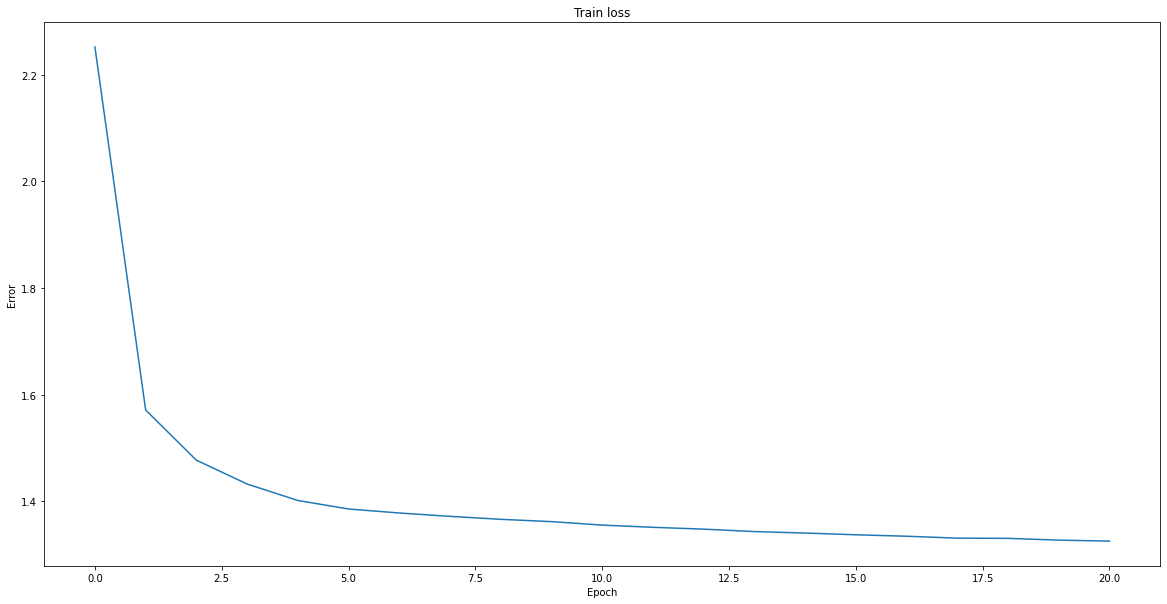

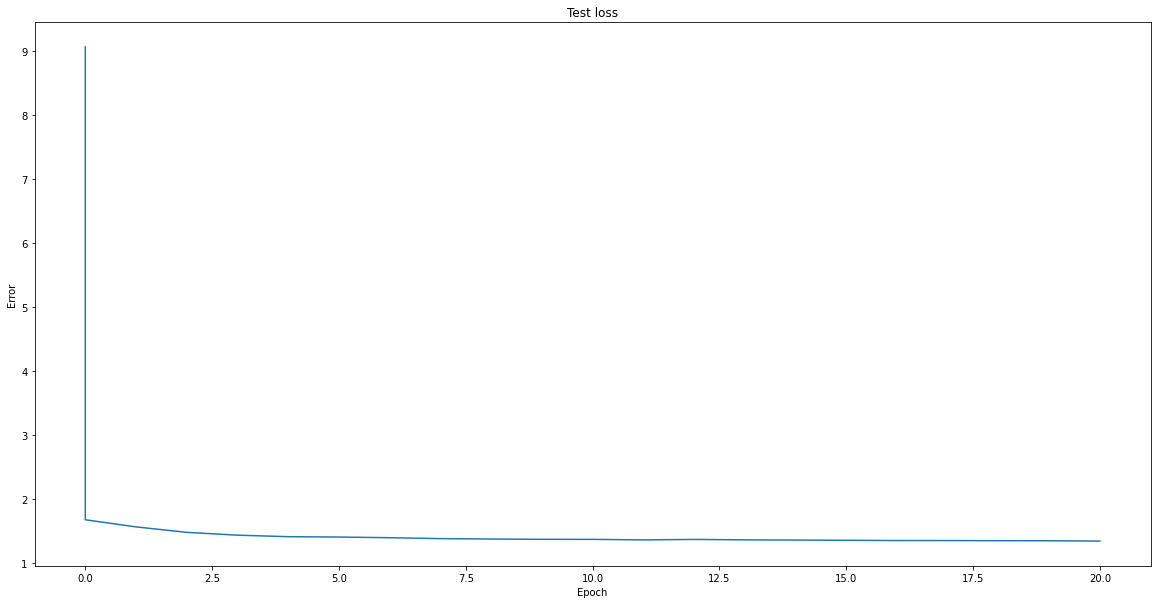

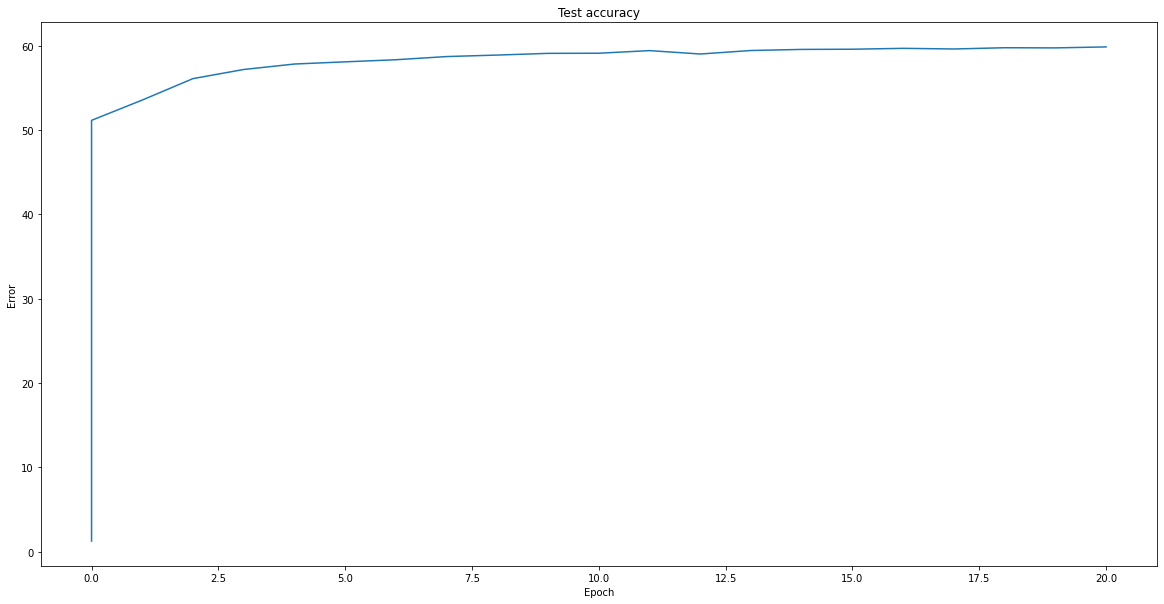

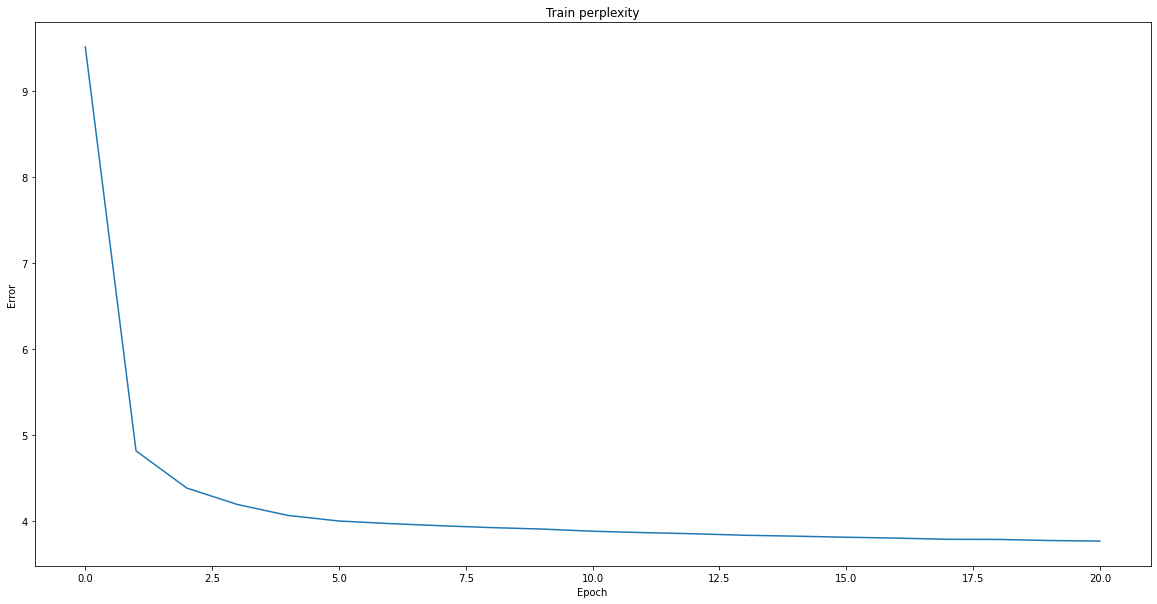

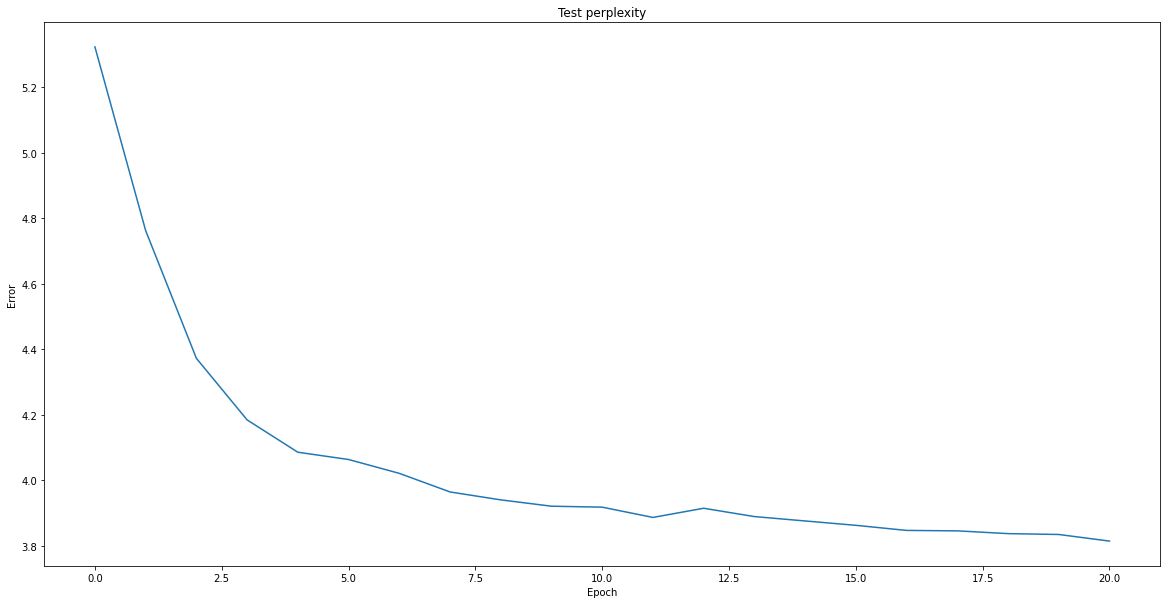

In [ ]:
## 6.Train on words
!rm -r logs
!rm -r checkpoints
def prepare_data_on_words(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # replace all the whitespace characters with ' ' 
    data = re.sub('\s+', ' ', data)
    data.strip()
    
    voc2ind = {}
    tokens = []

    # split by words
    words = re.split(r'([ ])',data)
    freqs = {}
    for word in words:
      if word not in freqs:
        freqs[word] = 1
      else:
        freqs[word] = freqs[word] + 1

    voc2ind['<unknown>'] = 0
    seed = 1

    for word in words:
      if freqs[word] >= 5:
        if word not in voc2ind:
          voc2ind[word] = seed
          seed += 1
        tokens.append(voc2ind[word])
      else:
        tokens.append(voc2ind['<unknown>'])

    ind2voc = {val: key for key, val in voc2ind.items()}

    # determine the place to separate training data and testing data
    tokens_len = len(tokens)
    pivot = int(0.8 * tokens_len)

    train_text = np.array(tokens[:pivot])
    test_text = np.array(tokens[pivot+1:])

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_words_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_words_test.pkl', 'wb'))

prepare_data_on_words(DATA_PATH + 'harry_potter.txt')



def train_on_words():
    SEQUENCE_LENGTH = 40
    BATCH_SIZE = 128
    FEATURE_SIZE = 2048
    TEST_BATCH_SIZE = 128
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs_words/log.pkl'

    # Train on words
    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_words_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_words_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)

    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False)#, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False)#, **kwargs)
    
    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints_words')

    train_losses, test_losses, test_accuracies, train_perplexities, test_perplexities = pt_util.read_log(LOG_PATH, ([],[],[],[],[]))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))

            train_perplexity = np.exp(train_loss)
            test_perplexity = np.exp(test_loss)
            train_perplexities.append((epoch, train_perplexity))
            test_perplexities.append((epoch, test_perplexity))

            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies, train_perplexities, test_perplexities))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*train_perplexities)
        pt_util.plot(ep, val, 'Train perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_perplexities)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    2. What was your lowest test perplexity? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. LSTM
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    

#Answers to Part 9
1. 


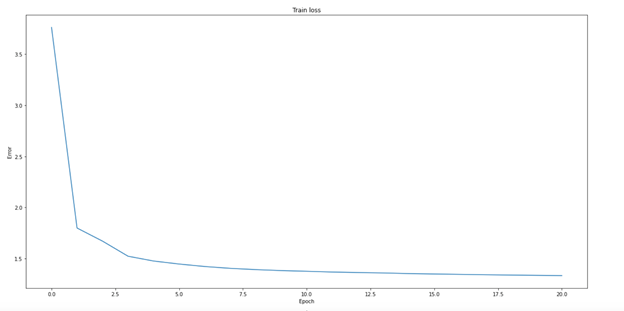
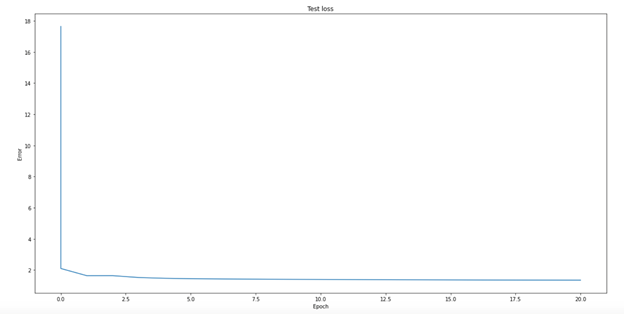
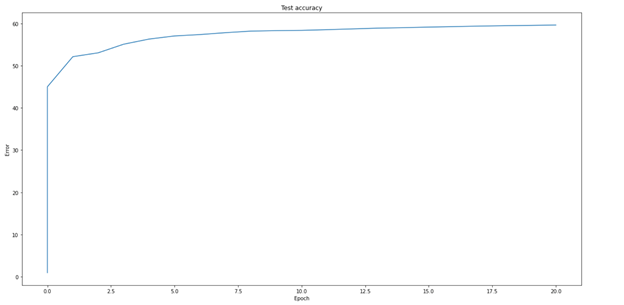
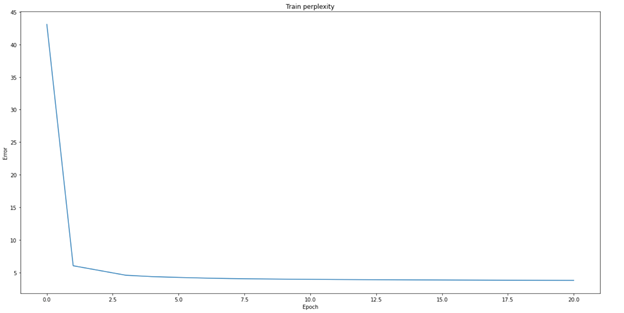
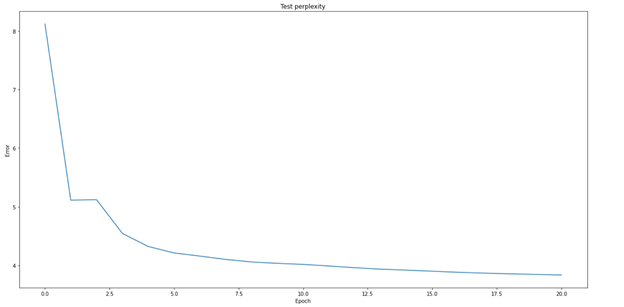


2. The final test accuracy is 60%, the final test perplexity is 3.8.

3. prompt: Tom Riddle laughs,

  generated with sample: Tom Riddle laughs, lying, and stone sluggly to the ear. Propher Never had sir-" not decied the back expered botter what was feet. Penty Ron a shelp shakwil party of and left that Mr. Fiddle turned to be all the right w (My favorite one)

  generated with max: Tom Riddle laughs, and said the started to the stairs and started to the stairs and started to the stairs and started to the stairs and started to the stairs and started to the stairs and started to the stairs and star

  generated with beam: Tom Riddle laughs, and the other side of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castl

4. I think the sample generate the best results. The sample strategy chose characters by its distribution, so it can output some different words even if some of them are wrong. The max and beam search only produce some repeated words.

5. 1) Temperature between 0 and 1 is the best for me. It produces results similar to original work and more diverse than the beam search. It also avoids repeats in beam search and max sampling.

  2) Temperature of 0 makes the most conservative predictions. The results make the best sense and are the most similar to the original work. Temperature of 1 doesn’t change the randomness of prediction. Some of the results of sampling make sense while some don’t. The results of beam search are quite similar to each other when temp = 1. Temperature of 0 < temp < 1 are between these two conditions. The results make sense and are diverse. Temperature of 2 makes more randomness. This brings more creativity to the results. However, this also makes many results ridiculous. Many words are misspelled. If the temperature is negative, the model is reversed, the results would be in chaos.

## Other thing section:
1. New corpus

  1) I chose The Collections of Sherlock Holmes. The character number is 3315162.

  2) I don’t find any difference in the outputs generated by the new/old corpus. They are following the same pattern.

  3) Temperature = 0.5

  Max: sherlock drunks and the carriage of the case of the case of the case of the case of the case of the case of the case of the case of the case of the case of the man who had been the carriage of the man who had been th.

  Sample: sherlock drunks in paper, the drew in the case of this shall see minfoled sling to theared of the ord. Here I shall said you snylly what a leap upon the great he speck of myself, had she the dare of good of the again.

  Beam searching: sherlock drunks of the case of the case of the man who had been the carriage of the man who had been the carriage of the case of the man who had been the carriage of the man who had been the carriage of the man who h.

3. LSTM

  1) I did not encounter any difficulties, everything is fine.

  2) It is very difficult to say LSTM is better or worse than GRU, because their results seem very close.
 
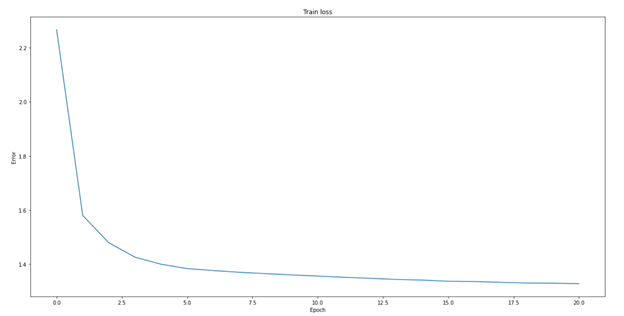
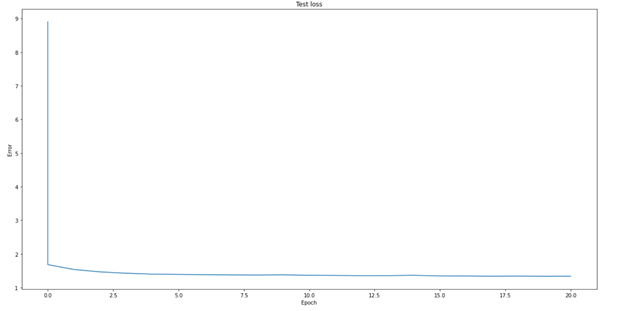
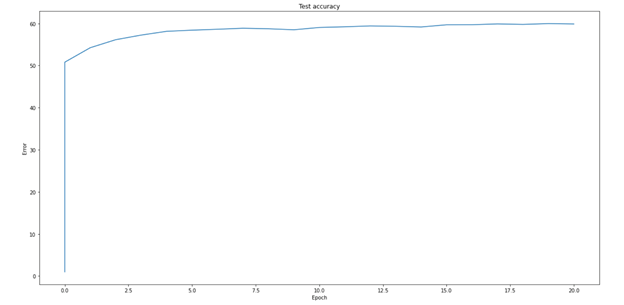
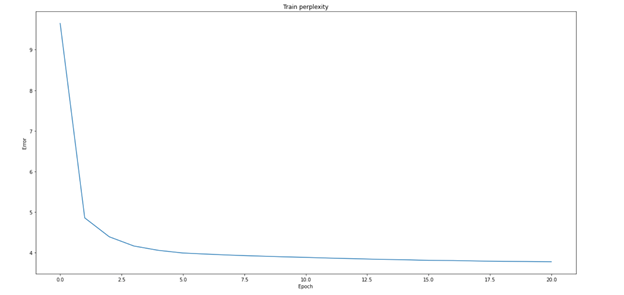
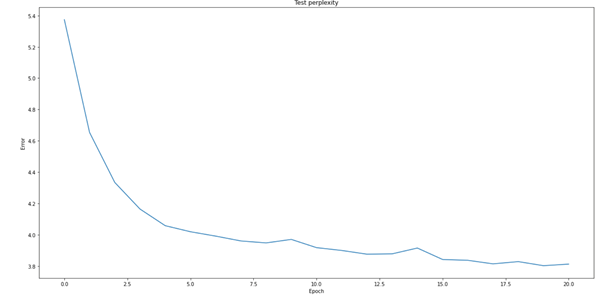


6. Words

  1) For data preprocessing, I must split the sentences by words and handle the spaces appropriately. I also must replace those low-frequent words. For training, I have much larger vocabulary and smaller dataset, which makes the training harder. 

  2) 14404

  3) Since I train on words instead of characters, I can reduce the sequence length for a similar length of prediction. I have a smaller dataset so I should use smaller batch size to increase accuracy. Also, I have much larger vocabulary. Therefore, I may need larger feature size to get more reasonable results. The training process is too slow, so I didn't get an best combination of hyperparameters. I tried with sequence length = 40, batch size = 128, feature size = 2048 and got an accuracy of 60%